# Posner-Becker comparison (no comments)

## Data parsing and filtering

In [1]:
import bisect
import datetime
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import numpy as np
import pandas as pd
import re
import scipy
import seaborn as sns
import spacy
import string

from bertopic import BERTopic
from collections import Counter, defaultdict
from difflib import ndiff
from flair.data import Sentence
from flair.models import TextClassifier
from gensim import corpora, models
from matplotlib import gridspec
from nltk.corpus import stopwords
from pprint import pprint
from scipy.cluster import hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en.stop_words import STOP_WORDS
from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm import tqdm
from transformers import RobertaTokenizerFast
from umap.umap_ import UMAP

2023-11-19 14:19:52.719730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 14:19:54.123934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-19 14:19:54.124098: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-19 14:19:54.124108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def levenshtein(str_1, str_2):
    distance = 0
    buffer_removed = buffer_added = 0
    for x in ndiff(str_1, str_2):
        code = x[0]
        if code == ' ':
            distance += max(buffer_removed, buffer_added)
            buffer_removed = buffer_added = 0
        elif code == '-':
            buffer_removed += 1
        elif code == '+':
            buffer_added += 1
    distance += max(buffer_removed, buffer_added)
    return distance

# nltk.download('punkt')

titles = []
authors = []
all_pars_timestamps = []
all_sents_timestamps = []
all_sents = []

posner_pars = []
becker_pars = []
posner_sents = []
becker_sents = []
posner_sents_timestamps = []
becker_sents_timestamps = []
posner_pars_timestamps = []
becker_pars_timestamps = []
posner_sent_types = []
becker_sent_types = []

title_types = [["Farewell", "other"], ["Sabbatical Notice", "other"], ["The Embargo of Cuba: Time to Go- Becker", "leader"], ["End the Cuban Embargo—Posner", "comment"], ["Should Marijuana Be Decriminalized Nationwide?—Posner", "leader"], ["Why Marijuana Should be Decriminalized- Becker  ", "comment"], ["The War on Drugs", "other"], ["The Myth of Excess Enrollments in College-Becker  ", "leader"], ["Excess Enrollments in College? Could Be. Posner", "comment"], ["Has the United States, by Virtue of Its Size and Complexity, Become Ungovernable?—Posner", "leader"], ["Are Government Bureaucracies Too Big? Becker", "comment"], ["Generational Mobility in the United States-Becker  ", "leader"], ["Social Mobility and Income Inequality—Posner", "comment"], ["Should Partisan Gerrymandering Be Outlawed? Posner", "leader"], ["Neighborhood Gerrymandering- Becker", "comment"], ["Is the US in For Secular Stagnation: Déjà Vu All Over Again- Becker", "leader"], ["Secular Stagnation—Posner", "comment"], ["Bureaucracy and Efficiency—Posner", "leader"], ["Competition and the Efficiency of Bureaucracies- Becker", "comment"], ["Recent Mexican Reforms and the Impact on the United States-Becker", "leader"], ["Mexico’s Economic Reforms—Posner", "comment"], ["Does Redistributing Income from Rich to Poor Increase or Reduce Economic Growth or Welfare? Posner", "leader"], ["Redistribution and the Well-Being of the Poor-Becker", "comment"], ["The Consequences of Abandoning China’s One Child Policy- Becker", "leader"], ["China’s “One Child” Policy—Posner", "comment"], ["What should be done about the federal entitlements spending that is threatening the long-term solvency of the federal government?—Posner", "leader"], ["How to Control Entitlements, Especially Medicare-Becker", "comment"], ["Minimum Wages, Employment, and Inequality-Becker", "leader"], ["Raise the Federal Minimum Wage (But Not Too Far)—Posner", "comment"], ["", "other"], ["Notice", "other"], ["Is Opportunity Declining? Becker", "leader"], ["Equality of Opportunity-Posner", "comment"], ["Why Does College Cost So Much? Posner", "leader"], ["Higher College Costs and its Consequences- Becker", "comment"], ["Ceilings on Government Debt, Taxes, and Government Spending-Becker", "leader"], ["The Debt Ceiling—Posner", "comment"], ["Is it realistic to think that federal spending can be cut substantially in either the short or the long run? Posner", "leader"], ["Can Government Programs be Cut Back? Becker  ", "comment"], ["Capitalism’s Return from the Financial Crisis-Becker", "leader"], ["Has Capitalism Revived/Survived? Posner", "comment"], ["When Should We Interfere in Another Country’s Internal Affairs? Posner", "leader"], ["Bombing Syria? Becker  ", "comment"], ["Dynamic Competition and Anti Trust Policy-Becker  ", "leader"], ["Microsoft’s Dilemma—Posner", "comment"], ["President Obama’s Plan for College Reform—Posner", "leader"], ["Information About Colleges and Student Loans-Becker", "comment"], ["Low Birth Rates: Causes, Consequences, and Remedies-Becker  ", "leader"], ["Does the World Need More People? Posner", "comment"], ["Poverty and Near-Poverty in the United States--Posner", "leader"], ["Education and the Growth of Poverty in United States-Becker  ", "comment"], ["Technological Change and Natural Resource Prices-Becker", "leader"], ["Commodity Price Fluctuations—Posner", "comment"], ["Patent Trolls—Posner", "leader"], ["On Reforming the Patent System -Becker", "comment"], ["The Sequester Is a Failure—Posner", "leader"], ["Has the Government Spending Sequestration Hurt the Economy? Becker", "comment"], ["Should There Be a Carbon Emissions Tax? Posner", "leader"], ["What Should a Carbon Tax Look Like? Becker  ", "comment"], ["The Senate Bill on Immigration Reform-Becker", "leader"], ["What to Do About Immigration, Legal and Illegal? Posner", "comment"], ["Does Medical Care Cost Too Much in the United States? Posner", "leader"], ["Medical Competition and the Cost of Medical Care-Becker", "comment"], ["Reform of the Tax Code-Becker", "leader"], ["Tax Reform—Posner", "comment"], ["Abenomics and Japan’s Stagnation-Becker  ", "leader"], ["Should the European Union Emulate Japan's Inflationary Monetary Policy?—Posner ", "comment"], ["China’s Tilt Toward the Private Sector? Becker  ", "leader"], ["The Chinese Economy—Posner", "comment"], ["Security Surveillance Cameras—Posner", "leader"], ["The Internet, Surveillance Cameras, and Misuse of Big Data-Becker", "comment"], ["The Rise in College Tuition and Student Loans-Becker", "leader"], ["College Costs and Quality—Posner", "comment"], ["Breakthough in the War on Drugs?—Posner", "leader"], ["Alternatives to the War on Drugs-Becker", "comment"], ["Reforming Immigration Policy-Becker", "leader"], ["Reforming Immigration Policy—Posner", "comment"], ["Business Ethics—Posner", "leader"], ["Business, Competition, and Corruption-Becker", "comment"], ["The Decline in Illegal Immigration From Mexico-Becker", "leader"], ["Mexican Immigration to the United States—Posner", "comment"], ["Automation and Employment--Posner", "leader"], ["The Dismal Future for Workers With Few Skills-Becker", "comment"], ["Extending Social Security and Medicare Eligibility Ages-Becker  ", "leader"], ["Extending the Social Security and Medicare Eligiblity Ages—Posner", "comment"], ["Some Economics of Higher Education—Posner", "leader"], ["Higher Education is Still a Very Good Investment-Becker  ", "comment"], ["Will the Sequester Be an Economic Disaster? Becker", "leader"], ["The Sequester-Posner", "comment"], ["Should the Minimum Wage Be Raised to $9?—Posner", "leader"], ["Is Raising the Minimum Wage a Good Idea? Becker", "comment"], ["Contrived Inequality and Equality-Becker", "leader"], ["Contrived and Natural Inequality—Posner", "comment"], ["Rules versus Discretion in Financial and Other Regulation—Posner", "leader"], ["Why I Favor Rules Over Discretion-Becker", "comment"], ["Why Has Competition to Get into Top Colleges Become Much Tougher? Becker", "leader"], ["Competition to Get Into the Best Colleges—Posner", "comment"], ["Should There Be a Debt Ceiling?—Posner", "leader"], ["On the Debt Ceiling-Becker", "comment"], ["Why Does Health in the United States Lag Behind Other Countries’? Becker", "leader"], ["Comparative Longevity—Posner", "comment"], ["More on the Fiscal Cliff—Posner", "leader"], ["How Good is the Fiscal Agreement? Becker", "comment"], ["Meritocracies and Intergeneration Mobility-Becker", "leader"], ["Meritocracy, Social Mobility, Intergenerational Mobility—Posner", "comment"], ["The Fiscal Cliff--Posner", "leader"], ["Spending, Taxation, and the Fiscal Cliff-Becker", "comment"], ["The Becker-Posner Blog: Now on Facebook", "other"], ["The Unemployment Rate and Central Bank Policy-Becker", "leader"], ["Unemployment, Inflation, and the Fed—Posner", "comment"], ["The Professional versus the Business Model in Law and Medicine--Posner", "leader"], ["Is the Business Model Worse Than the Professional Model? Becker", "comment"], ["Breakup of Countries: No Economic Disaster- Becker", "leader"], ["The Optimal Size of Countries--Posner", "comment"], ["MOOCs—Implications for Higher Education—Posner", "leader"], ["Online Courses and the Future of Higher Education-Becker", "comment"], ["Why People Vote and What That Implies-Becker", "leader"], ["The Paradox of Voting--Posner", "comment"], ["What to Do about Illegal Immigration--Posner", "leader"], ["What to Do About Illegal Immigration? Becker ", "comment"], ["The High Unemployment Rate and its Social Cost-Becker", "leader"], ["The Problem of the Long-Term Unemployed--Posner", "comment"], ["Is Banking Unusually Prone to Risky Practices? Posner", "leader"], ["Government Regulation, Competition, and Corruption-Becker", "comment"], ["What Limits to Using Money Prices to Buy and Sell? Becker", "leader"], ["Sale of Body Parts—Posner", "comment"], ["Luck, Wealth, and Implications for Policy--Posner", "leader"], ["Luck and Taxation-Becker", "comment"], ["Will Long-Term Growth Slow Down? Becker", "leader"], ["Will U.S. Economic Growth Slow? Posner", "comment"], ["Do patent and copyright law restrict competition and creativity excessively? Posner", "leader"], ["Reforming the Patent System Toward a Minimalist System-Becker", "comment"], ["Good and Bad Teachers: How to Tell the Difference-Becker", "leader"], ["Rating Teachers—Posner", "comment"], ["Notice", "other"], ["Time for China’s One-Child Policy to Go-Becker", "leader"], ["China’s One-Child Policy—Posner", "comment"], ["Is Banking Unusually Corrupt, and If So, Why? Posner", "leader"], ["Is Banking Unusually Corrupt? Becker", "comment"], ["Is Raising Marginal Tax Rates on Higher Income Individuals a Good Idea? Becker", "leader"], ["The Economic Effects of Increasing Marginal Income Tax Rates—Posner", "comment"], ["Why Is Job Growth Tepid?—Posner", "leader"], ["The Worst Recovery Since World War II-Becker", "comment"], ["The Health Care Mandate: If it seems Like a Tax it is a Tax-Becker", "leader"], ["Is the Health Care Law’s “Mandate” Really a Tax?—Posner ", "comment"], ["Why Are Americans More Religious than Europeans? Posner", "leader"], ["Why are Americans More Religious than Western Europeans? Becker", "comment"], ["Controls Over consumer Choices- Becker", "leader"], ["Bloomberg, Sugar, and Obesity—Posner", "comment"], ["Correction--Posner", "other"], ["The Federal Reserve and the World Economic Crisis—Posner", "leader"], ["Is Further Quantitative Easing by the Fed Warranted? Becker", "comment"], ["Profits, Competition, and Social Welfare-Becker", "leader"], ["Capitalism—Posner", "comment"], ["Is Student Debt Excessive? Posner", "leader"], ["Is Student Debt Too Great? Becker", "comment"], ["Should Greece Exit the Euro Zone? Becker", "leader"], ["Should Greece Abandon the Euro? Posner", "comment"], ["Homosexual Marriage—Posner", "leader"], ["On Homosexual Marriage-Becker", "comment"], ["Why has the Recovery in Employment in the US been so Slow? Becker", "leader"], ["Why Unemployment Remains So High—Posner", "comment"], ["Are the Incentives of College Administrators Well Aligned with Social Welfare? Posner", "leader"], ["Are the Incentives of Colleges Aligned With Social Welfare? Becker", "comment"], ["Concern About The Decline in Manufacturing in the United States? Becker", "leader"], ["Decline of U.S. Manufacturing—Posner", "comment"], ["Notice", "other"], ["Unlimited Campaign Spending—A Good Thing? Posner", "leader"], ["Restrictions on Campaign Contributions- A Good Thing? Becker", "comment"], ["Fracking and Self-Sufficiency in Gas and Oil-Becker", "leader"], ["Energy Self-Sufficiency—Posner", "comment"], ["Should public school teachers have tenure? Posner", "leader"], ["Should K-12 Teachers Have Tenure? Becker", "comment"], ["On the Apparently Growing Class Divide and What can be Done About it-Becker", "leader"], ["The Growing Class Divide—Posner", "comment"], ["Are Bookstores and Libraries Doomed by Digitization? Posner", "leader"], ["Traditional Bookstores and Libraries are Doomed by the Internet, and so too are Many Other Ways to Distribute Content to Consumers-Becker", "comment"], ["Is China’s Economic Future a Rosy One?  Becker", "leader"], ["Will China Overtake Us? Posner", "comment"], ["Amnesty for Illegal Immigrants? Posner", "leader"], ["Illegal Immigration-Becker", "comment"], ["Is Capitalism in Crisis? Becker", "leader"], ["Is Capitalism in Crisis? Posner", "comment"], ["Physician-Assisted Suicide—Posner", "leader"], ["Suicide and its Assistance-Becker", "comment"], ["Wealth and Income Taxes on the Rich-Becker", "leader"], ["Taxing Wealthy People More Heavily—Posner", "comment"], ["Notice", "other"], ["Notice", "other"], ["Does America Imprison Too Many People? Posner", "leader"], ["Does America Imprison Too Many People? Becker", "comment"], ["The Euro Crisis and Euro Bonds-Becker", "leader"], ["The Question of Eurobonds—Posner", "comment"], ["Occupy Wall Street-Posner", "leader"], ["The Occupy Wall Street Movement-Becker", "comment"], ["Has Structural Unemployment Become Important in the United States? Becker", "leader"], ["Structural Unemployment: Posner", "comment"], ["How the United States Is Like, and Unlike, Greece—Posner", "leader"], ["Greece and the Euro-Becker", "comment"], ["Notice", "other"], ["Notice", "other"], ["Notice", "other"], ["Too Many Government Workers?—Posner", "leader"], ["Government Workers and Fiscal Problems-Becker", "comment"], ["Market Failure Compared to Government Failure -Becker", "leader"], ["The Nirvana Fallacy Revisited—Posner", "comment"], ["Obama’s Jobs Speech—Posner", "leader"], ["A Second Stimulus Package? Becker", "comment"], ["In Trouble Once Again: What to do About US Post Office? Becker", "leader"], ["Whither the Post Office and Its Universal Service Obligation? Posner", "comment"], ["Warren Buffett on Taxing the Wealthy More Heavily—Posner", "leader"], ["Buffett and a Better Tax System-Becker", "comment"], ["Deserving and Undeserving Inequality–Becker", "leader"], ["Income Inequality and Envy—Posner", "comment"], ["The English Riots—Posner", "leader"], ["Riots-Becker", "comment"], ["The Challenge of Cyberwarfare and Cyberspying -Becker", "leader"], ["The Challenge of Cyber Warfare—Posner", "comment"], ["The Depression, the Deficit Debacle, and the Debt-Ceiling Crisis—Posner", "leader"], ["Immediate and Medium Term Debt and Deficit Problems-Becker", "comment"], ["The Abysmal Recovery in Employment- Becker", "leader"], ["What to Do about Unemployment in the Short Term?—Posner", "comment"], ["The Federal Deficit Mess—Posner", "leader"], ["Short and Long Term United States Fiscal Crises-Becker", "comment"], ["Will Large-Scale Illegal Immigration from Mexico Come to an End? Becker", "leader"], ["The Decline in Immigration from Mexico: What It Means for the United States—Posner", "comment"], ["Primary-Care Physicians and the Reform of Health Care—Posner", "leader"], ["Is There a Shortage of Primary Care Physicians? Becker", "comment"], ["Fluctuations in Oil Prices, Speculation, and Strategic Reserves-Becker", "leader"], ["Releasing Oil from Reserves—Posner", "comment"], ["Why the economic recovery is lagging—Posner", "leader"], ["The Slow Economic Recovery-Becker", "comment"], ["“Capture” of Regulators by Fannie Mae and Freddie Mac-Becker", "leader"], ["Capture Theory and the Financial Crisis—Posner", "comment"], ["Legacy Admissions to Colleges and Universities—Posner", "leader"], ["Legacy Preferences Make a Lot of Sense, Up to a Point-Becker", "comment"], ["Another Tech Bubble in the Offing? Becker", "leader"], ["Is There a Social-Network Bubble? Posner", "comment"], ["Life Extension versus Quality-of-Life Enhancement—Posner ", "leader"], ["Are There Sizable Benefits From Extending the Lives of the Old and Frail? Becker  ", "comment"], ["Subsidies to Oil and Other Energy Sources-Becker", "leader"], ["The U.S. Tax Subsidies for Oil Companies—Posner", "comment"], ["Does the Earth Have Room for 10 Billion People? Posner", "leader"], ["Yes, the Earth Will Have Ample Resources for 10 Billion People-Becker", "comment"], ["Can Poor Countries Afford Democracy? Becker", "leader"], ["Can Poor Countries Afford Democracy?—Posner", "comment"], ["Consumer Protection in the Airline Industry—Posner", "leader"], ["How Can Governments Help Consumers- Becker", "comment"], ["How to (and not to) Help Poor Families in Developing Countries Cope with Rising Food Prices-Becker", "leader"], ["Commodity Price Inflation—Posner", "comment"], ["Paul Ryan’s Budget Proposal—Posner", "leader"], ["Paul Ryan’s Roadmap for America’s Budgetary Future-Becker", "comment"], ["The NCAA as a Powerful Cartel-Becker", "leader"], ["Monopsony in College Athletics—Posner", "comment"], ["Public-Employee Unions—Posner", "leader"], ["Government Sector Unions-Becker", "comment"], ["The Economic Implications of the Japanese Earthquake Disaster and its Aftermath-Becker", "leader"], ["The Japanese Catastrophe—Posner", "comment"], ["What Is a College Degree Really Worth?—Posner", "leader"], ["Are Too Many Young People Going to College? Becker", "comment"], ["The Middle East Uprisings, their Economies, and the World Economy-Becker", "leader"], ["The Middle East Uprisings and the Economy—Posner", "comment"], ["The Overdiagnosis Problem—Posner", "leader"], ["How Beneficial is Widespread Medical Screening? Becker", "comment"], ["What Kind of Gun Control? Becker", "leader"], ["Gun Control—Posner’s Comment", "comment"], ["Why Dictatorial Regimes Are Brittle—Posner", "leader"], ["Abrupt Change of Authoritarian Regimes-Becker", "comment"], ["Bad and Good Inequality-Becker", "leader"], ["Inequality in Income and Wealth—Posner", "comment"], ["The Crisis in Microfinance—Posner", "leader"], ["Overselling of Microfinance-Becker", "comment"], ["The Case for Tuition Increases at Public Universities-Becker", "leader"], ["Raising Public-College Tuition—Posner ", "comment"], ["Can Bookstores Survive? Prospects and Consequences—Posner", "leader"], ["Traditional Bookstores are Doomed-Becker", "comment"], ["Implications of International Comparisons of Student Performance-Becker", "leader"], ["The PISA Rankings and the Role of Schools in Student Performance on Standardized Tests—Posner", "comment"], ["The Tax and Spending Compromise-Becker", "leader"], ["The Tax Deal: A Second Stimulus?—Posner", "comment"], ["The Dismal State of Long-Term State and Local Government Finance-Becker", "leader"], ["State and Local Government: The Fiscal Crisis—Posner", "comment"], ["Note to Drug Legalization Post", "other"], ["Drug Legalization—Posner", "leader"], ["The American War on Drugs is Not Only an American Disaster-Becker", "comment"], ["The Sluggish US Employment Picture-Becker", "leader"], ["Unemployment—Posner", "comment"], ["A Further Comment on Contraception and Catholicism—Posner", "response"], ["Contraception and Catholicism—Posner", "leader"], ["The Behavior of Catholics and Contraceptive Use-Becker", "comment"], ["Public Policies and Rising World Food Prices Once Again-Becker", "leader"], ["Global Food Prices—Posner", "comment"], ["Quantitative Easing—Posner", "leader"], ["Why I Do Not Like QE2-Becker", "comment"], ["An Economic Growth and Deficit Reduction Agenda for Congress and the President- Becker", "leader"], ["The New Congress and Economic Growth—Posner’s Comment", "comment"], ["The United Kingdom’s Dramatic Response to the Economic Crisis—Posner", "leader"], ["Contrasts Between the US’s and UK’s Post-Recession Policies-Becker", "comment"], ["Will the Earnings of Women Overtake Those of Men? Becker", "leader"], ["Male and Female Earnings Trends—Posner", "comment"], ["The Controversy over Birthright Citizenship—Posner", "leader"], ["Should Children Born in the United States Automatically Become Citizens? Becker", "comment"], ["Democracy or Autocracy: Which is Better for Economic Growth? Becker", "leader"], ["Autocracy, Democracy, and Economic Welfare—Posner", "comment"], ["The Value-Added Teacher Reform Program—Posner", "leader"], ["Incentives to Teachers and Students-Becker", "comment"], ["Notice", "other"], ["Higher Education and Technological Advances as Countries Develop-Becker", "leader"], ["Education and Innovation in Developing Countries—Posner", "comment"], ["Is the Federal Government Broke? Posner", "leader"], ["How Dismal is the Fiscal Future For America and Europe? Becker", "comment"], ["Will the Next Generation be Better off Than Their Parents’ Generation? Becker", "leader"], ["The Decline in American Optimism—Posner", "comment"], ["Our Limping Economic Recovery—Posner", "leader"], ["The Slowdown in the Economic Recovery-Becker", "comment"], ["Germany vs. US: Two Different Approaches to the Recession-Becker", "leader"], ["German Employment—Posner", "comment"], ["Unionism and Economic Recovery—Posner", "leader"], ["Unions and the Obama Administration-Becker", "comment"], ["correction", "other"], ["Should Unemployment Compensation be Extended? Becker", "leader"], ["Against Extending Unemployment Benefits—Posner", "comment"], ["Abuse of Presidential Power? Posner", "leader"], ["The Abuse of Presidential Power-Becker", "comment"], ["Five Major Defects of the Financial Reform Bill-Becker", "leader"], ["The Financial Regulation Law—Posner’s Comment", "comment"], ["The  Gulf Oil Leak—Posner", "leader"], ["The Gulf Oil Leak and Optimal Safety Precautions-Becker", "comment"], ["How to Greatly Reduce the Fiscal Burden of Entitlements-Becker", "leader"], ["The Entitlements Quandary—Posner", "comment"], ["The Controversy over For-Profit Colleges—Posner", "leader"], ["Default Rates and For-Profit Colleges- Becker", "comment"], ["Notice", "other"], ["Will Africa Finally Take Off? Becker", "leader"], ["Is Sub-Saharan Africa at a Turning Point? Posner", "comment"], ["Europe’s Long-Term Economic Woes—and America’s", "leader"], ["Slow Economic Growth is a Crucial European Problem-Becker", "comment"], ["Central Bank Independence-Becker", "leader"], ["Should Central Banks Be Politically Independent? Posner", "comment"], ["Asset-Price Bubbles—Posner", "leader"], ["Social Interactions and Bubbles-Becker", "comment"], ["Slow Recovery in US Employment? Becker", "leader"], ["Stubbornly High Unemployment—Posner", "comment"], ["Did Speculation Make the Economic Crisis Deeper or Shallower? Posner", "leader"], ["The Value of Profitable Speculation-Becker", "comment"], ["Should the US Introduce a Value Added Tax? Becker", "leader"], ["Should the United States Institute a Federal Value-Added Tax? Posner", "comment"], ["American Wage Stagnation—Posner", "leader"], ["Trends in American Income Inequality Prior to the Recession-Becker", "comment"], ["The Looming Entitlement Fiscal Burden-Becker", "leader"], ["The Entitlement Quandary—Posner", "comment"], ["The End of Marriage? Posner", "leader"], ["The Effects on Children of the Decline in Marriage-Becker", "comment"], ["The Health Care Bill: Progress or Retrogression? Becker", "leader"], ["The Health Care Bill—Posner’s Comment", "comment"], ["Greece’s Economic Crisis—Posner", "leader"], ["Will the Euro Survive its Current Difficulties? Becker", "comment"], ["The Long-Term Unemployed: Consequences and Possible Cures-Becker", "leader"], ["Long-Term Unemployment—Posner", "comment"], ["Should the Senate Abolish the Filibuster? Posner", "leader"], ["The Filibuster and Supermajorities-Becker", "comment"], ["Fiscal Stimulus Packages: What are their Effects? Becker", "leader"], ["Stimulus: Pluses and Minuses—Posner", "comment"], ["Double Exports in Five Years? Posner", "leader"], ["Should the Government try to Stimulate US Exports? Becker", "comment"], ["Are e-Readers the Beginning of the End for Books? Becker", "leader"], ["Will Printed Books Soon Be Obsolete? Posner", "comment"], ["The Question of Consumer Competence—Posner", "leader"], ["On Consumer Competence-Becker", "comment"], ["Subsidies to Small Business? Becker", "leader"], ["The Job-Subsidy Plan—Posner", "comment"], ["Optimal Protection against Terrorist Attacks on Airlines—Posner", "leader"], ["Fear, Profiling, and Terrorism on Airplanes-Becker", "comment"], ["Notice", "other"], ["The Internet, Competition, and Censorship-Becker", "leader"], ["The Internet, Competition, and Censorship—Posner’s Comment", "comment"], ["Why Aren’t Americans Happier?—Posner", "leader"], ["Happiness and Wellbeing- Becker", "comment"], ["The Revolution in the Economic Empowerment of Women-Becker", "leader"], ["Should the Government Use Its Monopsony Power to Reduce the Price of Drugs? Posner", "leader"], ["Government Demand for Drugs and Drug Prices-Becker", "comment"], ["Failure in Copenhagen-Becker", "leader"], ["The Copenhagen Debacle: Where Do We Go from Here? Posner", "comment"], ["Should We Jettison GDP As an Economic Measure? Posner", "leader"], ["We Should Amend, not Discard, National Income Accounts-Becker", "comment"], ["Should the Fed Remain Independent? Becker", "leader"], ["Should the Fed Remain Independent? Posner", "comment"], ["Announcement: The Becker-Posner Blog Has Moved", "other"], ["The President's Forthcoming \"Jobs Summit\"--Posner", "leader"], ["How to Increase Employment- Becker", "comment"], ["Should China Allow its Currency to Appreciate? Becker", "leader"], ["China's Currency and Reserves--Posner", "comment"], ["Will We Go the Way of Japan?--Posner", "leader"], ["Will We Go the Way of Japan? No, Unless US Government Policies Discourage Growth-Becker", "comment"], ["Productivity and Jobs-Becker", "leader"], ["Productivity and Unemployment--Posner", "comment"], ["Fiscal Imprudence, Distributive Injustice: the $250 per Social Security Annuitant Plan--Posner", "leader"], ["Fiscal Imprudence and Fiscal Stimulus-Becker", "comment"], ["Notice", "other"], ["Pay Controls Once Again-Becker", "leader"], ["Pay Caps for Financial Executives--Posner", "comment"], ["The Economics of Organizations--Posner", "leader"], ["Competition and Organizational Efficiency-Becker", "comment"], ["Notice", "other"], ["Will World Food Prices Resume their Sharp Increase? Becker", "leader"], ["Will Food Prices Begin Increasing Again? Posner's Comment", "comment"], ["Should the Swiss Health Care System Be Our Model?--Posner", "leader"], ["Is the Swiss Health Care System a Good Model for US? Becker", "comment"], ["Union Power in the Obama Administration-Becker", "leader"], ["The Tariff on Chinese Tires--Posner's Comment", "comment"], ["Notice", "other"], ["Do Deficits Matter? Posner", "leader"], ["How Much Should We Care About Government Deficits? Becker", "comment"], ["Productivity, Unemployment, and the End of the Recession-Becker", "leader"], ["Unemployment and Depression--Posner", "comment"], ["Notice", "other"], ["Do We Need More Regulation of Mortgages to Protect Consumers?--Posner", "leader"], ["More Regulation of Mortgages would Likely Hurt Consumers-Becker", "comment"], ["The Cash for Clunkers Program: A Bad Idea at the Wrong Time-Becker", "leader"], ["Cash for Clunkers--Posner's Comment", "comment"], ["Health Care, Cost, and Insurance Theory--Posner", "leader"], ["American Health Care Once Again-Becker", "comment"], ["Notice", "other"], ["The World Recession is Ending: What Next? Becker", "leader"], ["It", "comment"], ["Health Reform and Obesity--Posner", "leader"], ["Mortality from Disease and the American Health Care System-Becker", "leader"], ["American Health Care--Posner's Comment", "comment"], ["The Drop in University Endowments and What to Do about It--Posner", "leader"], ["How Should Universities React to the Decline in Their Endowments? Becker", "comment"], ["Legislation on Clean Energy-Becker", "leader"], ["The Cap and Trade Carbon-Emissions Bill--Posner", "comment"], ["The Senate and the Filibuster--Posner", "leader"], ["The Senate Filibuster -Becker", "comment"], ["President Obama's Financial Reform Package-Becker", "leader"], ["Financial Regulatory Reform--Posner's Comment", "comment"], ["The Future of Newspapers--Posner", "leader"], ["The Social Cost of the Decline of Newspapers?Becker", "comment"], ["Notice", "other"], ["The Fatal Conceit: A Pay \"Czar\"-Becker", "leader"], ["The Pay Czar and Compensation Issues--Posner's Comment", "comment"], ["The Administration's Health Care Plan--Posner", "leader"], ["Health Care-Becker", "comment"], ["Is the World Economic Center of Gravity Moving to Asia? Becker", "leader"], ["Is Asia Becoming the Center of the World Economy? Posner", "comment"], ["A Soda or Calorie Tax to Reduce Obesity--Posner", "leader"], ["A Tax on Sodas? Becker", "comment"], ["The Conflict in Modern Conservatism Once Again-Becker", "leader"], ["Conservatism II--Posner's Comment", "comment"], ["Is the Conservative Movement Losing Steam? Posner", "leader"], ["The Serious Conflict in the Modern Conservative Movement-Becker", "comment"], ["Announcement-Posner", "other"], ["Some Economics of Flu Pandemics-Becker", "leader"], ["Is the Federal Reserve Losing Its Independence? Posner", "leader"], ["Central Banks Cannot Easily Maintain their Independence- Becker", "comment"], ["Repayment of Tarp Bank Loans-Becker", "leader"], ["Repaying the Government's Loans to the Banks--Posner's Comment", "comment"], ["Is the Stock Market an \"Efficient\" Market?--Posner", "leader"], ["Comments on the Efficiency of Stock Markets-Becker", "comment"], ["Reply to Comment on Housing--Posner", "response"], ["Housing Prices and Consumption-Becker", "leader"], ["Housing Prices, Wealth, and the Current Depression--Posner's Comment", "comment"], ["An Addendum on the Treasury's Plan to Buy Bank Assets-Becker", "response"], ["Housing Prices, Wealth, and the Current Depression--Posner's Comment", "leader"], ["The Treasury's Plan to Buy Bank Assets-Becker", "comment"], ["Match Making through the Internet-Becker", "leader"], ["Internet Matching--Posner's Comment", "comment"], ["Tax Deductions for American Charitable Donations Abroad--Posner", "leader"], ["American Charitable Deductions Abroad-Becker", "comment"], ["Financial Regulations-Becker", "leader"], ["Re-Regulating the Banking Industry--Posner", "comment"], ["Notice", "other"], ["China Bashing Once Again-Becker", "leader"], ["China and the U.S. Depression--Posner", "comment"], ["Notice", "other"], ["Against the Pay Caps--Posner", "leader"], ["Pay Controls Do Not Work at Any Level-Becker", "comment"], ["Buy American Once Again-Becker", "leader"], ["Protectionism in a Depression--Posner", "comment"], ["Protectionism in a Depression--Posner", "other"], ["The Employee Free Choice Act--Posner", "leader"], ["Will the Decline in Union Membership be Reversed? Becker", "comment"], ["Infrastructure in a Stimulus Package-Becker", "leader"], ["Infrastructure in a Stimulus Package-Becker", "other"], ["Deficit Spending on Infrastructure in a Depression--Posner", "comment"], ["The Obama \"Stimulus\" (Deficit Spending) Plan--Posner", "leader"], ["On the Obama Stimulus Plan-Becker", "comment"], ["Is This a Good Time to Raise Taxes on Gasoline? Becker", "leader"], ["Raise Gasoline Taxes Now? Posner's Comment", "comment"], ["Can the United Auto Workers Survive? Posner", "leader"], ["Unions in the American Economy-Becker", "comment"], ["The Madoff Ponzi Scheme-Becker", "leader"], ["Bernard Madoff and Ponzi Schemes--Posner's Comment", "comment"], ["The Auto Bailout Issue‚ÄîPosner", "leader"], ["Why Bankruptcy is the Best Solution for American Auto Companies--Becker", "comment"], ["Central Bank Confidence in Taming the Business Cycle: A Grand Illusion? Becker", "leader"], ["Macroeconomic Policy and the Current Depression--Posner", "comment"], ["The Future of Conservatism--Posner", "leader"], ["The Future of Free Market Conservatism- Becker", "comment"], ["Notice", "other"], ["Bail Out the Big Three Auto Producers? Not a Good Idea-Becker", "leader"], ["Bail Out the Detroit Auto Manufacturers? Posner's Comment", "comment"], ["Do Depressions Have a Silver Lining? Posner", "leader"], ["Depressions Cause a lot More Pain than Benefits-Becker", "comment"], ["Does the Free Market Corrode Moral Character?-Becker", "leader"], ["Does the Free Market Corrode Moral Character? Posner's Comment", "comment"], ["The Controversy over the Milton Friedman Institute--Posner", "leader"], ["Observations on the Milton Friedman Institute at the University of Chicago-Becker", "comment"], ["Is the Goose that Laid the Golden Eggs Severely Wounded? Becker", "leader"], ["Has the Market Economy Failed? Posner", "comment"], ["The Financial Crisis: Why Were Warnings Ignored?--Posner", "leader"], ["Why the Warnings were Ignored: Too many False Alarms-Becker", "comment"], ["Government Equity in Private Companies: A Bad Idea-Becker", "leader"], ["Equities, Pay Caps, Liquidity: Structuring a Bailout--Posner", "comment"], ["The $700+ Billion Bailout--Posner", "leader"], ["The Financial Crisis II-Becker", "comment"], ["The Crisis of Global Capitalism?Becker", "leader"], ["The Financial Crisis: the Role of Government--Posner", "comment"], ["Prediction Markets and the Election--Posner", "leader"], ["Political Prediction Markets-Becker", "comment"], ["Competitive Markets and Discrimination Against Minorities-Becker", "leader"], ["Competition, Discrimination, and Law--Posner's Comment", "comment"], ["Notice", "other"], ["Why Is Hollywood Dominated by Liberals? Posner", "leader"], ["Hollywood and Liberals-Becker", "comment"], ["Determinants of the Olympic Success of Different Countries-Becker", "leader"], ["Financing the Olympic Games--Posner's Comment", "comment"], ["The Economics of Gay Marriage--Posner", "leader"], ["Should Gay Marriages be Allowed? Becker", "comment"], ["Is America in Decline? Becker", "leader"], ["Is America in Decline? Posner's Comment", "comment"], ["Compelled Disclosure of Food Characteristics--Posner", "leader"], ["Is Government Intervention in the Fast Food Industry Justified? Becker", "comment"], ["Should US Taxes on Gasoline be Higher? Becker", "leader"], ["Should Gasoline Taxes Be Raised or Lowered? Posner's Comment", "comment"], ["Trusts for Pets--Supplemental Comment--Posner", "response"], ["Should Dogs Get $8 Billion from the Helmsley Estate? Posner", "leader"], ["Cats and Dogs, and \"Sensible\" Bequests-Becker", "comment"], ["The Graying of College Faculties-Becker", "leader"], ["Aging Professors: Posner's Comment", "comment"], ["Are Newspapers Doomed?--Posner", "leader"], ["Yes, Newspapers are Doomed-Becker", "comment"], ["Energy Prices, Offshore Drilling, and an \"Excess\" Profits Tax-Becker", "leader"], ["Oil Prices, Offshore and Alaska Drilling, and Excess Profits Taxes--Posner's Comment", "comment"], ["Have We Lost the Moral Values That Undergird a Commercial Society?--Posner", "leader"], ["Borrowing and Consumption over the Life Cycle-Becker", "comment"], ["The Boom in College Education-Becker", "leader"], ["The Boom in College Education--Posner", "comment"], ["The Cost of Infrastructure Deterioration--Posner", "leader"], ["Infrastructure and the Value of Time-Becker", "comment"], ["Paying the Poor to Improve their School Performance-Becker", "leader"], ["Paying Children to Go to School--Posner's Comment", "comment"], ["Consumer Protection--Posner", "leader"], ["How Much government Regulation to \"Protect\" Consumers?Becker", "comment"], ["The Rise in the Price of Oil-Becker", "leader"], ["Why We Should Be Rooting for $200 per Barrel of Oil--Posner", "comment"], ["The Outlandish Farm Subsidies--Posner", "leader"], ["Farm Subsidies and Farm Taxes-Becker", "comment"], ["Greater Regulation of Financial Markets? Becker", "leader"], ["Re-Regulate Financial Markets?--Posner's Comment", "comment"], ["Why Is Airline Service So Bad? Posner", "leader"], ["The Decline of Airline Service-Becker", "comment"], ["Addendum on Rising Food Prices-Becker", "response"], ["Rising Food Prices and Public Policy-BECKER", "leader"], ["Food Prices and Malthusian Economics--Posner's Comment", "comment"], ["Compensation under Competition--Posner", "leader"], ["Risk-Taking by Top Executives-Becker", "comment"], ["Drugs and the Cost of Medicare -Becker", "leader"], ["The Medicare Challenge--Posner's Comment", "comment"], ["Intelligence Doping--Posner", "leader"], ["Comment on Intelligence Doping-Becker", "comment"], ["The Erosion of Individual Responsibility-BECKER", "leader"], ["Individual Responsibility--Posner's Comment", "comment"], ["William Buckley, Economics, and the Conservative Movement--Posner", "leader"], ["William F. Buckley and Economics-Becker", "comment"], ["The New Gender Gap in Education-Becker", "leader"], ["The New Gender Gap in Education--Posner's Comment", "comment"], ["Should Universities Have to Spend 5 Percent of Their Endowmen Annually?--Posner", "leader"], ["College Tuition and Endowments-Becker", "comment"], ["Can Gun Control Laws be Effective? Becker", "leader"], ["Gun Control--Posner's Comment", "comment"], ["Bill Gates on Corporate Philanthropy--Posner", "leader"], ["On Corporate Altruism-Becker", "comment"], ["Selling Illegal Residents the Right to Stay -Becker", "leader"], ["What (If Anything) to Do About Illegal Immigration--Posner's Comment", "comment"], ["Why Are Tax Burdens So Different in Different Developed Countries?--Posner", "leader"], ["Tax Burdens-Becker", "comment"], ["Slowing of Black Progress-Becker", "leader"], ["The Black-White Income Differential--Posner's Comment", "comment"], ["The Candidates' Health Care Reform Plans--Posner", "leader"], ["Potential Reforms of American Health Care-Becker", "comment"], ["Does Economic Development Reduce Terrorism? Becker", "leader"], ["Terrorism and Economic Development--Posner's Comment", "comment"], ["The Liberal Skew in Higher Education--Posner", "leader"], ["Events, Field, and the Liberal Skew in Higher Education-Becker", "comment"], ["The Subprime Housing Crisis -Becker", "leader"], ["The Subprime Mortgage Mess--Posner's Comment", "comment"], ["The UN's Human Development Index: A Critique--Posner", "leader"], ["How to Combine Income and Life Expectancy into an Index of Wellbeing-Becker", "comment"], ["Why Sovereign Funds? Becker", "leader"], ["Sovereign-Wealth Funds--Posner's Comment", "comment"], ["Notice", "other"], ["Carbon Offsets--Posner", "leader"], ["Why so Little Tax Evasion? Becker", "leader"], ["Tax Evasion--Posner's Comment", "comment"], ["Is the Bond Market the Best Predictor of the Outcome of a War?--Posner", "leader"], ["Iraqi Bonds and the Effects of the Surge-Becker", "comment"], ["Reply to Comments on Billionaires--Posner", "response"], ["Billionaires-Becker", "leader"], ["The Proliferation of Billionaires--Posner's Comment", "comment"], ["Why Is So Much Product Information False or Incomplete, Yet Not Misleading?--Posner", "leader"], ["Advertising and Product Information-Becker", "comment"], ["Notice", "other"], ["Rising Food Prices and What That Means-Becker", "leader"], ["Food Prices and Ethanol--Posner's Comment", "comment"], ["Should Hosts Be Liable for Serving Liquor to Guests Who Cause Accidents While Driving under the Influence?--And Other Issues of Third-Party Liability--Posner", "leader"], ["Third-Party Liability? Becker", "comment"], ["Globalization and Inequality-Becker", "leader"], ["Globalization and Inequality--Posner's Comment", "comment"], ["Free Speech--Posner's Reply to Comments", "response"], ["Free Speech in American Universities--Posner", "leader"], ["Intellectuals, Free speech, and Capitalism-Becker", "comment"], ["The Decline of Unions-Becker", "leader"], ["Universal National Service--Posner", "leader"], ["Universal National Service is a Tax, and a Bad One ‚ÄìBecker", "comment"], ["Rules vs. Authority in Central Bank (and Other) Policies-Becker", "leader"], ["Rules versus Discretion--Posner's Comment", "comment"], ["How to Control China's \"Export\" of Air Pollution--Posner", "leader"], ["China's Air Pollution-Becker", "comment"], ["The Transformation of the Kibbutz and the Rejection of Socialism-Becker", "leader"], ["The Kibbutz--Posner's Comment", "comment"], ["Infrastructure--Posner's Response to Comments", "response"], ["The Infrastructure \"Crisis\"--Posner", "leader"], ["The Infrastructure \"Crisis\" Once Again-Becker", "comment"], ["Responses to Comments on Air Transportation and on the Credit Crunch--Posner", "response"], ["Should Central Banks Intervene During This Financial Crisis? Becker", "leader"], ["Against Bailouts--Posner's Comment", "comment"], ["Air Transportation Delay--Posner", "leader"], ["Why Air Transportation Delays? Becker", "comment"], ["Response to Comments on Social Obesity--Posner", "response"], ["Social Causes of the Obesity \"Epidemic\"-Becker", "leader"], ["Social Obesity--Posner's Comment", "comment"], ["Decision Theory and the War in Iraq--Posner", "leader"], ["Comment on Benefit Cost Analysis Applied to the Iraq War-Becker", "comment"], ["Do National Security and Environmental Energy Policies Conflict? Becker", "leader"], ["Environment and National Security--Posner's Comment", "comment"], ["Hedge Funds and Rent-Seeking--Posner", "leader"], ["Comment on Hedge Funds--Becker", "comment"], ["Further Notice", "other"], ["Notice", "other"], ["The International Market for Talent-Becker", "leader"], ["Outsourcing and the International Market in Highly Skilled Workers--Posner's Comment", "comment"], ["Are Subprime Loans Useful? BECKER", "leader"], ["Subprime Mortgage Loans--Posner's Comment", "comment"], ["Women's Economic Role--Posner's Response to Comments", "response"], ["Intelligence and Leadership--Posner", "leader"], ["Intelligence and Leadership-BECKER", "comment"], ["Women's Role in the Economy-BECKER", "leader"], ["Women's Economic Role--Posner's Comment", "comment"], ["Ex Ante Compensation for Military Death--Posner", "leader"], ["Comment on Military Pay-BECKER", "comment"], ["Immigration Reform-BECKER", "leader"], ["Immigration Reform--Posner's Comment", "comment"], ["Notice", "other"], ["Family Control of Voting Stock in Newspapers and Other Media Companies--Posner", "leader"], ["Different Voting Classes of Shares, and Family Control of Newspapers-BECKER", "comment"], ["Crime and Economic Development-BECKER", "leader"], ["Crime and Corruption--Posner's Comment", "comment"], ["Protests against the War in Iraq--Posner's Reply to Comments", "response"], ["Why No Violent Protests Against the Iraq War?--Posner", "leader"], ["Protests and the Iraq War-BECKER", "comment"], ["Brief Response on Health Care and Tort Reform--Posner", "response"], ["The Benefits of Education-BECKER", "leader"], ["Is Higher Education a Good Investment?--Posner's Comment", "comment"], ["The Reform of Health Care--Posner", "leader"], ["Some Priorities in Reforming Health Care-BECKER", "comment"], ["Employee Ownership Through ESOPS:A Bad Bargain-BECKER", "leader"], ["The Economics of ESOPs--Posner's Comment", "comment"], ["Is the Tort System Costing the United States $865 Billion a Year?--Posner", "leader"], ["Private Property and Socialism: A Contradiction? BECKER", "leader"], ["Private Property in China--Posner's Comment", "comment"], ["Judicial Salaries--Posner", "leader"], ["How to Use Pensions to Improve Judicial Tenure-Becker", "comment"], ["Should Marriage be Subsidized? Becker", "leader"], ["Should Marriage Be Subsidized?--Posner's Comment", "comment"], ["The Economics of College and University Rankings--Posner", "leader"], ["Some Economics of Rankings-BECKER", "comment"], ["How to Conserve Water Efficiently-BECKER", "leader"], ["The Science and Economics of Water Shortage--Posner", "comment"], ["Should Genetic Testing Be Forbidden?--Posner", "leader"], ["Comment on Genetic Testing-BECKER", "comment"], ["Is Sex Selection of Births Undesirable? BECKER", "leader"], ["Correction", "other"], ["Sex Selection--Posner's Comment", "comment"], ["Global Warming--Posner's Response to Comments", "response"], ["Global Warming and Discount Rates--Posner", "leader"], ["Discounting Greenhouse Gas Effects in the Distant Future-BECKER", "comment"], ["Reforming the American Health Care System-BECKER", "leader"], ["Health Care Reform--Posner's Comment", "comment"], ["Correction--Posner", "other"], ["Should the United States Provide Foreign Aid?--Posner", "leader"], ["Is There a Case for Foreign Aid? BECKER", "comment"], ["Posner's Response to Comments on Libertarian Paternalism", "response"], ["Libertarian Paternalism: A Critique--BECKER", "leader"], ["Libertarian Paternalism--Posner's Comment", "comment"], ["AIDS in Africa--Posner's Response to Comments", "response"], ["Progress in Fighting AIDS in Africa?--Posner", "leader"], ["Charitable Foundations--Posner's Comment", "comment"], ["Responses on Drunken Driving and Trans Fats--BECKER", "response"], ["Fatalities from Drunken Driving--BECKER", "leader"], ["Drunk Driving--Posner's Comment", "comment"], ["The Trans Fats Ban--Posner's Response to Comments", "response"], ["Comment on the New York Ban on Trans Fats--BECKER", "leader"], ["The New York City Ban on Trans Fats--Posner", "leader"], ["Should We Worry about the Rising Inequality in Income and Wealth?--Posner", "leader"], ["World inequality--BECKER", "comment"], ["Is Student Debt Too High?--BECKER", "leader"], ["Should Congress Raise the Federal Minimum Wage?--Posner", "leader"], ["On Raising the Federal Minimum Wage--BECKER", "comment"], ["On Milton Friedman's Ideas--BECKER", "leader"], ["Milton Friedman--Posner's Comment", "comment"], ["What the Election Proves--Posner", "leader"], ["What the Election Proves? Not Much---BECKER", "comment"], ["Reply on Polygamy--BECKER", "response"], ["Crime Epidemics-BECKER", "leader"], ["Mexico's Crime Problem--Posner's Comment", "comment"], ["Microfinance and Third World Poverty and Development--Posner", "leader"], ["Comment on Microfinance-BECKER", "comment"], ["Is There a Case for Legalizing Polygamy? BECKER", "leader"], ["Should Polygamy Be Legal?--Posner's Comment", "comment"], ["Should We Worry about Overpopulation?--Posner", "leader"], ["Comment on Overpopulation-BECKER", "comment"], ["Taxing Fat-BECKER", "leader"], ["The Fat Tax--Posner's Comment", "comment"], ["Women in Science; DDT and Overpopulation--Posner's Response to Comments", "response"], ["The Shalala Report on Women in Science and Engineering--Posner", "leader"], ["Response on Malaria and DDT-BECKER", "response"], ["Correction--Posner", "other"], ["DDT and Deaths From Malaria ‚ÄìBECKER", "leader"], ["DDT, Malaria, and the Environment--Posner's Comment", "comment"], ["Identity Theft--Posner's Reply to Comments", "response"], ["Deterring Identity Theft--Posner", "leader"], ["On Identity Theft-BECKER", "comment"], ["Response on Test and Economic Performance-BECKER", "response"], ["Test Scores and Economic Performance-BECKER", "leader"], ["Our Bad Math Scores--Posner's Comment", "comment"], ["Doping in Sports-BECKER", "leader"], ["Doping Athletes--Posner's Comment", "comment"], ["Response to Comments on Stem Cell Research--Posner", "response"], ["The Economics of Stem-Cell Research--Posner", "leader"], ["Policy toward Stem Cell Research-BECKER", "comment"], ["Response on Counteracting Terrorism-BECKER", "response"], ["Response to Comments on Terrorism--Posner", "response"], ["Counteracting Terrorism-BECKER", "leader"], ["Terrorism-- Posner's Comment", "comment"], ["Internet Gambling--Posner", "leader"], ["Chicago's Approach to Big Boxes-BECKER", "leader"], ["The \"Big Box\" Minimum-Wage Ordinance--Posner's Comment", "comment"], ["Collective Punishment--Posner", "leader"], ["On Collective Punishment-BECKER", "comment"], ["Is the Growing Gender Gap in College Enrollments a Cause for Concern? BECKER", "leader"], ["Women's Academic Performance--Comment by Posner", "comment"], ["The Economics of the Revolving Door--Posner", "leader"], ["Turnover of High Level Public Employees-BECKER", "comment"], ["Response on Giving and Taxes-BECKER", "response"], ["Buffett and Giving-BECKER", "leader"], ["On Agricultural Subsidies by Rich Countries-BECKER", "leader"], ["Agricultural Subsidies--Comment by Posner", "comment"], ["Response on Privatizations-BECKER", "response"], ["Privatizing Highways--Posner's Response to Comments", "response"], ["Privatizing the Nation's Highways--and Other Infrastructure--Posner", "leader"], ["On Privatizing Highways and Other Functions--BECKER", "comment"], ["Notice", "other"], ["Antiterrorist Allocations--Posner's Response to Comments", "response"], ["The Cut in Antiterrorism Grants to New York and Washington, D.C.--Posner", "leader"], ["Antiterrorism Allocations--Becker", "comment"], ["Privatizing Security in Iraq and Elsewhere--Posner", "leader"], ["On Privatizing Security-BECKER", "comment"], ["Comment on Immigration Policy-BECKER", "response"], ["More Thoughts on Illegal Immigration--Posner", "response"], ["Are CEOS Overpaid, a Response-BECKER", "response"], ["Immigration Policy Once Again-BECKER", "leader"], ["The Illegal-Immigration Quandary--Posner", "comment"], ["Response on Moving Left in Latin America-BECKER", "response"], ["Are CEOs Overpaid?--Posner", "leader"], ["Are CEOS Overpaid? BECKER", "comment"], ["The Gasoline Price Spike: Another Nonissue--Posner", "leader"], ["Rising Gasoline Prices-BECKER", "comment"], ["Responses on Taxes and Inequality-BECKER", "response"], ["Posner's Response to Several Weeks of Comments", "response"], ["Is the Increased Earnings Inequality among Americans Bad? BECKER", "leader"], ["Why Rising Income Inequality in the United States Should Be a Nonissue--Posner", "comment"], ["Tax Complexity and the Cost of Compliance-BECKER", "leader"], ["Tax Simplification--Posner's Comment", "comment"], ["Should Lobbying and Campaign Spending Be Further Curtailed? Posner", "leader"], ["On Lobbying and Campaign Spending-BECKER", "comment"], ["The Latest French Riots--Posner", "leader"], ["Comment on the French Employment Law Riots-BECKER", "comment"], ["Reply on the Economics of the Iraqi War-BECKER", "response"], ["The Cost of the War in Iraq--Posner's Response to Comments", "response"], ["The Economics of the Iraq War--BECKER", "leader"], ["The Cost of the War in Iraq--Posner's Comment", "comment"], ["Dubai--Becker's Response to Comments", "response"], ["Dubai Ports Controversy--Posner's Response to Comments", "response"], ["The Dubai Ports World Fiasco--Posner", "leader"], ["Comment on the Dubai Ports World Fiasco--BECKER", "comment"], ["Response on Googling in China-BECKER", "response"], ["Summers' Resignation and Organization Theory--Posner", "leader"], ["Summers‚Äô Resignation and University Governance-BECKER", "comment"], ["Response on Traffic Congestion-BECKER", "response"], ["Google in China--Posner", "leader"], ["Googling in China-BECKER", "comment"], ["Response on Health Care Reform-BECKER", "response"], ["Response on Health Care-BECKER", "other"], ["The Solution to Traffic Congestion-BECKER", "leader"], ["Traffic Congestion--Posner's Comment", "comment"], ["Hamas, Palestine, and the Economics of Democracy--Posner", "leader"], ["A Comment on the Political Victory of Hamas-BECKER", "comment"], ["On For-Profit Colleges Again-BECKER", "response"], ["For-Profit Colleges-BECKER", "leader"], ["For-Profit Colleges and Universities--Posner's Comment", "comment"], ["Response on Tenure-BECKER", "response"], ["Tenure--Posner's Reply to Comments", "response"], ["Tenured Employment--Posner", "leader"], ["Comment on Tenure-BECKER", "comment"], ["Response on Whether Organs Should be Purchased and Sold-BECKER", "response"], ["Further Comments on Capital Punishment-BECKER", "leader"], ["Further Comments on Capital Punishment--Posner", "comment"], ["The Economics of Capital Punishment--Posner", "leader"], ["More on the Economics of Capital Punishment-BECKER", "comment"], ["Response on Parental Obligations-BECKER", "response"], ["Response on Obesity and Advertising-BECKER", "response"], ["Obesity--Posner's Reply to Comments", "response"], ["Parental Responsibility for Children--Posner's Response to Comments", "response"], ["Advertising and Obesity of Children-BECKER", "leader"], ["Advertising and Child/Teen Obesity--Posner's Comment", "comment"], ["Economics, Politics, and Psychology: The Case of Avian Flu--Posner", "leader"], ["Comment on Avian Flu--BECKER", "comment"], ["Orphan Drugs--Posner's Response to Comments", "response"], ["Orphan Drugs, Intellectual Property, and Social Welfare--Posner", "leader"], ["Comment on Orphan Drugs and Intellectual Property-BECKER", "comment"], ["Response on Riots in France-BECKER", "response"], ["Riots in France-BECKER", "leader"], ["The French Riots--Posner's Comment", "comment"], ["Response on Campaign Contributions--BECKER", "response"], ["Campaign Finance--Posner's Response to Comments", "response"], ["Response on Price Gouging-BECKER", "response"], ["Should Governments Subsidize Child Care and Work Leaves? BECKER", "leader"], ["Subsidizing Child Care and Work Leave--Posner's Comment", "comment"], ["Price Gouging in the Wake of Hurricanes--Posner's Response to Comments", "response"], ["Should Price Gouging in the Aftermath of Catastrophes Be Punished?--Posner", "leader"], ["Comment on Price Gouging-BECKER", "comment"], ["Response on Immigration of Skilled Workers-BECKER", "response"], ["Skilled Immigrants--Posner's Response to Comments", "response"], ["Many More Skilled Immigrants-BECKER", "leader"], ["Skilled Immigrants--Posner Comment", "comment"], ["Elite Universities and Women's Careers--Posner", "leader"], ["Comment on Careers of Educated Women-BECKER", "comment"], ["Response on Sustainable Development-BECKER", "response"], ["Sustainable Growth--Posner's Response to Comments", "response"], ["On Sustainable Development-BECKER", "leader"], ["Posner's Comment on Sustainable Growth", "comment"], ["Katrina Compensation--Posner's Response to Comments", "response"], ["Correction", "other"], ["Katrina--The Compensation Question--Posner", "leader"], ["Comment on Katrina--the Compensation Question--BECKER", "comment"], ["Economics of Corruption--Posner", "leader"], ["Comment on Corruption-BECKER", "comment"], ["Response to Comments on Affirmative Action--Posner", "response"], ["Response on Affirmative Action-BECKER", "response"], ["On Affirmative Action-BECKER", "leader"], ["Affirmative Action--Posner's Comment", "comment"], ["The Ten Commandments--Posner's Response to Comments", "response"], ["Response to Comment on the State and Religion-BECKER", "response"], ["The Ten Commandments Cases--Posner", "leader"], ["Comment on the State and Religion-BECKER", "comment"], ["Islamist Violence and Immigration Policy--Posner", "leader"], ["COMMENT ON IMMIGRATION POLICY-BECKER", "comment"], ["Response on Social Responsibilities of Corporations-BECKER", "response"], ["Social Responsibility: Posner's Response to Comments", "response"], ["Do Corporations Have a Social Responsibility Beyond Stockholder Value? BECKER", "leader"], ["The Social Responsibility of Corporations--Posner‚Äôs Comment", "comment"], ["Response on Same Sex Marriage-BECKER", "response"], ["Gay Marriage--Posner's Response to Comments", "response"], ["The Law and Economics of Gay Marriage‚ÄîPosner", "leader"], ["On Gay Marriage-BECKER", "comment"], ["On Eminent Domain-BECKER", "leader"], ["The Kelo Case, Public Use, and Eminent Domain--Posner Comment", "comment"], ["Responses to Comment on Employee Health Insurance-BECKER", "response"], ["Wal-Mart and Employee Health Insurance--Posner", "leader"], ["Comment on Employee Health Insurance--BECKER", "comment"], ["Rearranging", "other"], ["Response to Comments on Later Retirement and Japan-BECKER", "response"], ["Later Retirement: Japan Leads the Way--BECKER", "leader"], ["The Japanese Retirement System--Comment by Posner", "comment"], ["Response to my Comment on Retirement--BECKER", "response"], ["Terrorism and Poverty:Any Connection?BECKER", "leader"], ["Terrorism and Poverty--Posner Comment", "comment"], ["Blogging--A Response by Posner to a Comment", "response"], ["Blogging, Spam, and the Taxation of Internet Transactions-Posner", "leader"], ["Comment on Regulating the Internet-BECKER", "comment"], ["Estate Taxation--Posner's Response to Comments", "response"], ["Reply on Estate Tax Elimination-BECKER", "response"], ["Should the Estate Tax Go? BECKER", "leader"], ["Posner on Estate Taxation", "comment"], ["Posner's Response to Comments on Privacy Posting", "response"], ["Plagiarism--Posner Post", "leader"], ["Comment on Plagiarism-BECKER", "comment"], ["Small Countries--Posner Response to Comments", "response"], ["Response on Small is Beautiful-BECKER", "response"], ["Why Small has Become Beautiful-BECKER", "leader"], ["The Size of Countries—Posner’s Comment", "comment"], ["The Sexual Revolution", "leader"], ["COMMENTS ON THE SEXUAL REVOLUTION-BECKER", "comment"], ["Resonse on China's Economic Future-BECKER", "response"], ["Will China Become the Leading Nation of the 21st Century? Perhaps Not!-BECKER", "leader"], ["The Bankruptcy Reform Act--Posner", "leader"], ["A Suggested Alternative to Bankruptcy-BECKER", "comment"], ["Response on Legalizing Drugs-BECKER", "response"], ["The War on Drugs--Posner's Response to Comments", "response"], ["The Failure of the War on Drugs-BECKER", "leader"], ["The War on Drugs--Posner's Comment", "comment"], ["Response on Judicial Term Limits- BECKER", "response"], ["Judicial  Term Limits--Posner Response to Comments", "response"], ["Response on Freedom-BECKER", "response"], ["Judicial Term Limits", "leader"], ["The Summers Controversy and University Governance", "leader"], ["Comment on University Governance-BECKER", "comment"], ["Immigration Reform--Posner's Response to Comments", "response"], ["Response on Sale of Rights to Immigrate-BECKER", "response"], ["Sell the Right  to Immigrate-BECKER", "leader"], ["Immigration Reform--Posner Comment", "comment"], ["Medicare--Posner's Response to Comments", "response"], ["Prescription Drugs and Medicare Reform--Posner", "leader"], ["Comments on Medicare Reform-BECKER", "comment"], ["Social Security--Posner Response to Comments", "response"], ["Larry Summers and Women Scientists--Posner", "leader"], ["Comment on Gender Differences in Scientific Achievement-BECKER", "comment"], ["Response to Comments on Profiling--Posner", "response"], ["Reply on Profiling-BECKER", "response"], ["Response on Torts-BECKER", "response"], ["Is Ethnic and other Profiling Discrimination? BECKER", "leader"], ["Comment on Profiling--Posner", "comment"], ["Tort Reform--Posner's Reply to Comments", "response"], ["Tort Reform--Posner", "leader"], ["Comment on Tort Reform-BECKER", "comment"], ["Response to Comments on \"AIDS, Population, and Policy\"--Posner", "response"], ["Response on Disease and Population-Becker", "response"], ["Disease, Population, and Economic Progress-Becker", "leader"], ["AIDS, Population, and Policy--Posner Response", "comment"], ["Response on Global Warming-Becker", "response"], ["Response to Global-Warmng Comments--Posner", "response"], ["On Global Warming-Becker", "comment"], ["Global Warming", "leader"], ["Posner Responses to Comments on Pharmaceutical Patents", "response"], ["Response on Drug Patents-Becker", "response"], ["The Revolution in Women’s Employment in the Market—Posner", "comment"], ["The Growth in Obesity-Becker", "comment"], ["The Economics of the Flu Epidemic--Posner", "comment"], ["The President's Plan for Mortgage Relief--Posner", "leader"], ["On the Obama Mortgage Plan-Becker", "comment"], ["On Carbon Offsets-Becker", "comment"], ["Ethanol and Social-Host Liability--Posner's Replies to Comments", "response"], ["The Decline of Unions--Posner's Comment", "comment"], ["Notice", "other"], ["Trading Off Domestic Policy Successes against Military and Foreign Casualties--Posner", "leader"], ["Comment on the Alleged Trade Off Between Going to War and a Domestic Agenda -Becker", "comment"], ["Improving the Tort System-Becker", "comment"], ["AIDS AND AFRICA--BECKER", "comment"], ["Posner Response to Comments on Charitable Foundations (with a Brief Note on Drunken Driving as Well)", "response"], ["Charitable Foundations and Their Effects--BECKER", "leader"], ["Student Loans--Posner's Comment", "comment"], ["Comment on the NAS Report on Women in Science and Engineering-BECKER", "comment"], ["Response to Comment on Extending Life--Posner", "response"], ["Extending Life--Posner", "leader"], ["Comment on Extending Life-BECKER", "comment"], ["Response on Doping in Sports-BECKER", "response"], ["On Internet Gambling-BECKER", "comment"], ["Response on Big Boxes in Chicago-BECKER", "response"], ["Response on Gender Gap in enrollments- BECKER", "response"], ["The Gates Foundation and the Estate Tax--Posner's Comment", "comment"], ["Reply on Agricultural Subsidies-BECKER", "response"], ["Grappling with Russia‚Äôs Demographic Time Bomb-BECKER", "leader"], ["Putin's Population Plan--Comment by Posner", "comment"], ["Moving Left in South America-BECKER", "leader"], ["The Left's Resurgence in Latin America--Posner's Comment", "comment"], ["Gasoline Prices--Posner's Comment", "response"], ["Response on Gas Hike-BECKER", "response"], ["The Economics of National Cultures--Posner", "leader"], ["On the Economics of National Culture-BECKER", "comment"], ["Response on Illegal Immigration-BECKER", "response"], ["", "other"], ["Illegal Immigration--Posner's Response to Comments", "response"], ["The New American Dilemma: Illegal Immigration-BECKER", "leader"], ["Illegal Immigration--Posner's Comment", "comment"], ["Response on the Summers Resignation-BECKER", "response"], ["Posner's Reply to Comments on the Summers Resignation", "response"], ["Health Care Reform-BECKER", "leader"], ["Reform of the Health Care System--Posner's Comment", "comment"], ["On the Economy and Hamas-BECKER", "response"], ["Hamas Victory--Posner Reply to Comments", "response"], ["The Economics of Indian Casinos--Posner", "leader"], ["Comment on American Indians and Casinos-BECKER", "comment"], ["Organ Sales--Posner's Response to Comments", "response"], ["Should the Purchase and Sale of Organs for Transplant Surgery be Permitted? BECKER", "leader"], ["Organ Sales--Posner's Comment", "comment"], ["Response on Capital Punishment-BECKER", "response"], ["Parental  Responsibility for Children's Behavior-BECKER", "leader"], ["Parental Responsibilities for Children--Posner's Comment", "comment"], ["Avian Flu--Posner's Response to Comments", "response"], ["Should Campaign Contributions Be Limited? Posner", "leader"], ["On Campaign Finance Reform-BECKER", "comment"], ["Child Care and Work Leave--Posner's Response to Comments", "response"], ["Response on Child Care and Leaves-BECKER", "response"], ["Response to Comments on Comment on Federalism and Katrina-BECKER", "response"], ["Katrina and Federalism--Posner's Response to Comments", "response"], ["Federalism, Economics, and Katrina--Posner", "leader"], ["Comment on Federalism, Economics, and Katrina-BECKER", "comment"], ["Response on Population-BECKER", "response"], ["Is Population Growth Good or Bad?BECKER", "leader"], ["Is Population Growth Good or Bad? Posner's Comment", "comment"], ["Response on Careers of Educated women-BECKER", "response"], ["Elite Universities and Women's Careers--Posner's Response to Comments", "response"], ["Katrina, Cost-Benefit Analysis, and Terrorism--Posner's Response to Comments", "response"], ["Responses on Disasters and Good Samaritans-BECKER", "response"], ["Major Disasters and the Good Samaritan Problem-BECKER", "leader"], ["Katrina, Cost-Benefit Analysis, and Terrorism--Posner", "comment"], ["Response on Corruption-BECKER", "response"], ["Corruption--Posner's Response to Comments", "response"], ["Chinese Purchases of U.S. Companies--Posner 's Response to Comments", "response"], ["On Chinese Ownership: Some Reactions-BECKER", "response"], ["Chinese Ownership of American Companies: A Problem? BECKER", "leader"], ["Posner's Comment on Chinese Purchases of American Companies", "comment"], ["Terrorism and Immigration Policy--Posner's Response to Comments", "response"], ["Responses to my Comment on Immigration Policy-BECKER", "response"], ["Response to Africa-Aid Comments--Posner", "response"], ["Response on Aid to Africa-BECKER", "response"], ["Aid to Africa: Will it Help? BECKER", "leader"], ["Foreign Aid to Sub-Saharan Africa--Posner Comment", "comment"], ["Announcement", "other"], ["Posner Reply to Grokster Comments", "response"], ["Grokster, File Sharing, and Contributory Infringement--Posner", "leader"], ["Grokster and the Scope of Judicial Power-BECKER", "comment"], ["Posner Response to Comments on Eminent Domain", "response"], ["Response to Comments on Eminent Domain-BECKER", "response"], ["Refusing to Retire--Posner's Response to Comments", "response"], ["Refusing to Retire: What Can Be Done When People Overstay Their Welcome?", "leader"], ["Comment on Retirement--BECKER", "comment"], ["The Anti-Becker-Posner Blog", "other"], ["Posner on Privacy", "leader"], ["Comment on Privacy-BECKER", "comment"], ["Nuclear Power--Posner's Response to Comments", "response"], ["Reply on Nuclear Power-BECKER", "response"], ["Nuclear Power: Has its Time Come (Again)?-BECKER", "leader"], ["Nuclear Power—Posner Comment", "comment"], ["Posner's Response to Comments on His Plagiarism Posting", "response"], ["Will China Overtake the U.S.? Posner Comment", "comment"], ["Response on Bankruptcy Reform_BECKER", "response"], ["The Bankruptcy Reform Act--Posner's Response to Comments", "response"], ["Yes to Term Limits for Supreme Court Justices-BECKER", "comment"], ["Economic and Political Freedom: Does One Lead to the Other? BECKER", "leader"], ["Democracy and Free Markets--Posner's Comment", "comment"], ["University Governance--Posner's Reply to Comments", "response"], ["Response on University Governance-BECKER", "response"], ["Response to Comments on Social Security Privatization-Becker", "response"], ["Why I Support a Privatized Individual Account Social Security System-BECKER", "leader"], ["Social Security Reform--Posner", "comment"], ["The Summers Controversy--Posner's Response to Comments", "response"], ["Reply to Student-Loan Comments--Posner", "response"], ["Reply to Comments on Student Loans-BECKER", "response"], ["Government's Role in Student Loans-BECKER", "leader"], ["Comment on Student Loans--Posner", "comment"], ["Response to Tsunami Comments--Posner", "response"], ["The Tsunami and the Economics of Catastrophic Risk", "leader"], ["Economic Effects of Tsunamis and Other Catastrophes- Becker", "comment"], ["Tsunami", "other"], ["Pharmaceutical Patents--Posner", "comment"], ["Pharmaceutical Patents-Becker", "leader"], ["This Week's Postings", "other"], ["Response to Comments on Preventive War--Posner", "response"], ["Response to Comments", "response"], ["Preventive War--Posner", "comment"], ["Preventive War - Becker", "leader"], ["Introduction to the Becker-Posner Blog", "other"], ["RESPONSE  TO COMMENTARY ON PREVENTIVE WAR-BECKER", "response"]]

skip_titles = ['notice', 'announcement', 'correction', 'rearranging', 'postings', 'facebook', 'note to drug', 'Response on Health Care-BECKER', 'Anti-Becker-Posner']
skip_exact_titles = ['Tsunami', 'The War on Drugs']

data = json.load(open('data/becker-posner.json'))


# Original
data = [post for post in data if all(title.lower() not in post['title'].lower() for title in skip_titles)][1:-1]
data = [post for post in data if post['title'] and post['title'] not in skip_exact_titles]

sent_to_title = dict()

for post in tqdm(data):
    if post['author'] == 'Unknown':
        post['author'] = 'Posner' if 'Retire' in post['title'] else 'Becker'
                
    title = post['title']
    if title not in [x[0] for x in title_types]:
        print('=== Title not found! ===')
        print(title)
        print(sorted([(levenshtein(x[0], title), x[0]) for x in title_types])[0])
        break
    
    idx = min(i for i in range(len(title_types)) if title_types[i][0] == title)
    post_type = title_types[idx][1]
    
    if post_type not in ['leader', 'comment']:
        continue
    
    titles.append(title)
    date = list(map(int, post['date'].split('/')))

    pars = [par for par in post['text'].split('\n') if par]
    sents = nltk.sent_tokenize(post['text'])
    date = list(map(int, post['date'].split('/')))
    date = datetime.datetime(date[2], date[0], date[1])
    
    all_pars_timestamps.extend([date]*len(pars))
    all_sents_timestamps.extend([date]*len(sents))
    all_sents.extend(sents)
    for sent in sents:
        sent_to_title[sent + str(date)] = title
    
    authors.extend([post['author']]*len(sents))
    
    if post['author'] == 'Posner':
        posner_pars.extend(pars)
        posner_sents.extend(sents)
        posner_pars_timestamps.extend([date]*len(pars))
        posner_sents_timestamps.extend([date]*len(sents))
        posner_sent_types.extend([post_type]*len(sents))
    else:
        becker_pars.extend(pars)
        becker_sents.extend(sents)
        becker_pars_timestamps.extend([date]*len(pars))
        becker_sents_timestamps.extend([date]*len(sents))
        becker_sent_types.extend([post_type]*len(sents))

print('Done')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1033/1033 [00:00<00:00, 1822.31it/s]

Done


## General corpus stats

In [3]:
posner_data = [x for x in data if x["author"] == "Posner"]
becker_data = [x for x in data if x["author"] == "Becker"]
posner_year_pars = [t.year for t in posner_pars_timestamps]
becker_year_pars = [t.year for t in becker_pars_timestamps]
posner_year_sents = [t.year for t in posner_sents_timestamps]
becker_year_sents = [t.year for t in becker_sents_timestamps]

print(f'Posts: {len(data)}')
print(f'Posner posts: {len(posner_data)}')
print(f'Becker posts: {len(becker_data)}')
print(f'Posner chars: {sum(len(x["text"]) for x in posner_data)}')
print(f'Becker chars: {sum(len(x["text"]) for x in becker_data)}')
print(f'Posner avg chars: {sum(len(x["text"]) for x in posner_data)/len(posner_data):.0f}')
print(f'Becker avg chars: {sum(len(x["text"]) for x in becker_data)/len(becker_data):.0f}')
print(f'Posner pars: {len(posner_pars)}')
print(f'Becker pars: {len(becker_pars)}')
print(f'Posner sents: {len(posner_sents)}')
print(f'Becker sents: {len(becker_sents)}')
print(f'Posner pars per year: {[posner_year_pars.count(i) for i in sorted(set(posner_year_pars))]}')
print(f'Becker pars per year: {[becker_year_pars.count(i) for i in sorted(set(becker_year_pars))]}')
print(f'Posner sents per year: {[posner_year_sents.count(i) for i in sorted(set(posner_year_sents))]}')
print(f'Becker sents per year: {[becker_year_sents.count(i) for i in sorted(set(becker_year_sents))]}')


Posts: 1033
Posner posts: 518
Becker posts: 515
Posner chars: 3083062
Becker chars: 2809425
Posner avg chars: 5952
Becker avg chars: 5455
Posner pars: 4295
Becker pars: 10558
Posner sents: 15818
Becker sents: 15345
Posner pars per year: [29, 427, 450, 414, 408, 656, 832, 378, 327, 313, 61]
Becker pars per year: [44, 543, 626, 416, 434, 952, 3267, 429, 1174, 2599, 74]
Posner sents per year: [133, 1944, 2068, 1946, 1887, 1767, 1737, 1454, 1322, 1310, 250]
Becker sents per year: [138, 2003, 2114, 1679, 1791, 1707, 1663, 1486, 1244, 1269, 251]


# Posner-Becker comparison
## Model training

In [4]:
TOKENIZERS_PARALLELISM=True

corpus_becker = becker_sents
timestamps_becker = becker_sents_timestamps

processed_corpus_becker = []
processed_timestamps_becker = []
for i, doc in enumerate(corpus_becker):
    if doc and not doc.isspace():
        processed_corpus_becker.append(doc)
        processed_timestamps_becker.append(timestamps_becker[i])
        
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")

becker_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=35, verbose=True,
                       n_gram_range=(1, 3), diversity=0.2, umap_model=umap_model, top_n_words=25)
topics_becker, _ = becker_model.fit_transform(processed_corpus_becker)


corpus_posner = posner_sents
timestamps_posner = posner_sents_timestamps

processed_corpus_posner = []
processed_timestamps_posner = []
for i, doc in enumerate(corpus_posner):
    if doc and not doc.isspace():
        processed_corpus_posner.append(doc)
        processed_timestamps_posner.append(timestamps_posner[i])
        
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")

posner_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=35, verbose=True,
                       n_gram_range=(1, 3), diversity=0.2, umap_model=umap_model, top_n_words=25)
topics_posner, _ = posner_model.fit_transform(processed_corpus_posner)

sim_matrix = cosine_similarity(becker_model.topic_embeddings_, posner_model.topic_embeddings_)

becker_embeddings = np.array(becker_model.topic_embeddings_)
freq_df_becker = becker_model.get_topic_freq()
freq_df_becker = freq_df_becker.loc[freq_df_becker.Topic != -1, :]
becker_tmp_topics = sorted(freq_df_becker.Topic.to_list())
becker_indices = np.array([becker_tmp_topics.index(topic) for topic in becker_tmp_topics])
becker_embeddings = becker_embeddings[becker_indices]

posner_embeddings = np.array(posner_model.topic_embeddings_)
freq_df_posner = posner_model.get_topic_freq()
freq_df_posner = freq_df_posner.loc[freq_df_posner.Topic != -1, :]
posner_tmp_topics = sorted(freq_df_posner.Topic.to_list())
posner_indices = np.array([posner_tmp_topics.index(topic) for topic in posner_tmp_topics])
posner_embeddings = posner_embeddings[posner_indices]

sim_matrix = cosine_similarity(becker_embeddings, posner_embeddings)

print(f'Becker topics: {max(topics_becker)}, Posner topics: {max(topics_posner)}')

TOKENIZERS_PARALLELISM=True

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=35, verbose=True,
                       n_gram_range=(1, 3), diversity=0.2, umap_model=umap_model, top_n_words=25)
topics, _ = topic_model.fit_transform(all_sents)
print(len(set(topics)))

Batches:   0%|          | 0/480 [00:00<?, ?it/s]

2023-11-19 14:20:15,234 - BERTopic - Transformed documents to Embeddings
2023-11-19 14:20:38,340 - BERTopic - Reduced dimensionality
2023-11-19 14:20:38,821 - BERTopic - Clustered reduced embeddings


Batches:   0%|          | 0/495 [00:00<?, ?it/s]

2023-11-19 14:20:53,318 - BERTopic - Transformed documents to Embeddings
2023-11-19 14:21:00,068 - BERTopic - Reduced dimensionality
2023-11-19 14:21:00,605 - BERTopic - Clustered reduced embeddings


Becker topics: 85, Posner topics: 74


Batches:   0%|          | 0/974 [00:00<?, ?it/s]

2023-11-19 14:21:25,116 - BERTopic - Transformed documents to Embeddings
2023-11-19 14:21:39,524 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-11-19 14:21:41,141 - BERTopic - Clustered reduced embeddings


135


In [5]:
titles = []
authors = []
all_pars_timestamps = []
all_sents_timestamps = []
all_sents = []

posner_pars = []
becker_pars = []
posner_sents = []
becker_sents = []
posner_sents_timestamps = []
becker_sents_timestamps = []
posner_pars_timestamps = []
becker_pars_timestamps = []
posner_sent_types = []
becker_sent_types = []

data = json.load(open('data/becker-posner.json'))

# Edited
data = [post for post in data if not post['title'] or all(title.lower() not in post['title'].lower() for title in skip_titles)][1:-1]
data = [post for post in data if not post['title'] or post['title'] not in skip_exact_titles]

sent_to_title = dict()

author_count = {'Posner': 0, 'Becker': 0}

cnt = 1
attribution = []
attribution_p = []
attribution_b = []
for post in tqdm(data):
    if post['author'] == 'Unknown':
        post['author'] = 'Posner' if 'Retire' in post['title'] else 'Becker'
    
    title = post['title']
    if title == 'The Medicare Challenge--Posner\'s Comment' or title == 'The Sexual Revolution':
        post['author'] = 'Posner'
    if title == 'The Treasury\'s Plan to Buy Bank Assets-Becker':
        continue
            
    if title not in [x[0] for x in title_types]:
        print('=== Title not found! ===')
        print(title)
        print(sorted([(levenshtein(x[0], title), x[0]) for x in title_types])[0])
        break
    
    idx = min(i for i in range(len(title_types)) if title_types[i][0] == title)
    post_type = title_types[idx][1]
    
    if not title and post['text'].startswith('The Sluggish US Employment Picture-Becker'):
        post['text'] = post['text'][post['text'].index('\n')+1:]
        post['author'] = 'Becker'
        post['title'] = 'The Sluggish US Employment Picture-Becker'
        post_type = 'leader'
    
    if post_type not in ['leader', 'comment']:
        continue
    
    if title and title in titles:
        continue
    
    titles.append(title)
    date = list(map(int, post['date'].split('/')))

    pars = [par for par in post['text'].split('\n') if par]
    sents = nltk.sent_tokenize(post['text'])
    date = list(map(int, post['date'].split('/')))
    date = datetime.datetime(date[2], date[0], date[1])
    
    all_pars_timestamps.extend([date]*len(pars))
    all_sents_timestamps.extend([date]*len(sents))
    all_sents.extend(sents)
    for sent in sents:
        sent_to_title[sent + str(date)] = title
    
    authors.extend([post['author']]*len(sents))
    author_count[post['author']] += 1
    
    if post['author'] == 'Posner':
        posner_pars.extend(pars)
        posner_sents.extend(sents)
        posner_pars_timestamps.extend([date]*len(pars))
        posner_sents_timestamps.extend([date]*len(sents))
        posner_sent_types.extend([post_type]*len(sents))
        attribution.extend([cnt]*len(sents))
        attribution_p.extend([cnt]*len(sents))
    else:
        becker_pars.extend(pars)
        becker_sents.extend(sents)
        becker_pars_timestamps.extend([date]*len(pars))
        becker_sents_timestamps.extend([date]*len(sents))
        becker_sent_types.extend([post_type]*len(sents))
        attribution.extend([-cnt]*len(sents))
        attribution_b.extend([-cnt]*len(sents))
    
    #print(cnt, title)
    cnt += 1

print('Done')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:00<00:00, 1779.37it/s]

Done


In [50]:
print(sum(len(x) for x in posner_sents + becker_sents)/sum(author_count.values()))
print(sum(x.count(' ') for x in posner_sents + becker_sents)/sum(author_count.values()))
print(sum(len(x) for x in posner_sents + becker_sents))

6120.064920273348
949.495444191344
5373417


In [46]:
posner_data = [x for x in data if x["author"] == "Posner"]
becker_data = [x for x in data if x["author"] == "Becker"]
posner_year_pars = [t.year for t in posner_pars_timestamps]
becker_year_pars = [t.year for t in becker_pars_timestamps]
posner_year_sents = [t.year for t in posner_sents_timestamps]
becker_year_sents = [t.year for t in becker_sents_timestamps]

print(f'Posts: {author_count}')
print(f'Posner chars: {sum(len(x) for x in posner_sents)}')
print(f'Becker chars: {sum(len(x) for x in becker_sents)}')
print(f'Posner avg chars: {sum(len(x) for x in posner_sents)/author_count["Posner"]:.0f}')
print(f'Becker avg chars: {sum(len(x) for x in becker_sents)/author_count["Becker"]:.0f}')
print(f'Posner pars: {len(posner_pars)}')
print(f'Becker pars: {len(becker_pars)}')
print(f'Posner sents: {len(posner_sents)}')
print(f'Becker sents: {len(becker_sents)}')
print(f'Posner pars per year: {[posner_year_pars.count(i) for i in sorted(set(posner_year_pars))]}')
print(f'Becker pars per year: {[becker_year_pars.count(i) for i in sorted(set(becker_year_pars))]}')
print(f'Posner sents per year: {[posner_year_sents.count(i) for i in sorted(set(posner_year_sents))]}')
print(f'Becker sents per year: {[becker_year_sents.count(i) for i in sorted(set(becker_year_sents))]}')


Posts: {'Posner': 439, 'Becker': 439}
Posner chars: 2795339
Becker chars: 2578078
Posner avg chars: 6368
Becker avg chars: 5873
Posner pars: 4307
Becker pars: 10532
Posner sents: 15848
Becker sents: 15249
Posner pars per year: [29, 438, 450, 414, 416, 649, 832, 378, 327, 313, 61]
Becker pars per year: [44, 532, 626, 416, 426, 935, 3277, 429, 1174, 2599, 74]
Posner sents per year: [133, 1983, 2068, 1946, 1913, 1732, 1737, 1454, 1322, 1310, 250]
Becker sents per year: [138, 1964, 2114, 1679, 1765, 1642, 1697, 1486, 1244, 1269, 251]


In [6]:
TOKENIZERS_PARALLELISM=True

corpus_becker = becker_sents
timestamps_becker = becker_sents_timestamps

processed_corpus_becker = []
processed_timestamps_becker = []
for i, doc in enumerate(corpus_becker):
    if doc and not doc.isspace():
        processed_corpus_becker.append(doc)
        processed_timestamps_becker.append(timestamps_becker[i])
        
topics_becker, _ = becker_model.transform(processed_corpus_becker)


corpus_posner = posner_sents
timestamps_posner = posner_sents_timestamps

processed_corpus_posner = []
processed_timestamps_posner = []
for i, doc in enumerate(corpus_posner):
    if doc and not doc.isspace():
        processed_corpus_posner.append(doc)
        processed_timestamps_posner.append(timestamps_posner[i])
        
topics_posner, _ = posner_model.transform(processed_corpus_posner)

sim_matrix = cosine_similarity(becker_model.topic_embeddings_, posner_model.topic_embeddings_)

becker_embeddings = np.array(becker_model.topic_embeddings_)
freq_df_becker = becker_model.get_topic_freq()
freq_df_becker = freq_df_becker.loc[freq_df_becker.Topic != -1, :]
becker_tmp_topics = sorted(freq_df_becker.Topic.to_list())
becker_indices = np.array([becker_tmp_topics.index(topic) for topic in becker_tmp_topics])
becker_embeddings = becker_embeddings[becker_indices]

posner_embeddings = np.array(posner_model.topic_embeddings_)
freq_df_posner = posner_model.get_topic_freq()
freq_df_posner = freq_df_posner.loc[freq_df_posner.Topic != -1, :]
posner_tmp_topics = sorted(freq_df_posner.Topic.to_list())
posner_indices = np.array([posner_tmp_topics.index(topic) for topic in posner_tmp_topics])
posner_embeddings = posner_embeddings[posner_indices]

sim_matrix = cosine_similarity(becker_embeddings, posner_embeddings)

print(f'Becker topics: {max(topics_becker)}, Posner topics: {max(topics_posner)}')

TOKENIZERS_PARALLELISM=True

topics, _ = topic_model.transform(all_sents)
print(len(set(topics)))

Batches:   0%|          | 0/477 [00:00<?, ?it/s]

2023-11-19 14:22:17,475 - BERTopic - Reduced dimensionality
2023-11-19 14:22:18,111 - BERTopic - Predicted clusters


Batches:   0%|          | 0/496 [00:00<?, ?it/s]

2023-11-19 14:22:45,489 - BERTopic - Reduced dimensionality
2023-11-19 14:22:46,170 - BERTopic - Predicted clusters


Becker topics: 85, Posner topics: 74


Batches:   0%|          | 0/972 [00:00<?, ?it/s]

2023-11-19 14:23:37,219 - BERTopic - Reduced dimensionality
2023-11-19 14:23:38,709 - BERTopic - Predicted clusters


135


## Topic comparison

0.9864255854035071


(0.0, 0.13238890217397922)

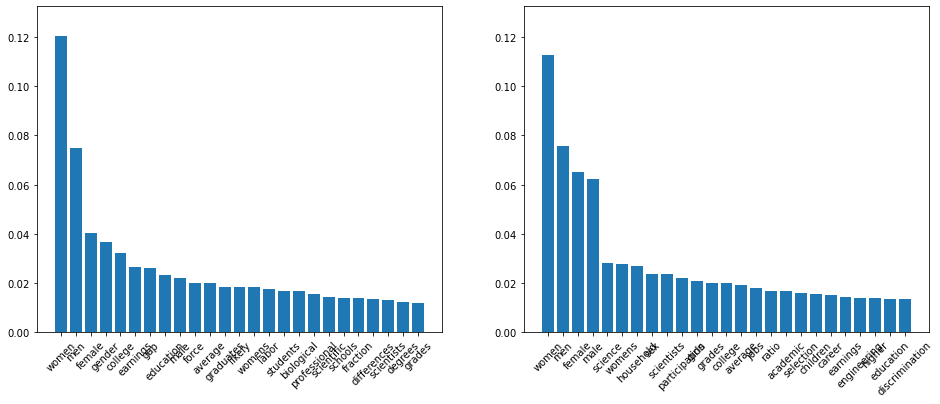

In [5]:
topic_num = 10
becker_topic = becker_model.get_topic(topic_num)
most_similar_topic = np.argmax(sim_matrix[topic_num + 1])-1
posner_topic = posner_model.get_topic(most_similar_topic)

f = plt.figure(figsize=(16, 6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

print(np.max(sim_matrix[topic_num + 1]))
df = pd.DataFrame(becker_topic, columns=['N-gram', 'Relevance'])
df2 = pd.DataFrame(posner_topic, columns=['N-gram', 'Relevance'])

y_max = max(max(df['Relevance']), max(df2['Relevance']))*1.1

ax.bar(df['N-gram'], df['Relevance'])
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim([0, y_max])

ax2.bar(df2['N-gram'], df2['Relevance'])
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_ylim([0, y_max])

## Topic search

Topic  16, similarity=0.647
Topic  -1, similarity=0.579
Topic  45, similarity=0.557
Topic  23, similarity=0.556
Topic  85, similarity=0.554


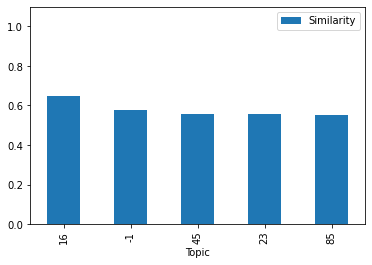

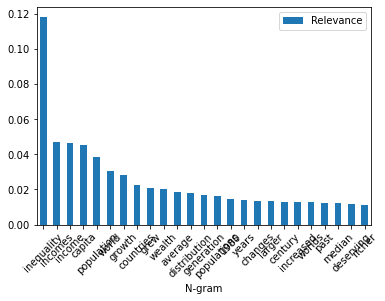

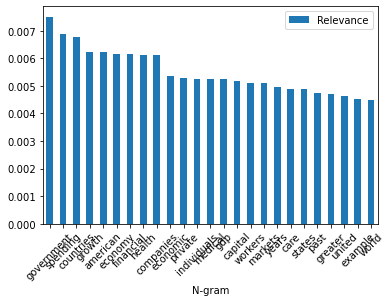

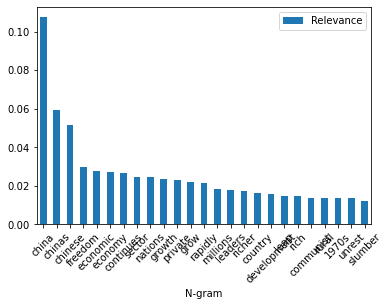

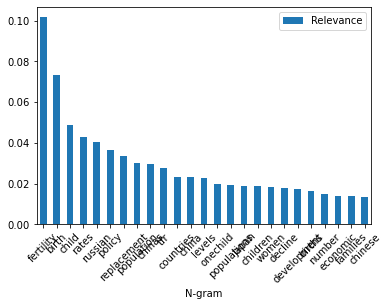

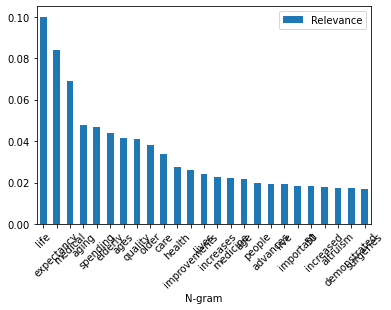

In [6]:
ids, probs = becker_model.find_topics('growth')
data = list(zip(ids, probs))
fig = pd.DataFrame(data, columns=['Topic', 'Similarity']).plot.bar(x=0, y=1)
fig.set_ylim([0, 1.1])
for id, prob in data:
    print(f'Topic {id:3}, similarity={prob:.3}')
    topic = becker_model.get_topic(id)
    df = pd.DataFrame(topic, columns=['N-gram', 'Relevance'])
    fig = df.plot.bar(x=0)
    fig.tick_params(axis='x', labelrotation=45)

## Vocabulary comparison (with cutoff)

In [53]:
# nltk.download('stopwords')

stopwords_en = stopwords.words('english')

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

processed_posner_sents = []
for sent in posner_sents:
    sent = re.sub(r"http\S+", "", sent).lower()
    sent = " ".join([word for word in re.sub("[^a-zA-Z0-9-\.]+", " ", sent).split() if word not in stopwords_en])
    processed_posner_sents.append(sent)
    
processed_becker_sents = []
for sent in becker_sents:
    sent = re.sub(r"http\S+", "", sent).lower()
    sent = " ".join([word for word in re.sub("[^a-zA-Z0-9-\.]+", " ", sent).split() if word not in stopwords_en])
    processed_becker_sents.append(sent)

posner_words = [tokenizer.tokenize(sent) for sent in tqdm(processed_posner_sents)]
becker_words = [tokenizer.tokenize(sent) for sent in tqdm(processed_becker_sents)]

words = posner_words + becker_words
dictionary = corpora.Dictionary(words)
bow = [dictionary.doc2bow(doc) for doc in words]
tfidf = models.TfidfModel(bow)

cutoff = 100

posner_doc_term_matrix = dictionary.doc2bow([word for sent in posner_words for word in sent])
becker_doc_term_matrix = dictionary.doc2bow([word for sent in becker_words for word in sent])
posner_sentences_tfidf = tfidf[posner_doc_term_matrix]
becker_sentences_tfidf = tfidf[becker_doc_term_matrix]
freq_posner = {dictionary.get(id): value for id, value in posner_sentences_tfidf}
freq_becker = {dictionary.get(id): value for id, value in becker_sentences_tfidf}
out_posner = sorted(freq_posner.items(), key=lambda x:x[1], reverse=True)
out_becker = sorted(freq_becker.items(), key=lambda x:x[1], reverse=True)

freq_posner = defaultdict(np.float64, freq_posner)
freq_becker = defaultdict(np.float64, freq_becker)

print('Posner words:', len(posner_doc_term_matrix))
print('Becker words:', len(becker_doc_term_matrix))

def index(a, x):
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueErro

all_diff = []
for word in dictionary.token2id.keys():
    id = dictionary.token2id[word]
    
    posner_count = bisect.bisect_left(posner_doc_term_matrix, id, key=lambda x: x[0])
    if posner_count != len(posner_doc_term_matrix) and posner_doc_term_matrix[posner_count][0] == id:
        posner_count = posner_doc_term_matrix[posner_count][1]
    else:
        posner_count = 0
    
    becker_count = bisect.bisect_left(becker_doc_term_matrix, id, key=lambda x: x[0])
    if becker_count != len(becker_doc_term_matrix) and becker_doc_term_matrix[becker_count][0] == id:
        becker_count = becker_doc_term_matrix[becker_count][1]
    else:
        becker_count = 0
    
    if any(char not in ' w.1234567890' for char in word) and posner_count + becker_count > cutoff:
        all_diff.append((freq_posner[word]/freq_becker[word], posner_count, becker_count, tokenizer.convert_tokens_to_string(word)))
print(f'Compared words, cutoff {cutoff}:', len(all_diff))
print(sorted(all_diff))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15249/15249 [00:01<00:00, 15026.98it/s]


Posner words: 16647
Becker words: 14070


TypeError: argument 'tokens': Can't extract `str` to `Vec`

## Hierarchical topics

In [8]:
mod = posner_model
corp = corpus_posner

linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = mod.hierarchical_topics(corp, linkage_function=linkage_function)
mod.visualize_hierarchy(hierarchical_topics=hierarchical_topics, orientation='left', custom_labels=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 38.64it/s]


## Topic matching

<AxesSubplot:>

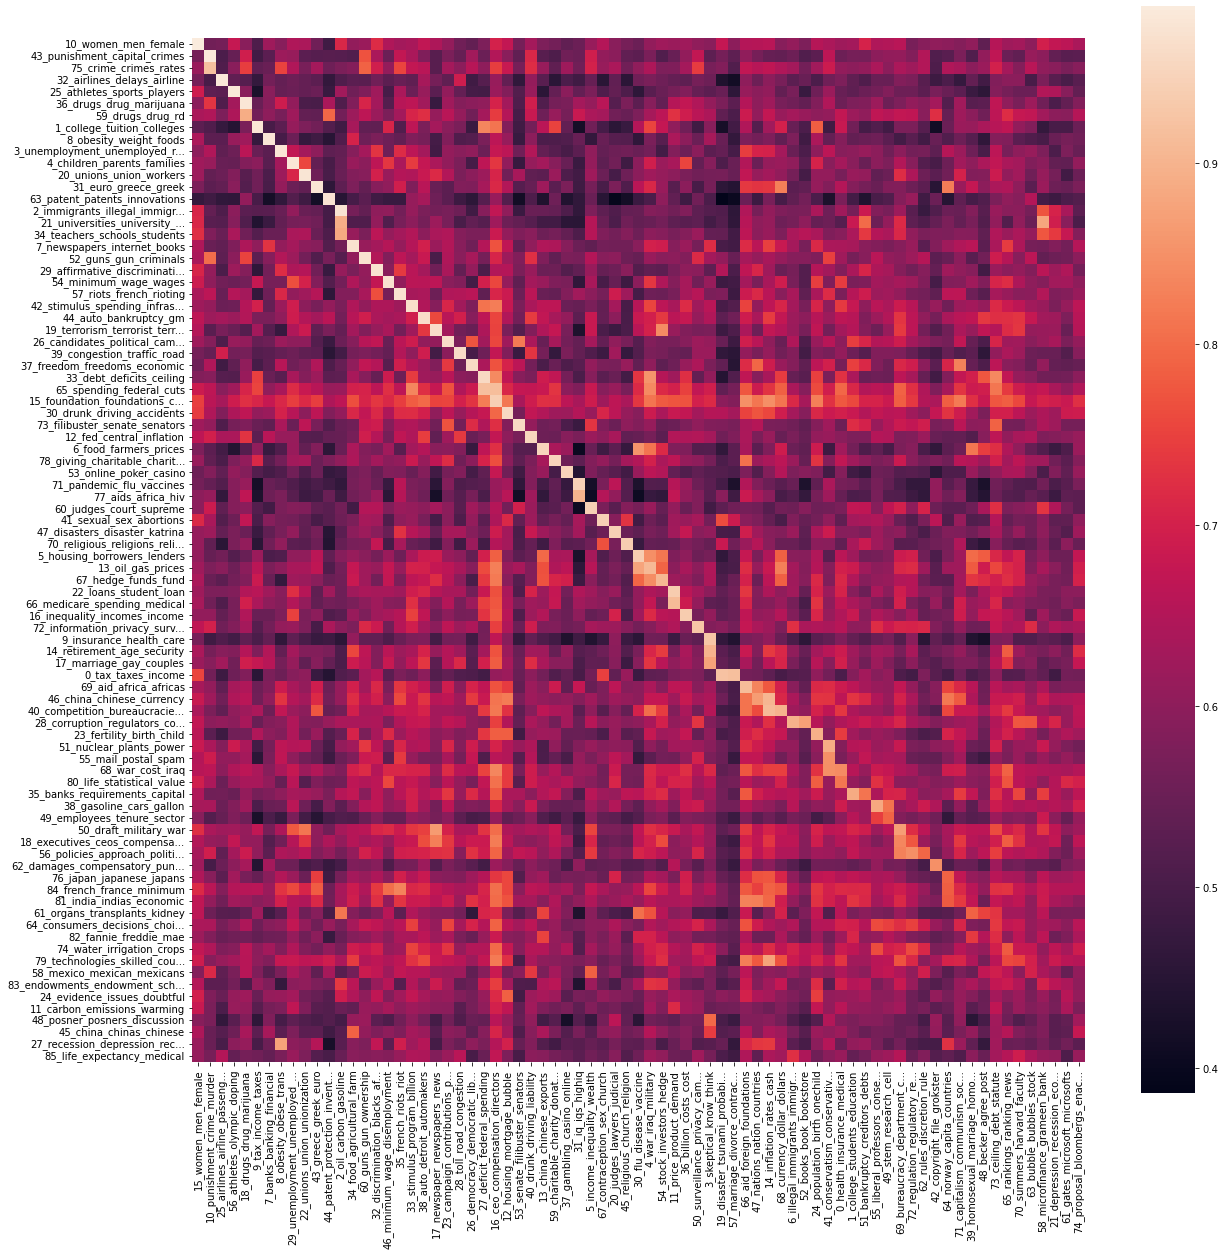

In [9]:
f = plt.figure(figsize=(20, 20))

sim_matrix2 = np.copy(sim_matrix)

becker_labels = [[[str(topic), None]] + becker_model.get_topic(topic) for topic in becker_tmp_topics]
becker_labels = ["_".join([label[0] for label in labels[:4]]) for labels in becker_labels]
becker_labels = [label if len(label) < 30 else label[:27] + "..." for label in becker_labels]

posner_labels = [[[str(topic), None]] + posner_model.get_topic(topic) for topic in posner_tmp_topics]
posner_labels = ["_".join([label[0] for label in labels[:4]]) for labels in posner_labels]
posner_labels = [label if len(label) < 30 else label[:27] + "..." for label in posner_labels]


factor = 0.9
c_h = c_l = 0
while c_h < len(becker_labels)-2 and c_l < len(posner_labels)-2:
    i, j = np.unravel_index(np.argmax(sim_matrix2[c_h:, c_l:], axis=None), sim_matrix2[c_h:, c_l:].shape)
    val = sim_matrix2[c_h+i, c_l+j]
    if c_l > c_h:
        sim_matrix2[:, [j+c_l, c_l]] = sim_matrix2[:, [c_l, j+c_l]]
        sim_matrix2[[i+c_h, c_h], :] = sim_matrix2[[c_h, i+c_h], :]
    else:
        sim_matrix2[[i+c_h, c_h], :] = sim_matrix2[[c_h, i+c_h], :]
        sim_matrix2[:, [j+c_l, c_l]] = sim_matrix2[:, [c_l, j+c_l]]
    posner_labels[c_l], posner_labels[c_l+j-1] = posner_labels[c_l+j-1], posner_labels[c_l]
    becker_labels[c_h], becker_labels[c_h+i-1] = becker_labels[c_h+i-1], becker_labels[c_h]
    while True:
        if not sim_matrix2[c_h+1:, c_l+1:].size:
            break
        next_val = np.max(sim_matrix2[c_h+1:, c_l+1:], axis=None)
        l_val = np.argmax(sim_matrix2[c_h, c_l+1:])
        c_val = np.argmax(sim_matrix2[c_h+1:, c_l])
        max_l = sim_matrix2[c_h, l_val + c_l + 1]
        max_c = sim_matrix2[c_val + c_h + 1, c_l]
        if max_l < next_val*factor and max_c < next_val*factor or c_h >= len(becker_labels)-1 or c_l >= len(posner_labels)-1:
            break
        if max_l > max_c:
            sim_matrix2[:, [l_val+c_l+1,c_l+1]] = sim_matrix2[:, [c_l+1, l_val+c_l+1]]
            posner_labels[c_l+1], posner_labels[c_l+l_val] = posner_labels[c_l+l_val], posner_labels[c_l+1]
            c_l += 1
        else:
            sim_matrix2[[c_val+c_h+1, c_h+1], :] = sim_matrix2[[c_h+1, c_val+c_h+1], :]
            becker_labels[c_h+1], becker_labels[c_h+c_val] = becker_labels[c_h+c_val], becker_labels[c_h+1]
            c_h += 1
    c_h += 1
    c_l += 1

sns.heatmap(sim_matrix2, square=True, ax=plt.subplot(111), xticklabels=posner_labels, yticklabels=becker_labels)

## Becker-Posner joint model topic evolution

In [22]:
TOKENIZERS_PARALLELISM=True

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=35, verbose=True,
                       n_gram_range=(1, 3), diversity=0.2, umap_model=umap_model, top_n_words=25)
topics, _ = topic_model.fit_transform(all_sents)
print(len(set(topics)))

Batches:   0%|          | 0/972 [00:00<?, ?it/s]

2023-09-30 19:35:06,412 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2023-09-30 19:35:27,243 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-30 19:35:28,792 - BERTopic - Clustered reduced embeddings
2023-09-30 19:35:37,958 - BERTopic - Reduced number of topics from 140 to 135


135


## Version 1 - From comparison with Becker, Nashat Becker 1996 and Becker, Posner 2009

In [14]:
topic_names = {
    -1: 'Trash',
    0: "health",
    1: "immigration and discrimination",
    2: "universities and schools",
    3: "energy and environment",
    4: "taxes and government",
    5: "rhetoric and conversation",
    6: "banking and financial crisis",
    7: "labor market",
    8: "society and consumers",
    9: "ideology, economic system",
    10: "crime",
    11: "international trade and affairs",
    12: "internet and technology",
    13: "legal issues",
    14: "war, military and terrorism",
    15: "sports",
    16: "family and marriage",
    17: "special interests and politics",
    18: "industrial organization and regulation",
}

reverse_topic_names = {v: k for k, v in topic_names.items()}

topic_merge = ["health", "universities and schools", "immigration and discrimination", "health", "rhetoric and conversation", "labor market", "banking and financial crisis", "taxes and government", "energy and environment", "banking and financial crisis", "immigration and discrimination", "taxes and government", "family and marriage", "energy and environment", "legal issues", "banking and financial crisis", "international trade and affairs", "special interests and politics", "energy and environment", "society and consumers", "labor market", "internet and technology", "labor market", "banking and financial crisis", "taxes and government", "industrial organization and regulation", "international trade and affairs", "ideology, economic system", "immigration and discrimination", "legal issues", "industrial organization and regulation", "energy and environment", "immigration and discrimination", "labor market", "taxes and government", "international trade and affairs", "family and marriage", "industrial organization and regulation", "industrial organization and regulation", "banking and financial crisis", "banking and financial crisis", "internet and technology", "energy and environment", "special interests and politics", "war, military and terrorism", "legal issues", "society and consumers", "ideology, economic system", "legal issues", "rhetoric and conversation", "universities and schools", "war, military and terrorism", "crime", "universities and schools", "health", "crime", "internet and technology", "taxes and government", "society and consumers", "war, military and terrorism", "family and marriage", "society and consumers", "special interests and politics", "family and marriage", "society and consumers", "internet and technology", "industrial organization and regulation", "universities and schools", "energy and environment", "taxes and government", "crime", "banking and financial crisis", "banking and financial crisis", "crime", "international trade and affairs", "legal issues", "special interests and politics", "international trade and affairs", "health", "rhetoric and conversation", "energy and environment", "labor market", "universities and schools", "banking and financial crisis", "banking and financial crisis", "family and marriage", "society and consumers", "taxes and government", "rhetoric and conversation", "ideology, economic system", "ideology, economic system", "rhetoric and conversation", "sports", "taxes and government", "society and consumers", "sports", "universities and schools", "international trade and affairs", "universities and schools", "Trash", "internet and technology", "legal issues", "universities and schools", "industrial organization and regulation", "energy and environment", "sports", "internet and technology", "war, military and terrorism", "internet and technology", "war, military and terrorism", "universities and schools", "banking and financial crisis", "health", "health", "society and consumers", "immigration and discrimination", "legal issues", "internet and technology", "legal issues", "society and consumers", "international trade and affairs", "war, military and terrorism", "internet and technology", "taxes and government", "taxes and government", "crime", "industrial organization and regulation", "industrial organization and regulation", "ideology, economic system", "universities and schools", "banking and financial crisis", "internet and technology", "industrial organization and regulation", "industrial organization and regulation"]

topic_merge = [reverse_topic_names[x] for x in topic_merge]

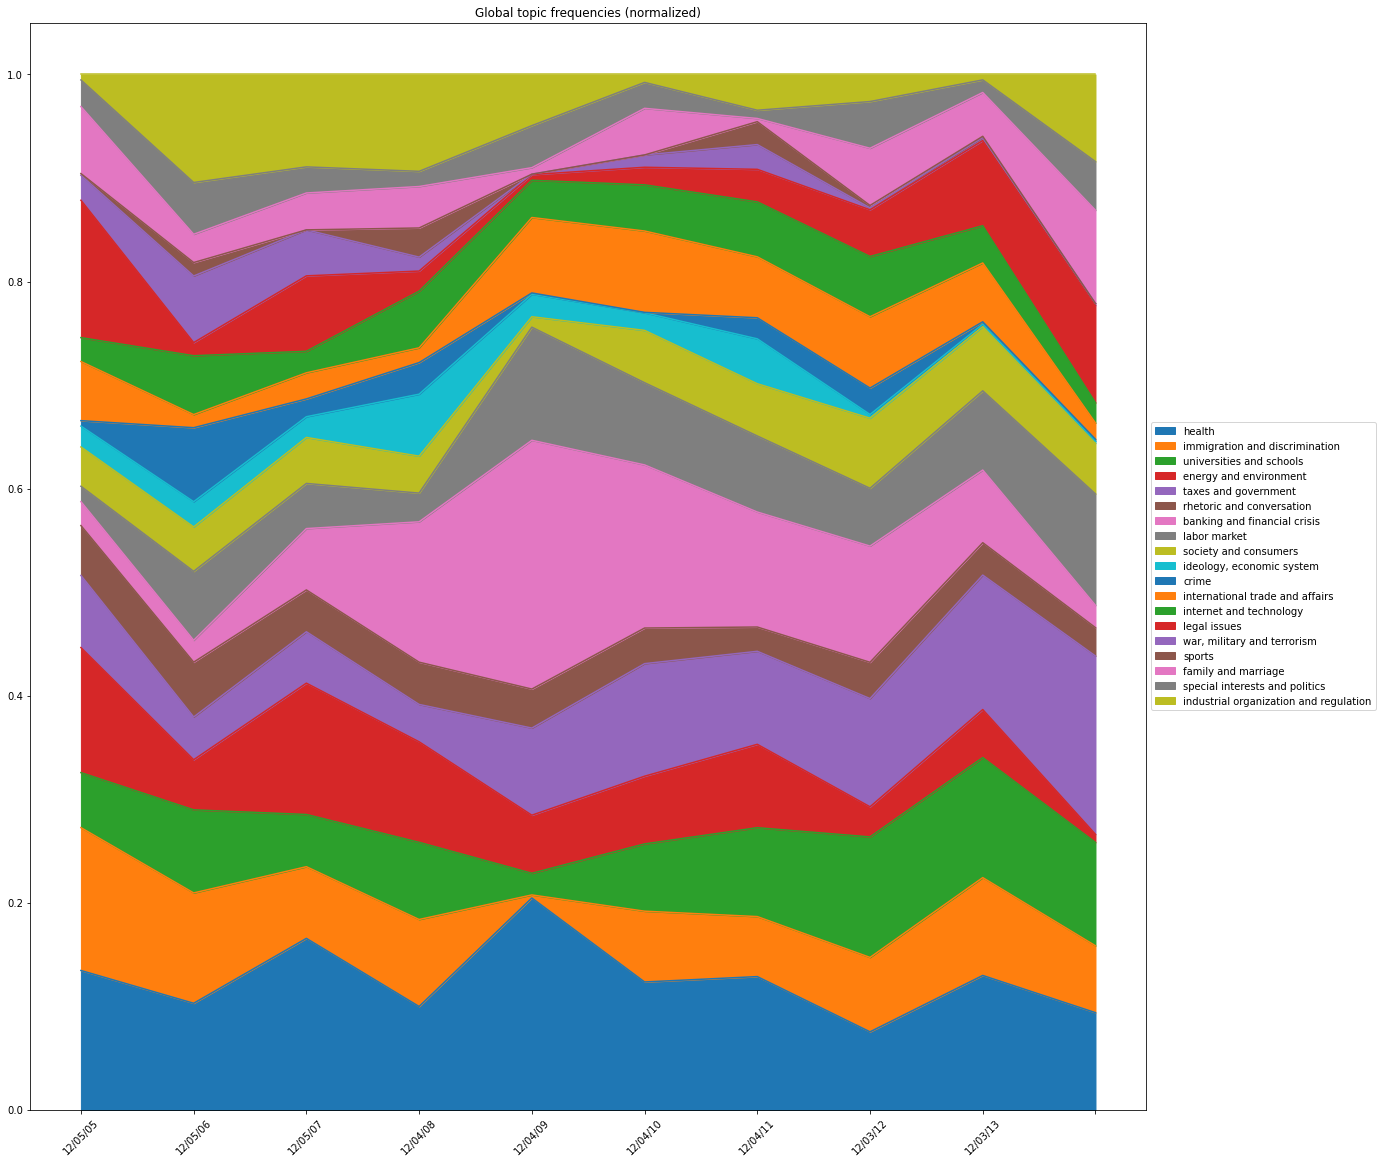

In [15]:
date_period = 365
normalize = True
last_date = all_sents_timestamps[0]
first_date = all_sents_timestamps[-1]

topic_count = len(topic_model.get_topic_info())

topic_rep = []

date_range = (last_date - first_date).days
date_xrange = []
cur_date = first_date
while cur_date <= last_date:
    date_xrange.append(cur_date.strftime("%m/%d/%y"))
    cur_date += datetime.timedelta(days=date_period)

for year in range(date_range // date_period + 1):
    topic_rep.append([0] * len(topic_names))
    
for i, doc in enumerate(topic_model.topics_):
    date = all_sents_timestamps[i]
    delta = (date - first_date).days
    if doc != -1:
        topic_rep[delta // date_period][topic_merge[doc]] += 1
    
topic_names_2 = sorted(topic_names.keys())
topic_names_2 = topic_names_2[1:] + [topic_names_2[0]]

df = pd.DataFrame(topic_rep, columns=[topic_names[x] for x in topic_names_2])
df = df.drop(columns=topic_names[-1])
if normalize:
    df = df.div(df.sum(axis=1), axis=0)
ax = df.plot.area(figsize=(20, 20))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(date_xrange, rotation=45)
ax.set_title('Global topic frequencies' + (' (normalized)' if normalize else ''))

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Version 2 - From topic hierarchy

In [16]:
topic_names = {
    -1: 'Trash',
    0: "financial crisis",
    1: "bankruptcy",
    2: "banking",
    3: "fiscal debt",
    4: "energy and food prices",
    5: "cost-benefit regulation",
    6: "labor market power",
    7: "economic depression",
    8: "taxes",
    9: "status, position",
    10: "nations and population",
    11: "foreign aid, africa",
    12: "crime, punishment",
    13: "terrorism, profiling, airlines",
    14: "charities, foundations",
    15: "miscellaneous, regulation cases",
    16: "regulators and rules",
    17: "legal system",
    18: "traffic, accidents",
    19: "patent, property",
    20: "digitalisation",
    21: "internet, tech, news",
    22: "technology",
    23: "war, military",
    24: "religion, contraception",
    25: "ideology",
    26: "politics, democracy",
    27: "conversational aspects",
    28: "marriage, gender discrimination",
    29: "professors, academia",
    30: "universities, college",
    31: "schools",
    32: "sports"
}

reverse_topic_names = {v: k for k, v in topic_names.items()}

topic_merge = ["cost-benefit regulation", "universities, college", "cost-benefit regulation", "cost-benefit regulation", "conversational aspects", "economic depression", "banking", "taxes", "energy and food prices", "financial crisis", "marriage, gender discrimination", "cost-benefit regulation", "status, position", "energy and food prices", "cost-benefit regulation", "economic depression", "nations and population", "politics, democracy", "energy and food prices", "status, position", "labor market power", "internet, tech, news", "financial crisis", "banking", "fiscal debt", "terrorism, profiling, airlines", "fiscal debt", "politics, democracy", "politics, democracy", "legal system", "traffic, accidents", "cost-benefit regulation", "politics, democracy", "labor market power", "economic depression", "nations and population", "marriage, gender discrimination", "bankruptcy", "traffic, accidents", "bankruptcy", "banking", "digitalisation", "energy and food prices", "politics, democracy", "war, military", "legal system", "religion, contraception", "ideology", "patent, property", "conversational aspects", "professors, academia", "terrorism, profiling, airlines", "crime, punishment", "schools", "miscellaneous, regulation cases", "legal system", "digitalisation", "legal system", "cost-benefit regulation", "war, military", "marriage, gender discrimination", "nations and population", "charities, foundations", "religion, contraception", "status, position", "internet, tech, news", "miscellaneous, regulation cases", "schools", "miscellaneous, regulation cases", "miscellaneous, regulation cases", "crime, punishment", "miscellaneous, regulation cases", "financial crisis", "crime, punishment", "energy and food prices", "patent, property", "charities, foundations", "fiscal debt", "foreign aid, africa", "cost-benefit regulation", "miscellaneous, regulation cases", "labor market power", "universities, college", "financial crisis", "fiscal debt", "marriage, gender discrimination", "nations and population", "taxes", "conversational aspects", "ideology", "professors, academia", "conversational aspects", "sports", "nations and population", "status, position", "sports", "schools", "foreign aid, africa", "universities, college", "miscellaneous, regulation cases", "digitalisation", "legal system", "professors, academia", "miscellaneous, regulation cases", "energy and food prices", "sports", "internet, tech, news", "miscellaneous, regulation cases", "internet, tech, news", "terrorism, profiling, airlines", "schools", "financial crisis", "miscellaneous, regulation cases", "miscellaneous, regulation cases", "status, position", "terrorism, profiling, airlines", "patent, property", "miscellaneous, regulation cases", "regulators and rules", "miscellaneous, regulation cases", "foreign aid, africa", "terrorism, profiling, airlines", "technology", "taxes", "regulators and rules", "legal system", "miscellaneous, regulation cases", "ideology", "miscellaneous, regulation cases", "universities, college", "miscellaneous, regulation cases", "technology", "miscellaneous, regulation cases", "miscellaneous, regulation cases"]

topic_merge = [reverse_topic_names[x] for x in topic_merge]

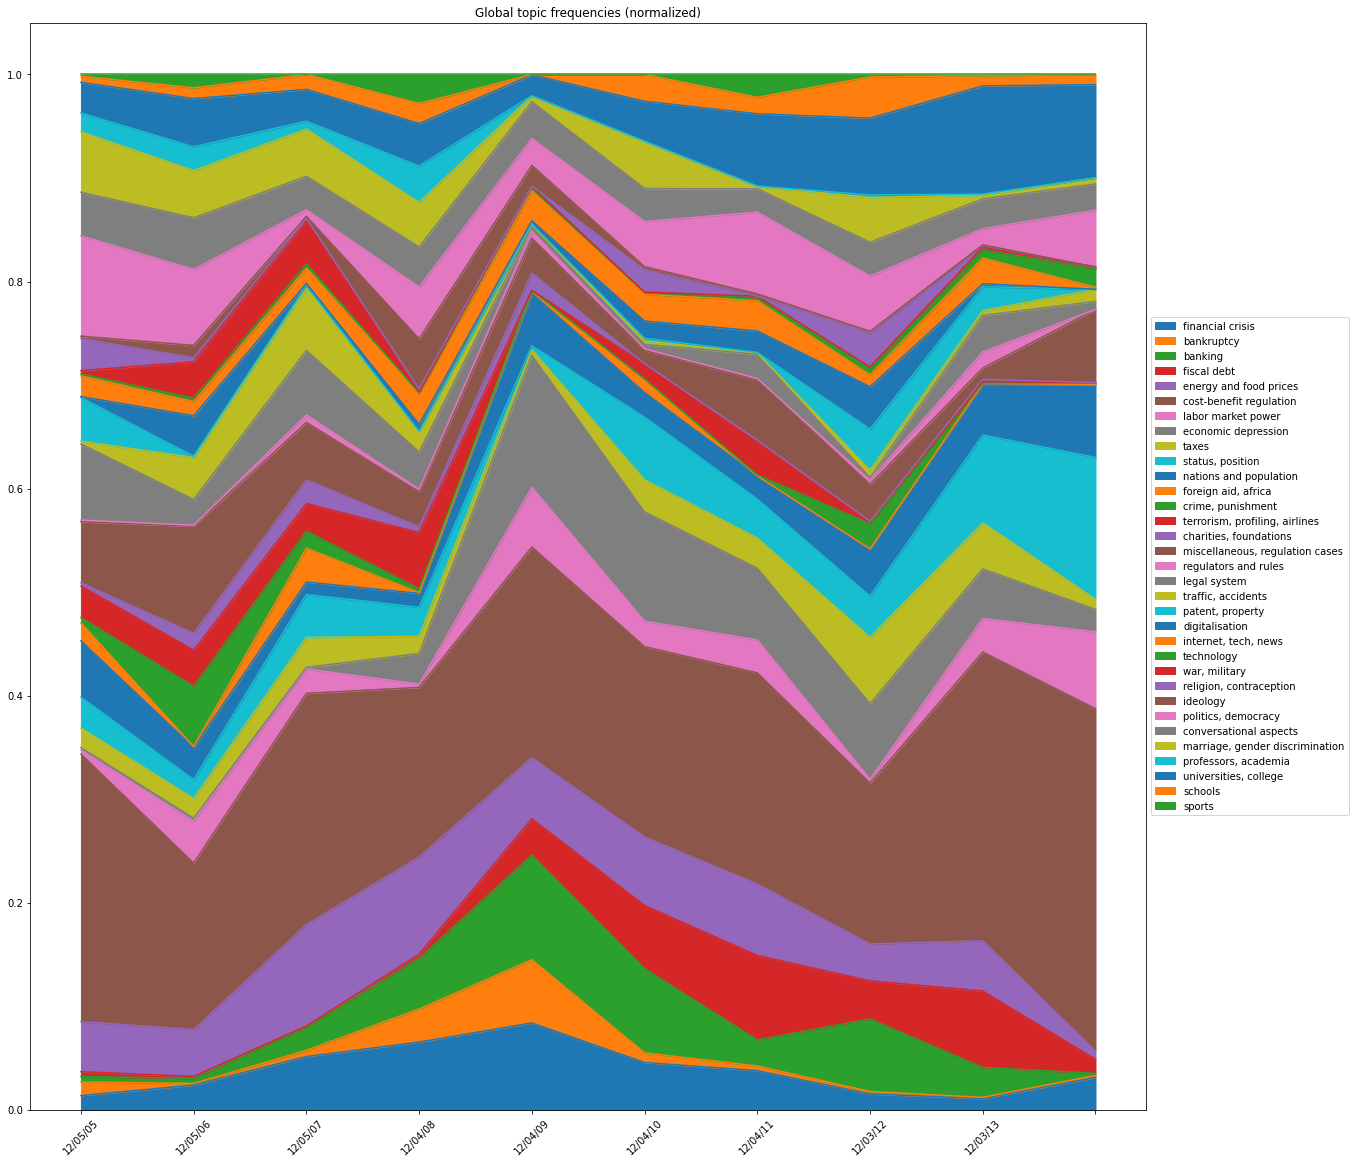

In [19]:
date_period = 365
normalize = True
last_date = all_sents_timestamps[0]
first_date = all_sents_timestamps[-1]

topic_count = len(topic_model.get_topic_info())

topic_rep = []

date_range = (last_date - first_date).days
date_xrange = []
cur_date = first_date
while cur_date <= last_date:
    date_xrange.append(cur_date.strftime("%m/%d/%y"))
    cur_date += datetime.timedelta(days=date_period)

for year in range(date_range // date_period + 1):
    topic_rep.append([0] * len(topic_names))
    
for i, doc in enumerate(topic_model.topics_):
    date = all_sents_timestamps[i]
    delta = (date - first_date).days
    if doc != -1:
        topic_rep[delta // date_period][topic_merge[doc]] += 1
    
topic_names_2 = sorted(topic_names.keys())
topic_names_2 = topic_names_2[1:] + [topic_names_2[0]]

df = pd.DataFrame(topic_rep, columns=[topic_names[x] for x in topic_names_2])
df = df.drop(columns=topic_names[-1])
if normalize:
    df = df.div(df.sum(axis=1), axis=0)
ax = df.plot.area(figsize=(20, 20))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(date_xrange, rotation=45)
ax.set_title('Global topic frequencies' + (' (normalized)' if normalize else ''))

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Posner-Becker individual model topic evolution

In [22]:
topic_names = {
    -1: 'Trash',
    0: "family, fertility, policy",
    1: "gender gap, student",
    2: "immigrants",
    3: "recession, wage",
    4: "lender, borrower",
    5: "energy, food, prices",
    6: "internet, digitalization",
    7: "choices, posner, political regulation",
    8: "health insurance life provision",
    9: "financial market regulation",
    10: "foundations, universities",
    11: "marriage, sex, religion",
    12: "labor market",
    13: "group action, discrimination, terrorism",
    14: "traffic, liability, cost",
    15: "public spending",
    16: "travel, postal, service",
    17: "legal and illegal drugs",
    18: "development policy",
    19: "crime, punishment, guns",
    20: "china",
    21: "desaster, loss nuclear",
    22: "military, war",
    23: "legal organization"
}

topic_names_2 = {
    -1: 'Trash',
    0: "obesity, health, inequality, revenue",
    1: "gender gap, students, iq",
    2: "energy, food, prices, traffic",
    3: "Becker, policy, liability, diverse",
    4: "cost-benefit, disaster",
    5: "banking",
    6: "housing bubble",
    7: "nations, populations",
    8: "finance, tech, business",
    9: "digitalization",
    10: "legal regulation",
    11: "depression and labor market",
    12: "freedom, group action",
    13: "marriage",
    14: "political intellectuals",
    15: "currency, donations",
    16: "contraception, church",
    17: "legislative, bankruptcy, microfinance"
}

reverse_topic_names = {v: k for k, v in topic_names.items()}
reverse_topic_names_2 = {v: k for k, v in topic_names_2.items()}

becker_topic_merge = ["family, fertility, policy", "gender gap, student", "immigrants", "recession, wage", "family, fertility, policy", "lender, borrower", "energy, food, prices", "internet, digitalization", "choices, posner, political regulation", "health insurance life provision", "gender gap, student", "energy, food, prices", "financial market regulation", "energy, food, prices", "health insurance life provision", "foundations, universities", "family, fertility, policy", "marriage, sex, religion", "labor market", "group action, discrimination, terrorism", "labor market", "foundations, universities", "lender, borrower", "family, fertility, policy", "choices, posner, political regulation", "foundations, universities", "choices, posner, political regulation", "recession, wage", "choices, posner, political regulation", "group action, discrimination, terrorism", "traffic, liability, cost", "public spending", "travel, postal, service", "public spending", "gender gap, student", "financial market regulation", "legal and illegal drugs", "development policy", "traffic, liability, cost", "traffic, liability, cost", "labor market", "marriage, sex, religion", "public spending", "crime, punishment, guns", "labor market", "china", "china", "desaster, loss nuclear", "choices, posner, political regulation", "labor market", "military, war", "desaster, loss nuclear", "crime, punishment, guns", "internet, digitalization", "recession, wage", "travel, postal, service", "choices, posner, political regulation", "group action, discrimination, terrorism", "immigrants", "legal and illegal drugs", "legal organization", "legal organization", "legal organization", "legal organization", "choices, posner, political regulation", "public spending", "health insurance life provision", "financial market regulation", "military, war", "development policy", "marriage, sex, religion", "legal organization", "choices, posner, political regulation", "legal organization", "legal organization", "crime, punishment, guns", "desaster, loss nuclear", "development policy", "foundations, universities", "energy, food, prices", "health insurance life provision", "development policy", "lender, borrower", "foundations, universities", "recession, wage", "health insurance life provision"]
posner_topic_merge = ["obesity, health, inequality, revenue", "gender gap, students, iq", "energy, food, prices, traffic", "Becker, policy, liability, diverse", "cost-benefit, disaster", "obesity, health, inequality, revenue", "cost-benefit, disaster", "banking", "obesity, health, inequality, revenue", "obesity, health, inequality, revenue", "cost-benefit, disaster", "energy, food, prices, traffic", "housing bubble", "nations, populations", "banking", "gender gap, students, iq", "finance, tech, business", "digitalization", "cost-benefit, disaster", "cost-benefit, disaster", "legal regulation", "depression and labor market", "depression and labor market", "digitalization", "nations, populations", "energy, food, prices, traffic", "freedom, group action", "obesity, health, inequality, revenue", "energy, food, prices, traffic", "depression and labor market", "cost-benefit, disaster", "gender gap, students, iq", "freedom, group action", "depression and labor market", "energy, food, prices, traffic", "freedom, group action", "cost-benefit, disaster", "digitalization", "depression and labor market", "marriage", "Becker, policy, liability, diverse", "political intellectuals", "legal regulation", "currency, donations", "legal regulation", "contraception, church", "depression and labor market", "nations, populations", "Becker, policy, liability, diverse", "Becker, policy, liability, diverse", "legal regulation", "legislative, bankruptcy, microfinance", "digitalization", "legislative, bankruptcy, microfinance", "finance, tech, business", "political intellectuals", "Becker, policy, liability, diverse", "marriage", "legislative, bankruptcy, microfinance", "currency, donations", "Becker, policy, liability, diverse", "finance, tech, business", "legal regulation", "housing bubble", "nations, populations", "Becker, policy, liability, diverse", "currency, donations", "contraception, church", "currency, donations", "legal regulation", "political intellectuals", "freedom, group action", "legal regulation", "legislative, bankruptcy, microfinance", "Becker, policy, liability, diverse"]

becker_topic_merge = [reverse_topic_names[x] for x in becker_topic_merge]
posner_topic_merge = [reverse_topic_names_2[x] for x in posner_topic_merge]

In [ ]:
for row in freq_df_becker.iterrows():
    topic = becker_model.get_topic(row[0])
    try:
        print('---', row[0], row[1]['Count'], becker_topic_merge[row[0]].replace(' ', '_'), '\t', ', '.join([x[0] for x in topic]))
    except:
        pass

In [ ]:
for row in freq_df_posner.iterrows():
    topic = posner_model.get_topic(row[0])
    try:
        print('---', row[0], row[1]['Count'], posner_topic_merge[row[0]].replace(' ', '_'), '\t', ', '.join([x[0] for x in topic]))
    except:
        pass

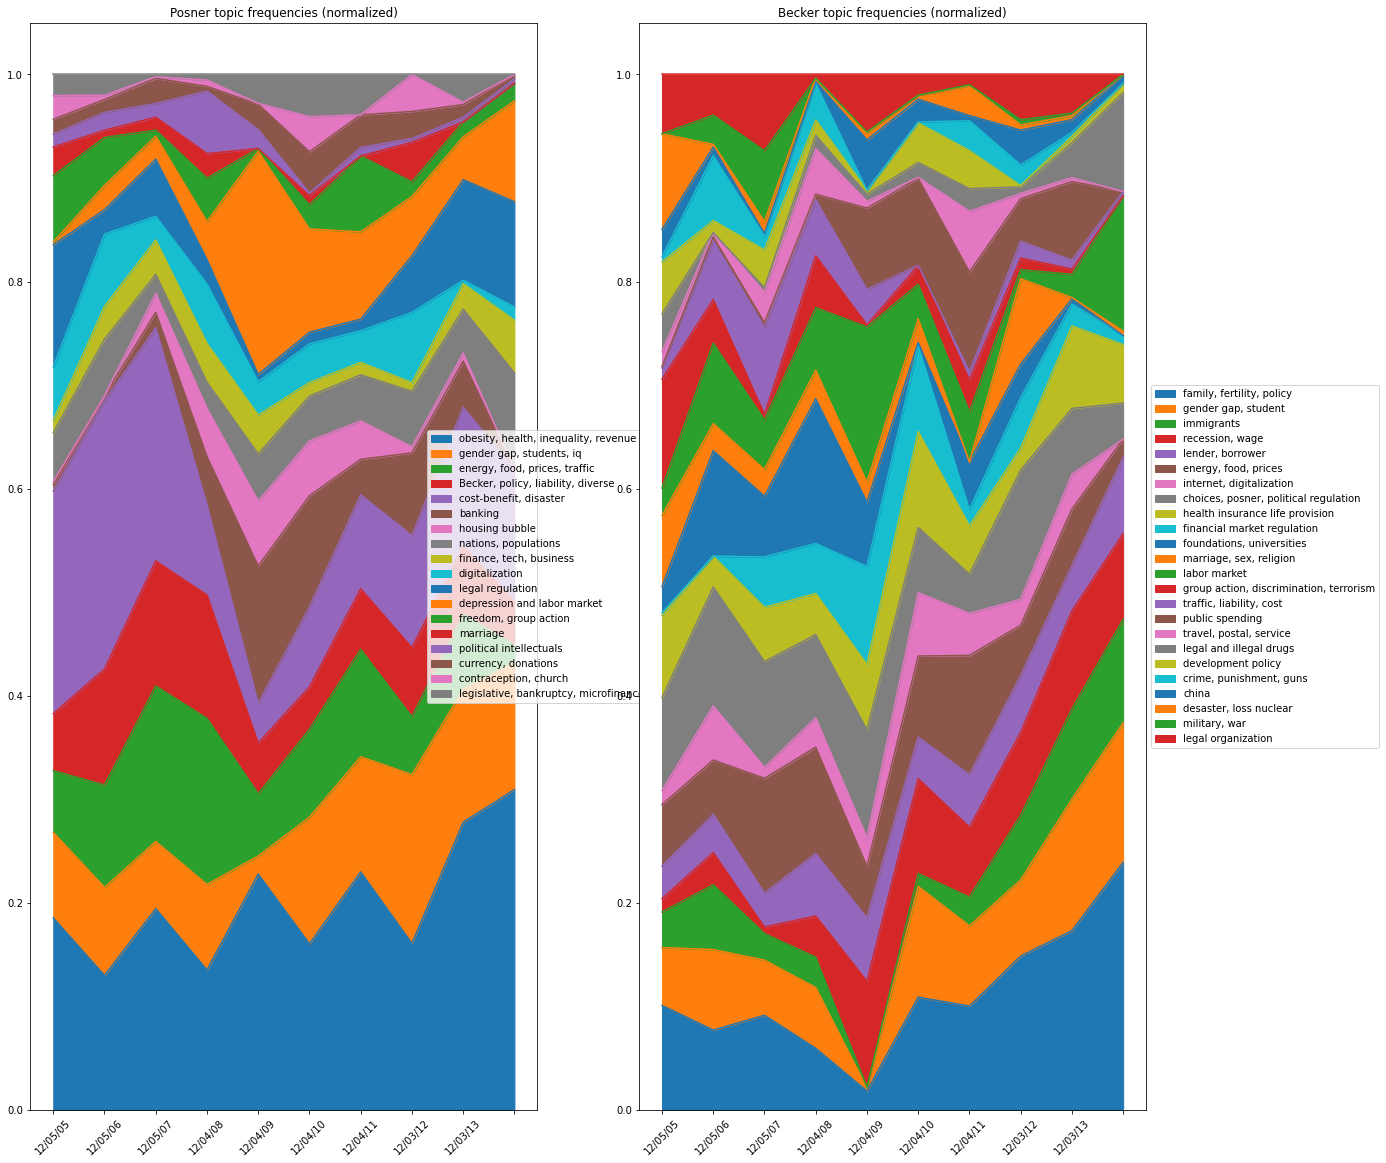

In [25]:
date_period = 365
normalize = True
last_date = all_sents_timestamps[0]
first_date = all_sents_timestamps[-1]

becker_topic_count = len(becker_model.get_topic_info())
posner_topic_count = len(posner_model.get_topic_info())

posner_topic_rep = []
becker_topic_rep = []

date_range = (last_date - first_date).days
date_xrange = []
cur_date = first_date
while cur_date <= last_date:
    date_xrange.append(cur_date.strftime("%m/%d/%y"))
    cur_date += datetime.timedelta(days=date_period)

for year in range(date_range // date_period + 1):
    posner_topic_rep.append([0] * len(topic_names_2))
    becker_topic_rep.append([0] * len(topic_names))
    
for i, doc in enumerate(posner_model.topics_):
    date = posner_sents_timestamps[i]
    delta = (date - first_date).days
    # In the slice at time t, we increment the topic number doc
    if doc != -1:
        posner_topic_rep[delta // date_period][posner_topic_merge[doc]] += 1
    
for i, doc in enumerate(becker_model.topics_):
    date = becker_sents_timestamps[i]
    delta = (date - first_date).days
    if doc != -1:
        becker_topic_rep[delta // date_period][becker_topic_merge[doc]] += 1
    
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

topic_names__2 = sorted(topic_names.keys())
topic_names__2 = topic_names__2[1:] + [topic_names__2[0]]

topic_names_2_2 = sorted(topic_names_2.keys())
topic_names_2_2 = topic_names_2_2[1:] + [topic_names_2_2[0]]

df = pd.DataFrame(posner_topic_rep, columns=[topic_names_2[x] for x in topic_names_2_2])
df = df.drop(columns=topic_names[-1])
if normalize:
    df = df.div(df.sum(axis=1), axis=0)
df.plot.area(ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(date_xrange, rotation=45)
ax.set_title('Posner topic frequencies' + (' (normalized)' if normalize else ''))

df2 = pd.DataFrame(becker_topic_rep, columns=[topic_names[x] for x in topic_names__2])
df2 = df2.drop(columns=topic_names[-1])
if normalize:
    df2 = df2.div(df2.sum(axis=1), axis=0)
df2.plot.area(ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xticklabels(date_xrange, rotation=45)
ax2.set_title('Becker topic frequencies' + (' (normalized)' if normalize else ''))

ax.get_legend().remove()
ax.legend(loc='center', bbox_to_anchor=(1.0, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Posner-Becker topics comparison per post

In [ ]:
post_ids = [24, 25]

f = plt.figure(figsize=(16, 6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
axes = [ax, ax2]
y_max = 0

for i, post_id in enumerate(post_ids):
    embeddings = np.array(topic_model.topic_embeddings_)
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    tmp_topics = sorted(freq_df.Topic.to_list())
    labels = [[[str(topic), None]] + topic_model.get_topic(topic) for topic in tmp_topics]
    labels = ["_".join([label[0] for label in labels[:4]]) for labels in labels]
    labels = [label if len(label) < 30 else label[:27] + "..." for label in labels]

    post = data[post_id]
    print('Title:', post['title'])
    print('Author:', post['author'])
    print()
    date = list(map(int, post['date'].split('/')))
    post_timestamp = datetime.datetime(date[2], date[0], date[1])

    left = len(all_sents_timestamps) - bisect.bisect_right(all_sents_timestamps[::-1], post_timestamp)
    right = len(all_sents_timestamps) - bisect.bisect_left(all_sents_timestamps[::-1], post_timestamp)
    
    prev = authors[left]
    for j, author in enumerate(authors[left+1:right]):
        if author != prev:
            if i % 2 == 0:
                right = left + j
            else:
                left = left + j + 1
            break

    ser = pd.Series(topic_model.topics_[left:right]).value_counts()
    try:
        ser = ser.drop(labels=[-1])
    except KeyError:
        pass
    ser.name = 'Frequency'
    ser_name = pd.Series([labels[x] for x in ser.index], name='Topic')
    ser.index = range(len(ser))
    y_max = max(y_max, max(ser))
    df = ser.to_frame().join(ser_name)
    axes[i].bar(df['Topic'], df['Frequency'])
    axes[i].tick_params(axis='x', labelrotation=90)

for axe in axes:
    axe.set_ylim(0, y_max*1.1)

## Posner-Becker vocabulary size

In [ ]:
posner_vocab = Counter()
for sent in posner_sents:
    for word in nltk.word_tokenize(sent):
        word = word.lower()
        if word not in STOP_WORDS and any(char not in ' .,();\'1234567890’-`' for char in word):
            posner_vocab[word.lower()] += 1
        
becker_vocab = Counter()
for sent in becker_sents:
    for word in nltk.word_tokenize(sent):
        word = word.lower()
        if word not in STOP_WORDS and any(char not in ' .,();\'1234567890’-`' for char in word):
            becker_vocab[word.lower()] += 1

print('Posner')
print('Vocab:', len(posner_vocab))
print('------')
pprint(posner_vocab.most_common()[:25])
print()

print('Becker')
print('Vocab:', len(becker_vocab))
print('------')
pprint(becker_vocab.most_common()[:25])

In [ ]:
posner_years = dict()
for i in range(2004, 2015):
    posner_years[i] = 0
for t in posner_sents_timestamps:
    posner_years[t.year] += 1
    
becker_years = dict()
for i in range(2004, 2015):
    becker_years[i] = 0
for t in becker_sents_timestamps:
    becker_years[t.year] += 1

In [ ]:
isents = [i for i, t in enumerate(posner_model.topics_) if t == 0]
cnt = dict()

for i in range(2004, 2015):
    cnt[i] = 0
for i in isents:
    cnt[posner_sents_timestamps[i].year] += 1
for k, v in cnt.items():
    cnt[k] /= posner_years[k] / 100

pd.DataFrame(cnt.values(), cnt.keys()).plot.bar()

In [ ]:
isents = [i for i, t in enumerate(becker_model.topics_) if t == 0]
cnt = dict()

for i in range(2004, 2015):
    cnt[i] = 0
for i in isents:
    cnt[becker_sents_timestamps[i].year] += 1
for k, v in cnt.items():
    cnt[k] /= becker_years[k] / 100

pd.DataFrame(cnt.values(), cnt.keys()).plot.bar()

## Semantic network analysis

In [122]:
import networkx as nx

posner_topics = len(posner_model.get_topic_info()) - 1
becker_topics = len(becker_model.get_topic_info()) - 1

topic_threshold = 0.7

G = nx.Graph()

for i in range(posner_topics):
    G.add_node(f'Posner_{i}', node_type='Posner')
    for word, weight in posner_model.get_topic(i):
        G.add_node(f'Word_{word}', node_type='Word')
        G.add_edge(f'Posner_{i}', f'Word_{word}', weight=weight)

        
for i in range(becker_topics):
    G.add_node(f'Becker_{i}', node_type='Becker')
    for word, weight in becker_model.get_topic(i):
        G.add_node(f'Word_{word}', node_type='Word')
        G.add_edge(f'Becker_{i}', f'Word_{word}', weight=weight)

for i in range(posner_topics + becker_topics):
    distance = []
    for j in range(posner_topics + becker_topics):
        if i == j:
            continue
        if i < posner_topics:
            t1 = posner_model.topic_embeddings_[i + 1]
            T1 = posner_model.get_topic(i)
            n1 = f'Posner_{i}'
        else:
            t1 = becker_model.topic_embeddings_[i - posner_topics + 1]
            T1 = becker_model.get_topic(i - posner_topics)
            n1 = f'Becker_{i - posner_topics}'

        if j < posner_topics:
            t2 = posner_model.topic_embeddings_[j + 1]
            T2 = posner_model.get_topic(j)
            n2 = f'Posner_{j}'
        else:
            t2 = becker_model.topic_embeddings_[j - posner_topics + 1]
            T2 = becker_model.get_topic(j - posner_topics)
            n2 = f'Becker_{j - posner_topics}'
            
        dist = 1 - scipy.spatial.distance.cosine(t1, t2)
        distance.append((dist, n2))
    distance.sort(reverse=True)
    for dist, n2 in distance[:10]:
        if dist > topic_threshold:
            G.add_edge(n1, n2, weight=(dist - topic_threshold)/(1 - topic_threshold))
print(G)

Graph with 2437 nodes and 4882 edges


In [121]:
nx.write_gml(G, 'graph.gml')

In [112]:
becker_model.transform(['Drugs are a problem for society'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-11-17 11:05:34,558 - BERTopic - Reduced dimensionality
2022-11-17 11:05:34,559 - BERTopic - Predicted clusters


([36], array([0.57308572]))

In [119]:
becker_model.transform(['Drugs are bad and drugs are good.'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [116]:
posner_model.transform(['Alcohol sales have increased.'])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-11-17 11:07:31,371 - BERTopic - Reduced dimensionality
2022-11-17 11:07:31,372 - BERTopic - Predicted clusters


([18], array([1.]))

In [26]:
import networkx as nx

posner_topics = len(posner_model.get_topic_info()) - 1
becker_topics = len(becker_model.get_topic_info()) - 1
n_topics = len(topic_model.get_topic_info()) - 1

topic_threshold = 0.7

G = nx.Graph()

for i in range(posner_topics):
    G.add_node(f'P_{i}', node_type='Posner')
    for word, weight in posner_model.get_topic(i):
        G.add_node(f'{word}', node_type='Word')
        G.add_edge(f'P_{i}', f'{word}', weight=weight)
        
for i in range(becker_topics):
    G.add_node(f'B_{i}', node_type='Becker')
    for word, weight in becker_model.get_topic(i):
        G.add_node(f'{word}', node_type='Word')
        G.add_edge(f'B_{i}', f'{word}', weight=weight)

for i in range(n_topics):
    G.add_node(f'F_{i}', node_type='Full')
    for word, weight in topic_model.get_topic(i):
        G.add_node(f'{word}', node_type='Word')
        G.add_edge(f'F_{i}', f'{word}', weight=weight)
        
for i in range(posner_topics + becker_topics + n_topics):
    distance = []
    for j in range(posner_topics + becker_topics + n_topics):
        if i == j:
            continue
        if i < posner_topics:
            t1 = posner_model.topic_embeddings_[i + 1]
            T1 = posner_model.get_topic(i)
            n1 = f'P_{i}'
        elif i < posner_topics + becker_topics:
            t1 = becker_model.topic_embeddings_[i - posner_topics + 1]
            T1 = becker_model.get_topic(i - posner_topics)
            n1 = f'B_{i - posner_topics}'
        else:
            t1 = topic_model.topic_embeddings_[i - posner_topics - becker_topics + 1]
            T1 = topic_model.get_topic(i - posner_topics - becker_topics)
            n1 = f'F_{i - posner_topics - becker_topics}'

        if j < posner_topics:
            t2 = posner_model.topic_embeddings_[j + 1]
            T2 = posner_model.get_topic(j)
            n2 = f'P_{j}'
        elif j < posner_topics + becker_topics:
            t2 = becker_model.topic_embeddings_[j - posner_topics + 1]
            T2 = becker_model.get_topic(j - posner_topics)
            n2 = f'B_{j - posner_topics}'
        else:
            t2 = topic_model.topic_embeddings_[j - posner_topics - becker_topics + 1]
            T2 = topic_model.get_topic(j - posner_topics - becker_topics)
            n2 = f'F_{j - posner_topics - becker_topics}'
            
        dist = 1 - scipy.spatial.distance.cosine(t1, t2)
        distance.append((dist, n2))
    distance.sort(reverse=True)
    for dist, n2 in distance[:10]:
        if dist > topic_threshold:
            G.add_edge(n1, n2, weight=(dist - topic_threshold)/(1 - topic_threshold))
print(G)

Graph with 3359 nodes and 9085 edges


In [27]:
nx.write_gml(G, 'trigraph.gml')

In [11]:
words = """health
insurance
medical
care
medicare
people
elderly
retirement
medicaid
physicians
longevity
premiums
security
benefits
costs
healthcare
old
insured
uninsured
pay
malpractice
patients
average
afford
insurers
college
students
education
colleges
schools
universities
tuition
school
student
university
forprofit
alumni
public
graduates
teachers
faculty
loans
children
teacher
benefit
attend
parents
institutions
donations
teaching
oil
carbon
gasoline
emissions
warming
global
dioxide
fuels
atmosphere
prices
tax
gas
fossil
energy
reduce
drilling
supply
taxes
burning
production
demand
ethanol
increase
dependence
greenhouse
skeptical
know
think
point
reasons
question
dont
incorrect
questions
doubt
study
preconceptions
analysis
thing
guess
arguments
conscious
information
brush
points
results
realistic
suggestion
expectation
exceptions
war
iraq
military
soldiers
vietnam
terrorism
attack
terrorist
personnel
terrorists
troops
casualties
armed
al
qaeda
forces
attacks
army
united
defense
threat
civilian
islamic
afghanistan
iran
income
inequality
wealth
happiness
mobility
incomes
poverty
rich
distribution
percent
welfare
poor
utility
wealthy
society
class
envy
social
median
family
states
redistribution
economic
households
illegal
immigrants
immigration
amnesty
mexico
citizenship
mexican
immigrant
border
citizens
foreigners
skilled
profiling
deported
future
americans
outsourcing
crime
lawful
born
jobs
deportation
workers
banks
banking
financial
bank
capital
lending
reserve
risk
regulation
fed
federal
lend
borrowing
loan
borrow
credit
regulatory
bankers
lax
nonbank
risks
lenders
assets
deregulation
obesity
obese
trans
fats
foods
restaurants
restaurant
food
drinks
fat
overweight
ban
weight
eating
soft
fatty
york
calorie
sodas
diet
exercise
ordinance
estate
revenues
revenue
rates
marginal
taxed
taxation
effect
loopholes
dividends
bequest
gains
effects
deductions
taxable
250000
taxpayers
excise
punishment
murder
criminal
crimes
sentence
prison
murderers
deterrence
execution
rate
executed
deter
imprisonment
police
deterrent
criminals
punished
innocent
committing
probability
punish
price
product
competition
cartel
cost
curve
monopoly
sellers
profits
customers
consumers
market
competitive
quality
producers
consumer
shortage
value
monopsony
products
housing
mortgage
bubble
mortgages
house
subprime
houses
bursting
securities
mortgagebacked
bought
risky
equity
refinance
debt
defaults
rising
foreclosures
freddie
china
chinese
exports
imports
chinas
foreign
domestic
goods
export
internet
companies
countries
domestically
imported
equipment
growth
employment
policy
inflation
cash
money
treasury
shortterm
longterm
bonds
low
reserves
economy
feds
excess
savings
women
men
female
male
science
womens
household
sex
scientists
participation
girls
grades
ratio
academic
selection
career
earnings
engineering
higher
discrimination
ceo
compensation
directors
ceos
shareholders
corporation
executives
management
organization
firms
shares
corporations
company
managers
employees
executive
options
owners
bonus
subordinates
hierarchy
boards
corporate
salary
newspaper
newspapers
news
media
advertising
spam
blogs
bloggers
print
ads
classified
web
blogging
content
mainstream
ethical
blogosphere
read
unbundling
sports
standards
magazines
mail
drugs
drug
marijuana
orphan
prohibition
legalization
enforcement
cocaine
legalizing
authors
alcohol
sale
producer
recreational
legalized
consumption
sales
heroin
legal
diseases
substitutes
billion
disaster
tsunami
catastrophe
ocean
response
warning
earthquake
orleans
katrina
hurricane
measures
tsunamis
disasters
emergency
asteroid
2004
expected
catastrophes
warnings
damage
flood
judges
lawyers
judicial
law
judge
judiciary
salaries
court
firm
justices
lawyer
appointed
courts
practice
hours
case
promotion
job
senior
counsel
client
depression
recession
gdp
depressions
1933
projects
recovery
ends
severe
2009
output
began
crisis
falling
euphemism
increasing
1930s
publicworks
2008
trend
reduced
antidepression
keynesian
unions
union
unionization
labor
employer
unionized
employers
bargaining
wages
sector
unionism
strike
wage
prounion
work
relations
collective
organizing
competitors
power
adversarial
campaign
contributions
political
lobbying
voting
voters
candidates
campaigns
election
elections
pac
congress
lobbyists
groups
pacs
expenditures
donors
527
abramoff
influence
population
birth
onechild
fertility
birthrate
russia
world
child
overpopulation
decline
demographic
births
japan
russian
transition
country
airlines
airline
passengers
flight
delay
flights
planes
delays
air
service
passenger
scheduled
canceled
plane
transportation
travelers
traffic
baggage
schedules
tarmac
fuel
carriers
congestion
delayed
democracy
democratic
liberty
authoritarian
dictatorship
regimes
freedom
hitler
dictator
liberties
government
nations
societies
collapse
ancient
soviet
communist
regime
dictatorships
rulers
selfconfident
deficit
spending
fiscal
budget
cuts
deficits
annual
trillion
increases
bush
reducing
raising
administration
toll
road
tolls
highway
lease
roads
commuting
commuters
indiana
interstate
maintenance
driving
telephone
drivers
state
highways
fees
london
externality
vehicle
unemployment
unemployed
looking
search
discouraged
underemployment
extension
extending
involuntarily
high
months
employed
longer
structural
skills
flu
disease
vaccine
virus
pandemic
infected
malaria
africa
aids
prevalence
hivaids
vaccines
epidemic
spraying
ddt
pandemics
condoms
avian
died
19181919
deaths
birds
iq
iqs
highiq
returns
genetic
intelligence
100
85
test
intellectual
persons
performance
factor
jews
educational
smart
childrens
complexity
innate
including
blacks
affirmative
black
white
indian
laws
whites
reservations
racial
situations
privileges
integration
category
ethnic
forbidding
antidiscrimination
beneficiaries
assimilation
occupational
disfavored
stimulus
program
package
enacted
president
industries
payments
areas
862
obama
agenda
clunkers
poorly
keyness
provisions
private
agricultural
farm
subsidies
agriculture
commodities
farmers
meat
foodstamp
farmer
acreage
grains
bread
rural
crops
french
riots
riot
france
race
rioters
rioting
looting
urban
1968
demonstrations
youth
propensity
action
king
likelihood
slums
demonstrators
muslims
sympathy
transfer
deadweight
costbenefit
figure
128
grand
estimated
total
assumption
real
328
themis
year
incurred
payment
costly
gambling
casino
online
prediction
casinos
bet
lotteries
odds
markets
gamble
betting
gamblers
addiction
poker
lottery
gambler
slot
iowa
deposit
bets
iem
auto
detroit
automakers
manufacturers
bailout
bankruptcy
industry
automobile
toyota
vehicles
cars
liquidation
liquidate
motors
republican
transplants
suppliers
car
parts
chrysler
homosexual
marriage
homosexuals
homosexuality
gay
marriages
heterosexual
couples
heterosexuals
sexual
civil
tolerance
marry
opposition
relationships
rights
recognized
partnerships
kinseys
samesex
registered
drunk
liability
driver
speed
tort
limit
injury
liable
accident
drive
victim
posted
accidents
rescue
injurers
breach
arrested
employee
reckless
ticket
conservatism
conservative
friedman
movement
milton
economists
buckley
conservatives
economics
clinton
nixon
hayek
william
abortion
friedrich
reagan
george
intellectuals
friedmans
economist
strong
liberal
copyright
file
grokster
copying
infringement
sharing
contributory
software
plagiarism
copyrighted
computer
writer
piracy
recordings
royalties
music
filesharing
author
film
copyrights
users
cd
copy
greece
greek
euro
currency
eurozone
european
greeces
euros
eu
devaluation
austerity
abandoning
defaulting
spain
bail
greeks
germans
domino
patent
protection
invention
patents
pharmaceutical
upfront
patented
inventor
patentee
license
years
patentees
inventions
innovation
infringing
research
investment
obtained
duplicate
religious
church
religion
commandments
churches
religiosity
secular
belief
establish
establishment
catholic
displays
observance
monument
europe
sect
sects
roman
amendment
hume
monotheism
minimum
disemployment
hour
725
minimumwage
nonpoor
40hour
2000
david
teenagers
nation
territorial
nationalism
large
barriers
inhabit
splitting
ethnographic
asian
scale
cultural
factors
asia
language
tiny
switzerland
britain
populations
becker
agree
post
comment
discusses
excellent
blogged
says
disagreements
drift
relates
optimistic
piece
distinct
pessimism
issue
discussion
agreement
broad
professor
written
foundation
responsibility
suggest
stem
cell
cells
organs
kidney
transplant
embryos
kidneys
vitro
fertilization
therapeutic
dialysis
organ
transplantation
embryo
purposes
oppose
researchers
clone
embryonic
donor
patient
abortions
surveillance
privacy
cameras
concealment
connotations
conspiracy
conceal
communications
facts
camera
transact
sidewalks
network
word
streets
strangers
cheating
marathon
discreditable
concealments
creditors
debts
chapter
debtor
bankrupt
declare
act
discharge
creditor
proceeding
condition
reorganized
owed
bankrupts
claims
cram
reform
debtors
reorganization
books
book
bookstore
amazon
bookstores
printed
electronic
ebook
publishers
kindle
reader
digital
seller
advantages
publisher
browsing
published
delivery
access
senate
filibuster
senators
majority
vote
filibusters
cloture
elected
legislation
votes
filibustering
supermajority
senator
concessions
constitution
filibusterproof
partys
rules
twothirds
representatives
debate
legislatures
stock
investors
hedge
speculators
stocks
trading
funds
speculative
asset
analysts
speculation
theory
fund
peak
finance
frank
professors
left
skew
humanities
liberals
1960s
faculties
extreme
journalists
sciences
antisemitism
grosssimmons
liberalarts
liberalism
radicals
spectrum
athletes
olympic
doping
training
athletic
steroids
games
teams
baseball
fans
olympics
team
players
banning
linemen
leagues
football
athlete
400pound
heavily
divorce
contractual
wife
relationship
cohabitation
husband
nofault
separation
married
wives
marital
cohabitations
alimony
marrying
dissolved
end
commitment
parties
unmarried
dissolution
microfinance
grameen
bangladesh
microlending
microcredit
yunus
microfinanciers
commercial
borrowers
clan
india
microloans
fringe
borrower
million
willing
model
andhra
charitable
charity
deduction
giving
shareholder
charities
10
exemption
credits
gifts
reduction
gives
donation
contribution
efficiency
expenses
guns
gun
ownership
lawabiding
hunting
possession
selfdefense
constitutional
commit
prelude
gunregistration
lunatics
coup
weapon
gates
microsoft
microsofts
gatess
business
netscape
successful
windows
fortunes
recognition
established
type
speech
wealthiest
businesses
apple
reputation
startup
buffet
rapidity
discretion
rule
circumstances
standard
rulemaker
judgemade
guidelines
sentencing
clarity
guidance
definite
enforced
choice
antitrust
allow
bubbles
irrational
behavior
table
herd
thinking
rational
linkedin
squared
phenomenon
speculator
profit
assetprice
arises
expanding
explained
norway
capita
percentage
denmark
sweden
finland
netherlands
parity
canada
portugal
scandinavian
ranked
germany
singapore
middle
rankings
ranking
ranks
rank
composite
weighting
reports
final
multifactor
influential
counselors
sat
scorecard
criticized
systems
annually
aid
foundations
assistance
abroad
overseas
aggregate
corrupt
tariff
redirectednot
predicament
recipientsto
policies
corruption
reliance
squandered
contraception
priests
doctrine
nonmarital
procreative
papal
nuns
pope
churchs
christianity
catholics
abstinence
facilitates
undermine
venereal
rhythm
prostitutes
masturbation
dollar
dollars
international
currencies
transactions
merchants
trade
devalue
buy
penny
surpluses
accumulated
status
worlds
major
bureaucracy
department
bureaucracies
officials
agency
provider
supervise
procurement
agencies
bureaucratic
needs
consultant
technical
governmental
contracts
highlevel
contacts
formal
secretary
chief
goals
summers
harvard
apology
member
resignation
campus
remarks
summerss
controversy
inferior
apologized
abject
huff
communiststyle
conanthas
denounces
robinson
fourlegged
reeducation
denunciator
alston
capitalism
communism
socialism
capitalist
socialist
boom
labour
bismarck
versus
ideologies
hayeks
economies
century
logic
modern
twentieth
rationale
radical
regulated
regulations
regulators
instruments
abler
free
restrictions
externalities
safety
tendency
hire
methods
layer
hacks
constraining
unconstrained
capturethe
irksome
industryis
ceiling
statute
repeal
legislative
raise
threatening
lever
passed
improper
prevents
congresss
refusal
signed
proposal
bloombergs
ought
implemented
operate
step
proposals
attention
intervention
concerns
significance
ails
proposalan
announcements
proposed
congressman
getter
repeatedly
container
nonenforcement
misconceived
agitation
flat
code
estates
evasion
compliance
investments
increased
graduate
dropouts
better
1980
immigrate
residents
illegally
legally
number
stay
approach
aliens
came
apprehended
undocumented
recessions
weeks
target
remain
hires
families
parental
intergenerational
degree
poorer
childcare
generation
intergeneration
programs
progresa
invest
educated
abilities
ige
homes
homeowners
foreclosure
prime
districts
corn
wheat
land
biofuels
controls
rise
google
ereaders
facebook
television
papers
twitter
censorship
readers
beverages
sedentary
consequences
adults
gain
eat
activities
sugar
coverage
plans
catastrophic
mandate
mandates
provide
employerbased
deductible
american
gender
gap
force
likely
biological
professional
scientific
fraction
differences
degrees
pollution
gases
climate
emission
environmental
offsets
co2
var
pollutants
technologies
solar
quota
coal
central
independence
easing
oversight
operations
chairman
pressure
barrel
offshore
fracking
shale
moratorium
elasticity
strategic
age
ages
older
retire
65
retirees
younger
70
accounts
expectancy
generous
disability
retirements
retired
buffett
views
institute
prize
issues
warren
packard
admired
party
grew
changes
larger
past
deserving
richer
gays
polygamy
husbands
sperm
divorced
stockholders
bonuses
stockholder
control
risktaking
bombers
moslem
males
suicide
moslems
airport
members
missions
911
airports
checks
organizations
apprehension
abadie
profiled
nonunion
membership
shift
tenure
academics
presidents
trustees
columbia
positions
fields
interests
posner
incomecontingent
repayment
earn
collateral
repay
expect
subsidized
repayments
forprofits
replacement
tfr
levels
development
evidence
doubtful
examples
conclusions
following
briefly
opposite
answers
yes
conclusion
comments
report
defects
studies
discuss
believe
conclusive
statements
crucial
basketball
ncaa
enhancers
medals
scholarships
banned
bans
competitions
winter
outcomes
influencing
informed
support
politics
incumbents
campaigning
deep
severity
uncertainty
fall
mild
businessmen
discretionary
regulating
dishonest
captured
morally
scandals
practices
minority
minorities
african
discriminating
south
neighborhood
applicants
suffered
segregated
admission
africanamericans
patrons
bars
bar
drinking
drinkers
drink
punishments
fatalities
organizers
emu
shocks
sovereign
drachma
italy
exchange
imf
flexible
weak
adjustments
seats
travel
southwest
services
meals
flying
flyers
bags
occupancy
burden
balanced
level
debtgdp
balance
held
rapid
scores
charter
tests
merit
vouchers
evaluations
standardized
administrators
pisa
math
requirements
goldman
lehman
fail
jpmorgan
brothers
morgan
ratios
leveraged
decriminalization
addictions
decriminalizing
addicts
clinics
underground
lords
trafficking
experimentation
freedoms
democracies
taiwan
korea
autocratic
leaders
chile
autocracies
totalitarian
governments
vibrant
prosperity
gallon
cents
fuelefficient
miles
suvs
local
cut
city
rush
congested
cities
times
skyway
pricing
heavy
day
morning
vary
monopolies
compete
enterprise
privatized
dynamic
static
contraceptives
premarital
intercourse
sexselected
contraceptive
fetuses
doctrines
acog
boys
teachings
unwanted
revolution
infrastructure
packages
800
advisers
plan
incoming
stimulate
bernstein
reinvestment
spent
jared
murders
murderer
victims
deters
lives
convicted
assaults
gm
ford
autoworkers
proceedings
pension
carmakers
warranties
continues
grow
rapidly
millions
leap
1970s
unrest
slumber
renminbi
appreciate
yuan
bills
little
paper
earthquakes
property
vulnerable
losses
disasterprone
events
highrisk
posners
fine
referred
follow
good
try
calls
emphasized
topic
criticisms
interesting
paul
turnover
heads
deferred
homeland
rentseeking
quits
firmspecific
severance
facto
leave
draft
voluntary
volunteers
young
protests
drafted
serving
volunteered
patriotism
1973
draftees
patriotic
enlistments
wars
peacetime
nuclear
plants
waste
radiation
reactors
electricity
release
uranium
radioactive
generate
plutonium
recycling
disposal
bombs
weapons
purchases
hands
violence
knives
lethal
play
licenses
site
vegas
blackjack
game
chips
indians
gambles
minimums
significantly
fast
lower
claim
postal
usps
email
closing
mailboxes
office
ex
recipients
offices
spamming
saturday
ups
boxes
deliver
harm
deliveries
trucks
closed
feasible
approaches
constraints
solutions
complacent
direction
right
governance
interventions
countrys
beneficial
improve
implement
advance
muslim
suburbs
youths
participate
dropped
communities
communication
marseilles
mexicans
mexicos
net
nafta
guatemala
reforms
clip
partner
recovers
rd
generics
new
clinical
biotech
fda
trials
producing
developed
blockbuster
molecular
clomid
cialis
supreme
lifetime
pensions
bench
carrington
decisions
justice
incompetent
limits
serve
waiting
allowing
liver
livers
live
queue
wait
opt
need
altruism
relatives
die
damages
compensatory
punitive
litigation
cases
defendants
doctors
jurisdictions
plaintiffs
bias
coffee
lawsuits
jackpot
litigated
buyer
avoided
fair
macdonalds
innovations
patentable
intermediaries
holders
eliminating
temporary
discoveries
trolls
trolling
patenting
timeconsuming
unproductive
creators
choices
ignorance
tastes
ignorant
mistakes
fooled
preferences
rely
underestimates
judgments
reputations
supermarkets
selfinterest
overall
mandated
term
2021
bushs
presidency
2013
entitlement
entitlements
2020
seniors
privatize
rationing
overconfidence
auction
luck
overpay
arbitrage
riskiness
averages
estimates
stiglitz
injuries
lost
iraqi
estimate
quantify
containment
depreciation
range
include
statistical
africas
g8
continent
expense
assured
humanitarian
rock
2010
religions
beliefs
europeans
denominations
interactions
america
evangelical
latin
spiritual
evangelicals
regard
atheistic
field
killed
191819
swine
strains
deadly
roche
tamiflu
worldwide
spread
vaccinations
antiviral
avoid
viruses
antivirals
virulent
individuals
protect
knowledge
wiretapping
arrest
recommendation
seeking
publicly
reading
use
indicates
purpose
southern
majorities
confederation
closure
passage
requirement
water
irrigation
reutilization
used
lawns
waterintensive
wasted
clean
rice
grass
evaporation
watering
absorbs
toilet
sensible
victimization
felonies
alienation
conviction
robberies
statistics
violent
located
japanese
japans
deflation
1990s
kobe
loss
yen
stagnant
stagnated
region
1980s
destroyed
buildings
dependent
100000
series
predictions
hiv
incidence
antiretroviral
infections
africans
subsaharan
infection
effectiveness
change
hospitals
trusts
grants
decentralize
recipient
givers
taxexempt
globalization
developing
advanced
import
innovating
fdi
upgrade
textiles
importing
life
dying
worth
500
120000
calculates
lifethreatening
values
mortality
fatal
indias
minister
caste
untouchables
singh
progress
prasad
hindu
rwanda
manmohan
fannie
mae
barney
congressmen
freddies
endangerment
morgenson
holdings
contributed
sub
excessive
committee
endowments
endowment
maintain
constant
greener
broadband
sustainable
maintained
philosophy
cent
insiders
highest
bernard
anglosaxon
aging
improvements
medicine
advances
important
50
demonstrated
surgeries
nonprofit
attending
fee
heart
answer
habitual
norms
argument
TRUE
empirical
simple
base
cap
atmospheric
variance
generations
greater
mindaltering
substances
great
quarter
ended
current
enterprises
hurt
candidate
presidential
electorate
spend
barrels
spills
sources
petroleum
oilproducing
decades
steel
sites
opinions
national
huge
faster
aeronautics
zone
independent
overthrow
iranian
nonmuslim
circuit
event
flooding
neighborhoods
segregation
romer
goal
smaller
yugoslavia
lowest
lesbian
partnership
dealers
responsible
bailouts
residences
wipe
systemic
branches
expectations
congressional
monetary
powers
forex
roulette
refineries
retail
mileage
stations
revenueraising
volunteer
soldier
mercenaries
combat
host
potential
judgment
catholicism
stigler
naming
essay
ronald
pinochet
coase
methodology
robert
freemarket
secrecy
alternative
preposterous
spelled
justification
ground
distortion
institution
universitys
careers
appointments
academia
relation
pakistan
brigades
causation
pakistani
arabia
saudi
executions
clemency
executing
death
ehrlichs
guilty
voucher
attendance
kids
truancy
parochial
truant
tier
quasiprivate
wellfunded
schooling
vaccination
ebooks
ipad
amazons
movies
fraud
nudity
pornography
advertisements
advertisers
brands
cognitive
advertised
time
hussein
saddam
insurrection
davis
invasion
ultrasound
girl
preference
fetus
ethics
putin
putins
malaysia
declining
donate
popes
method
genes
deviation
correlation
occupations
130
junk
letters
universal
fax
depositary
repugnance
commodification
valueadded
improvement
elementary
angeles
perform
proliferation
generating
plant
storage
bribery
bribe
bribes
bribing
nightclub
framework
machinery
attorneysgeneral
headwaiters
nightclubs
corrupts
bribed
kidnapping
disproportionately
incarcerated
inmate
peer
1960
micro
pioneered
entrepreneurs
primarily
tech
dotcom
fundamentals
frenzy
valuations
buying
prisoners
punishing
offense
sentences
fines
incapacitation
exporting
tariffs
manufactured
files
copied
trial
materials
supernode
gift
melinda
set
puzzle
businesspeople
naked
unusual
abenomics
stagnation
cds
savers
inexpensive
middlemen
socially
rents
amenities
genuine
obtain
surplus
saving
taxpayerboth
irrevocable
longtermunemployment
usable
rainfall
glaciers
rivers
lakes
inefficient
loyal
underworked
retention
legacy
admissions
legacies
admitted
acceptance
attended
elite
applicant
alma
alumnus
acceptances
admits
movements
overcrowding
djia
ceilings
republicans
leverage
polygyny
polygamous
polygamists
polyandry
monogamous
polygamist
utah
mormon
spouses
strange
intriguing
geniuses
negative
2050
forecast
2100
demographers
projections
101
evil
innovators
density
inheritances
heirs
inheritance
abolition
accountants
trust
avoidance
estateplanning
testator
capitalgains
abolished
suits
attitudes
pontifical
httpcorrespondentstheatlanticcomrichardposner
wrongs
fissions
27th
dubiousness
classical
affairs
failures
leftwing
conservatisms
believers
easterly
simmons
moderate
beckers
sorry
chimerical
mesh
wwwslatecomblogsblogskausfiles
classification
wo
confidently
superfically
themes
postgary
coach
tournament
collegiate
division
recruitment
violations
ncaas
1981
enforcer
sanctions
urbanization
resolution
happier
wolfers
data
wellbeing
stevenson
reported
1970
surveys
declined
visited
pain
stevensonwolfers
happy
dope
tour
performanceenhancing
roger
sosa
attributes
weightings
criteria
magazine
ghana
mugabe
uganda
regions
zimbabwe
colonies
grassley
yielded
drop
httpwwwimforgexternalpubsftreo2010afrengsreo0410pdf
10859
a2
653
371400
rev
92
mph
pp
49
1996
1991
68
july
35
2005
2006
2007
courses
moocs
lecture
offered
instructors
lecturer
enrollments
open
contact
quizzes
mooc
lecturers
classrooms
textbook
eminent
domain
holdout
clause
kelo
redevelopment
easement
condemnation
fifth
municipality
landowner
decided
larry
ahmadinejad
harvards
west
lawrence
challenged
disinvited
summersthe
area
financing
fertilized
funding
objections
diversion
produce
subsidy
gallons
fertilizers
brazil
cane
devoted
produced
won
medal
gold
summer
beijing
train
endorsements
phelps
climates
propaganda
soccer
yahoo
cisco
censors
circumvent
block
censor
falun
gong
demands
hackers
bypass
nazi
unavailable
websites
cyber
warfare
hacking
estonia
cyberspace
cyberattacks
breached
sabotage
databases
networks
capabilities
danger
hack
computerbased
warriors
operating
computers
skype
phones
ge
devices
unsuccessfully
tablets
installed
lawsuit
fear
bombing
scanners
foiled
guards
airliner
proficiency
chiles
mediocre
comparisons
sample
achievements
mac
smoking
cigarette
cigarettes
lung
smoke
smokers
dangers
cancer
safer
settlement
self
chewing
gum
nonsmokers
advertises
selves
unsafe
hazards
quit
mosquitoes
nets
indoor
wto
walls
effective
mosquito
pesticides
netting
bed
insectborne
insects
malariabearing
eliminate
herbicide
inherited
success
attributable
role
forbes
determining
rawls
list
ventures
characteristics
takers
talents
richest
ultimately
screening
intensive
searched
carefully
profile
subject
check
shoppers
writers
plagiarized
counterfeiters
plagiarists
plagiarist
songs
ipod
artist
plagiarizing
parody
patronage
discover
musical
acknowledge
unauthorized
win
bettors
outcome
polls
participants
gallup
accurate
predicted
winning
1988
poll
match
extraordinary
proper
difference
rulesto
sanction
culture
cultures
honorbased
habit
traits
organizational
adventurers
difficult
environment
elements
honor
coordination
institutional
elusive
quest
objectives
undermined
amounts
adopt
grant
transfers
matching
dhs
targets
antiterrorism
allocated
700
emergencyresponse
fighting
technological
technology
1922
blessing
engine
slowdown
downside
industrial
destructive
kinds
vat
efficient
distortions
progressive
introducing
regressive
leisure
substituted
imposition
exemptions
inflationary
causes
automatically
amend
rescind
fix
staff
straitjacket
enthusiasms
theft
thieves
thief
robbery
identifying
card
10000
personal
approximation
phishing
thefts
identities
robber
robbers
stealing
cuba
cuban
embargo
castro
cubas
fidel
tobacco
taiwans
missile
castros
island
florida
destination
chugged
hardliners
hollywood
actors
filmmakers
studios
films
audiences
morals
hollywoods
charlton
fagans
liberality
designers
slant
jon
blacklisted
leftliberal
kibbutz
kibbutzim
utopian
communal
israeli
farms
privately
kibbutzniks
communes
varols
rotated
socialistic
israel
article
enthusiasm
experiments
owned
palestine
best
invitations
things
imitate
phds
judged
governed
doing
assure
satisfactory
strongest
sort
complacency
dissipate
retardant
freezes
spirits
decision
freeze
entrepreneurship
businessman
hope
animal
prospects
keynes
optimism
fears
concerning
seek
spendand
automation
machines
manual
textile
factory
require
deskilling
computeraided
design
clerical
publications
clothes
drafting
nursing
hamas
palestinian
palestinians
fatah
victory
fatahs
hamass
parliament
authority
efficiently
controlled
squarely
statehood
ariel
jordanian
ports
dubai
port
dp
po
transaction
ships
headquarters
british
arabs
arab
unloading
acquisition
""".split()

In [35]:
df = pd.read_csv('../Trigraph_n.csv', decimal=',')
data_e = []
with open('../Trigraph_e.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data_e.append(row)
dfe = pd.DataFrame(data_e[1:], columns=data_e[0])
dfe = dfe.apply(pd.to_numeric, errors='coerce').fillna(dfe)
in_out = []
in_out_w = []
freq = []
for node in tqdm(df['Id'].values):
    ins = 0
    outs = 0
    ins_w = []
    outs_w = []
    typ = df[df['Id'] == node]['node_type'].values[0]
    lbl = df[df['Id'] == node]['Label'].values[0]
    if typ == 'Becker':
        freq.append(becker_model.get_topic_info()['Count'][int(lbl.split(':')[0][1:]) + 1])
    elif typ == 'Posner':
        freq.append(posner_model.get_topic_info()['Count'][int(lbl.split(':')[0][1:]) + 1])
    elif typ == 'Full':
        freq.append(topic_model.get_topic_info()['Count'][int(lbl.split(':')[0][1:]) + 1])
    else: # Word
        freq.append(len([sent for sent in all_sents if lbl in sent.lower().split()]))
    cls = df[df['Id'] == node]['modularity_class'].values[0]
    for row in dfe[dfe['Source'] == node].iterrows():
        trg = row[1]['Target']
        if df[df['Id'] == trg]['modularity_class'].values[0] == cls:
            ins += 1
            ins_w.append(row[1]['Weight'])
        else:
            outs += 1
            outs_w.append(row[1]['Weight'])
    for row in dfe[dfe['Target'] == node].iterrows():
        src = row[1]['Source']
        if df[df['Id'] == src]['modularity_class'].values[0] == cls:
            ins += 1
            ins_w.append(row[1]['Weight'])
        else:
            outs += 1
            outs_w.append(row[1]['Weight'])
    in_out.append(ins / (ins + outs))
    in_out_w.append(sum(ins_w) / (sum(ins_w) + sum(outs_w)))
df['In vs out'] = in_out
df['In vs out weighted'] = in_out_w
df['Frequency'] = freq
df.to_csv('../Trigraph_n2.csv', index=False, decimal='.')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3359/3359 [02:17<00:00, 24.40it/s]


In [37]:
for val in sorted(df['modularity_class'].unique()):
    cnt = Counter(df[df['modularity_class'] == val]['Topic type'])
    del cnt[-1]
    total = sum(cnt.values())
    if not total:
        continue
    print(f'Cluster {val:<2}: {100*cnt[0]/total:<2.0f}% →,  {100*cnt[2]/total:<2.0f}% ↑↓,  {100*cnt[2]/total:<2.0f}% ↑,  {100*cnt[3]/total:<3.0f}% ↓')

KeyError: 'Topic type'

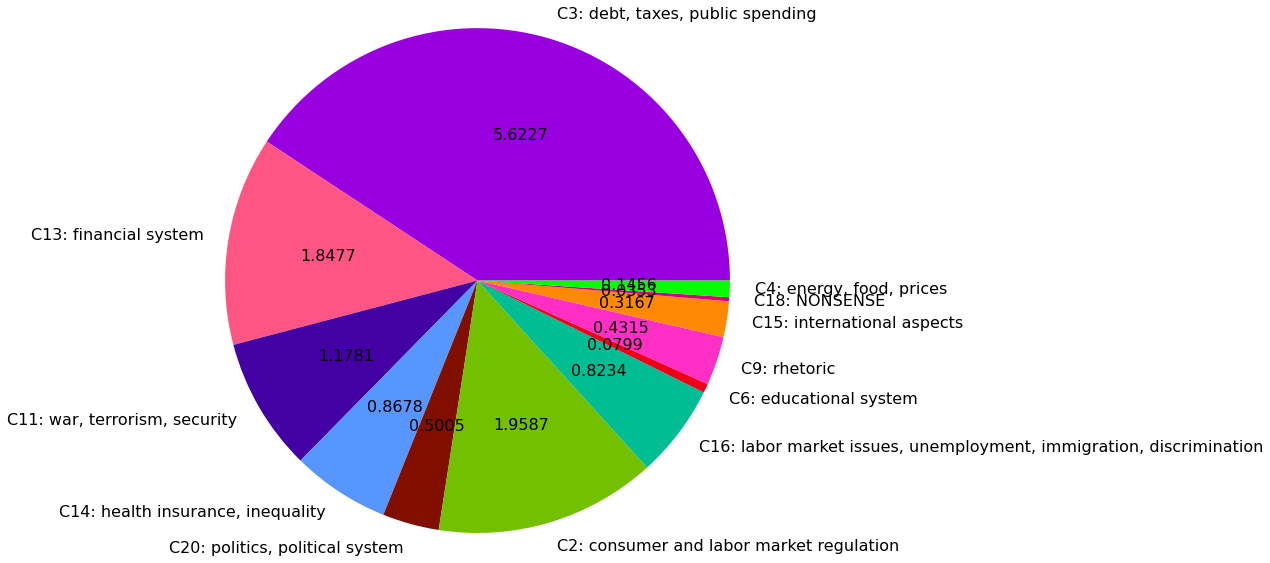

In [33]:
from collections import defaultdict

import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../Trigraph_n2.csv', decimal=',')
data_e = []
with open('../Trigraph_e.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data_e.append(row)
dfe = pd.DataFrame(data_e[1:], columns=data_e[0])
dfe = dfe.apply(pd.to_numeric, errors='coerce').fillna(dfe)

name = 'B65'
weighted = True

names = [
    'gambling',
    'crime, legal and illegal issues',
    'consumer and labor market regulation',
    'debt, taxes, public spending',
    'energy, food, prices',
    'news, media, technology',
    'educational system',
    'sports, athletes',
    'population, family',
    'rhetoric',
    'research',
    'war, terrorism, security',
    'diseases',
    'financial system',
    'health insurance, inequality',
    'international aspects',
    'labor market issues, unemployment, immigration, discrimination',
    'legal system, traffic',
    'NONSENSE',
    'disasters',
    'politics, political system'
]
color = [
    '#008a3b',
    '#f5dc00',
    '#73c000',
    '#9900e0',
    '#05ff00',
    '#00c4ff',
    '#f00016',
    '#ff85eb',
    '#4c463e',
    '#ff2ec4',
    '#7370ff',
    '#4300a3',
    '#31a800',
    '#ff5584',
    '#5795ff',
    '#ff8805',
    '#00bd94',
    '#0011f5',
    '#d60087',
    '#b88a00',
    '#800f00'
]

in_out = []
freq = []
node = df[df['Label'].str.startswith(name)]['Id'].values[0]
links = []

for row in dfe[dfe['Source'] == node].iterrows():
    trg = row[1]['Target']
    links.append((df[df['Id'] == trg]['modularity_class'].values[0], row[1]['Weight'] if weighted else 1))
for row in dfe[dfe['Target'] == node].iterrows():
    src = row[1]['Source']
    links.append((df[df['Id'] == src]['modularity_class'].values[0], row[1]['Weight'] if weighted else 1))

d = defaultdict(int)
for k, v in links:
    d[k] += v

labels = []
sizes = []
colors = []

for x, y in d.items():
    labels.append('C' + str(x) + ': ' + names[x])
    sizes.append(y)
    colors.append(color[x])

def absolute_value(val):
    a = np.round(val/100*sum(sizes), 4)
    return a

plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct=absolute_value, textprops={'fontsize': 16}, colors=colors)
plt.axis('equal')
plt.show()

In [19]:
for model in (posner_model, becker_model, topic_model):
    print(model.topics_.count(-1), len(model.topics_))

4828 15818
5275 15345
9053 31163


In [55]:
import csv

topic_names = {
    -1: 'Trash',
    0: 'Gambling',
    1: 'Crime and legal issues',
    2: 'Consumer and labor regulation',
    3: 'Public spending',
    4: 'Energy, food',
    5: 'News, media, technology',
    6: 'Educational system',
    7: 'Sports',
    8: 'Population, family',
    9: 'Rhetoric',
    10: 'Research',
    11: 'War, terrorism, security',
    12: 'Diseases',
    13: 'Financial system',
    14: 'Health insurance, inequality',
    15: 'International aspects',
    16: 'Unemployment, immigration, discrimination',
    17: 'Legal system, traffic',
    18: 'Nonsense',
    19: 'Disasters',
    20: 'Political system'
}

reverse_topic_names = {v: k for k, v in topic_names.items()}

becker_topic_merge = []
posner_topic_merge = []

with open('../Trigraph_n2.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        lbl = row['Label']
        if ':' in lbl and lbl.startswith('B') or lbl.startswith('P'):
            if lbl.startswith('B'):
                becker_topic_merge.append(topic_names[int(row['modularity_class'])])
            else:
                posner_topic_merge.append(topic_names[int(row['modularity_class'])])

becker_topic_merge = [reverse_topic_names[x] for x in becker_topic_merge]
posner_topic_merge = [reverse_topic_names[x] for x in posner_topic_merge]

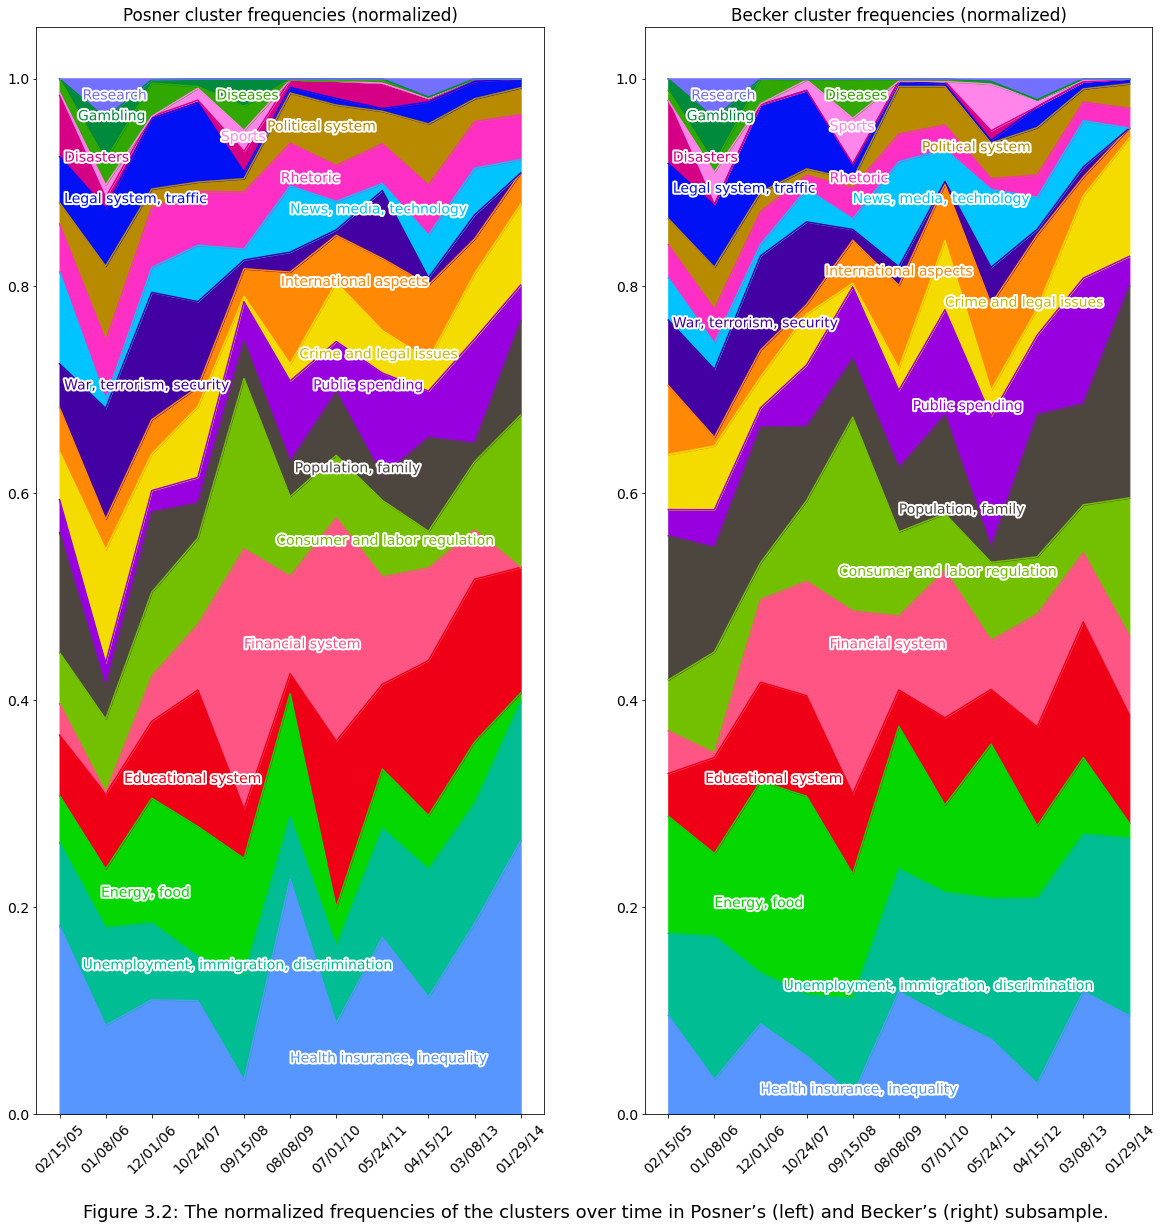

In [96]:
import matplotlib.patheffects as PathEffects

date_period = 327
normalize = True
last_date = all_sents_timestamps[0]
first_date = all_sents_timestamps[-1]

becker_topic_count = len(becker_model.get_topic_info())
posner_topic_count = len(posner_model.get_topic_info())

posner_topic_rep = []
becker_topic_rep = []

date_range = (last_date - first_date).days
date_xrange = []
cur_date = first_date - datetime.timedelta(days=255)
while cur_date <= last_date:
    date_xrange.append(cur_date.strftime("%m/%d/%y"))
    cur_date += datetime.timedelta(days=date_period)

for year in range(date_range // date_period + 1):
    posner_topic_rep.append([0] * len(topic_names))
    becker_topic_rep.append([0] * len(topic_names))
    
for i, doc in enumerate(topics_posner):
    date = posner_sents_timestamps[i]
    delta = (date - first_date).days
    # In the slice at time t, we increment the topic number doc
    if doc != -1:
        posner_topic_rep[delta // date_period][posner_topic_merge[doc]] += 1
    
for i, doc in enumerate(topics_becker):
    date = becker_sents_timestamps[i]
    delta = (date - first_date).days
    if doc != -1:
        becker_topic_rep[delta // date_period][becker_topic_merge[doc]] += 1

matplotlib.rcParams.update({'font.size': 14})

f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

topic_names__2 = sorted(topic_names.keys())
topic_names__2 = topic_names__2[1:] + [topic_names__2[0]]

df = pd.DataFrame(posner_topic_rep, columns=[topic_names[x] for x in topic_names__2])
df = df.drop(columns=topic_names[-1])
df = df.drop(columns='Nonsense')
if normalize:
    df = df.div(df.sum(axis=1), axis=0)

df2 = pd.DataFrame(becker_topic_rep, columns=[topic_names[x] for x in topic_names__2])
df2 = df2.drop(columns=topic_names[-1])
df2 = df2.drop(columns='Nonsense')
if normalize:
    df2 = df2.div(df2.sum(axis=1), axis=0)
    
idx = list(reversed((df.sum() + df2.sum()).sort_values().index))
order = [list(df.columns).index(i) for i in idx]
df = df[idx]
df2 = df2[idx]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = ['#008a3b', '#f5dc00', '#73c000', '#9900e0', '#04d800', '#00c4ff', '#f00016', '#ff85eb', '#4c463e', '#ff2ec4',
          '#7370ff', '#4300a3', '#31a800', '#ff5584', '#5795ff', '#ff8805', '#00bd94', '#0011f5', '#d60087', '#b88a00',
          '#800f00']
colors = [colors[i] for i in order]

cmap = matplotlib.colors.ListedColormap(colors)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)

df.plot.area(ax=ax, colormap=cmap)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(date_xrange, rotation=45)
ax.set_title('Posner cluster frequencies' + (' (normalized)' if normalize else ''))

df2.plot.area(ax=ax2, colormap=cmap)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_xticklabels(date_xrange, rotation=45)
ax2.set_title('Becker cluster frequencies' + (' (normalized)' if normalize else ''))

ax.get_legend().remove()
ax2.get_legend().remove()
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(-.5, 0.755))

locs = [
    [(5, .05), (2, .02)],
    [(.5, .14), (2.5, .12)],
    [(.9, .21), (1, .2)],
    [(1.4, .32), (.8, .32)],
    [(4, .45), (3.5, .45)],
    [(4.7, .55), (3.7, .52)],
    [(5.1, .62), (5, .58)],
    [(5.5, .7), (5.3, .68)],
    [(5.2, .73), (6, .78)],
    [(4.8, .80), (3.4, .81)],
    [(.1, .7), (.1, .76)],
    [(5, .87), (4, .88)],
    [(4.8, .9), (3.5, .9)],
    [(4.5, .95), (5.5, .93)],
    [(.1, .88), (.1, .89)],
    [(.1, .92), (.1, .92)],
    [(3.5, .94), (3.5, .95)],
    [(3.4, .98), (3.4, .98)],
    [(.4, .96), (.4, .96)],
    [(.5, .98), (.5, .98)]
]

for i, col in enumerate(df.columns):
    (x, y), (x2, y2) = locs[i]
    color = colors[i]
    if colors[i] == '#f5dc00':
        color = '#ceb900'
    txt = ax.text(x, y, col, color=color)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    txt = ax2.text(x2, y2, col, color=color)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

txt = 'Figure 3.2: The normalized frequencies of the clusters over time in Posner’s (left) and Becker’s (right) subsample.'
ax.text(0.5, -0.1, txt, fontsize=18)

#plt.show()
plt.savefig("shares.pdf", format="pdf", bbox_inches="tight")


In [18]:
import csv
clusters = dict()
with open('../Trigraph_n2.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        lbl = row['Label']
        if ':' in lbl and lbl.startswith('F'):
            clusters[int(lbl[1:].split(':')[0])] = int(row['modularity_class'])

res_post = defaultdict(lambda: [0]*(21))
res_topic = defaultdict(lambda: [0]*len(titles))

for sent, topic, ts in zip(all_sents, topic_model.topics_, all_sents_timestamps):
    title = sent_to_title[sent + str(ts)]
    title_idx = titles.index(title)
    if topic != -1:
        res_post[title][clusters[topic]] += 1
        res_topic[clusters[topic]][title_idx] += 1

In [19]:
import io
import csv

for title in titles:
    output = io.StringIO()
    writer = csv.writer(output, quoting=csv.QUOTE_NONNUMERIC)
    writer.writerow([title, *res_post[title]])
    print(output.getvalue()[:-1])

"The Embargo of Cuba: Time to Go- Becker",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0
"End the Cuban Embargo—Posner",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13,0,0,0,1
"Should Marijuana Be Decriminalized Nationwide?—Posner",0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Why Marijuana Should be Decriminalized- Becker  ",0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"The Myth of Excess Enrollments in College-Becker  ",0,0,0,0,0,0,27,0,1,1,0,0,0,0,0,0,0,0,0,0,0
"Excess Enrollments in College? Could Be. Posner",0,0,1,0,0,1,17,0,0,2,0,0,0,0,0,0,0,0,0,0,0
"Has the United States, by Virtue of Its Size and Complexity, Become Ungovernable?—Posner",0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,7
"Are Government Bureaucracies Too Big? Becker",0,0,13,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2
"Generational Mobility in the United States-Becker  ",0,0,0,0,0,0,2,0,23,0,0,0,0,0,1,0,0,0,0,0,0
"Social Mobility and Income Inequality—Posner",0,0,0,0,0,0,1,0,18,0,0,0,0,0,4,0,0,0,0,0,0
"Should Partisan Gerrymandering Be Outlawed? Pos

In [35]:
len(res_post.keys())

879

In [36]:
cnt = Counter()
shift = True
for i, title in enumerate(res_post):
    post = next(post for post in data if post['title'] == title)
    print(post['author'], title)
    cnt[post['author']] += 1
    if i % 2:
        if (post['author'] == last) == shift:
            print('='*160)
            shift = not shift
        print()
    last = post['author']
print(cnt)

Becker The Embargo of Cuba: Time to Go- Becker
Posner End the Cuban Embargo—Posner

Posner Should Marijuana Be Decriminalized Nationwide?—Posner
Becker Why Marijuana Should be Decriminalized- Becker  

Becker The Myth of Excess Enrollments in College-Becker  
Posner Excess Enrollments in College? Could Be. Posner

Posner Has the United States, by Virtue of Its Size and Complexity, Become Ungovernable?—Posner
Becker Are Government Bureaucracies Too Big? Becker

Becker Generational Mobility in the United States-Becker  
Posner Social Mobility and Income Inequality—Posner

Posner Should Partisan Gerrymandering Be Outlawed? Posner
Becker Neighborhood Gerrymandering- Becker

Becker Is the US in For Secular Stagnation: Déjà Vu All Over Again- Becker
Posner Secular Stagnation—Posner

Posner Bureaucracy and Efficiency—Posner
Becker Competition and the Efficiency of Bureaucracies- Becker

Becker Recent Mexican Reforms and the Impact on the United States-Becker
Posner Mexico’s Economic Reforms—P

Posner Mexico's Crime Problem--Posner's Comment
Posner Microfinance and Third World Poverty and Development--Posner

Becker Comment on Microfinance-BECKER
Becker Is There a Case for Legalizing Polygamy? BECKER

Posner Should Polygamy Be Legal?--Posner's Comment
Posner Should We Worry about Overpopulation?--Posner

Becker Comment on Overpopulation-BECKER
Becker Taxing Fat-BECKER

Posner The Fat Tax--Posner's Comment
Posner The Shalala Report on Women in Science and Engineering--Posner

Becker Comment on the NAS Report on Women in Science and Engineering-BECKER
Becker DDT and Deaths From Malaria ‚ÄìBECKER

Posner DDT, Malaria, and the Environment--Posner's Comment
Posner Deterring Identity Theft--Posner

Becker On Identity Theft-BECKER
Becker Test Scores and Economic Performance-BECKER

Posner Our Bad Math Scores--Posner's Comment
Posner Extending Life--Posner

Becker Comment on Extending Life-BECKER
Becker Doping in Sports-BECKER

Posner Doping Athletes--Posner's Comment
Posner The Econ

In [38]:
for topic in topic_model.get_topics():
    print(topic, ', '.join(x[0] for x in topic_model.get_topic(topic)))

-1 government, economic, financial, spending, crisis, economy, federal, countries, growth, private, capital, companies, tax, money, rates, income, market, business, markets, example, war, world, united, american, future
0 health, insurance, care, medical, medicare, life, age, elderly, retirement, coverage, security, social, medicaid, people, spending, older, ages, expectancy, benefits, pay, uninsured, employees, costs, old, 65
1 college, education, students, tuition, colleges, student, loans, graduates, earnings, school, forprofit, universities, higher, loan, graduate, schools, nonprofit, institutions, university, increased, benefit, benefits, attending, private, returns
2 immigrants, illegal, immigration, mexico, amnesty, skilled, citizenship, border, mexican, immigrate, illegally, immigrant, states, workers, citizens, fee, outsourcing, mexicans, american, born, children, number, right, jobs, deported
3 obesity, fats, trans, foods, obese, weight, restaurants, fat, drinks, overweight, 

In [105]:
Counter(nltk.word_tokenize(''.join(processed_becker_sents + processed_posner_sents))).most_common(50)

[('would', 5034),
 ('government', 2069),
 ('much', 1940),
 ('many', 1841),
 ('tax', 1628),
 ('may', 1616),
 ('even', 1567),
 ('economic', 1546),
 ('also', 1536),
 ('countries', 1418),
 ('one', 1346),
 ('since', 1334),
 ('increase', 1298),
 ('people', 1236),
 ('states', 1224),
 ('health', 1210),
 ('income', 1199),
 ('united', 1145),
 ('cost', 1131),
 ('high', 1105),
 ('higher', 1080),
 ('less', 1064),
 ('rates', 1060),
 ('federal', 1042),
 ('costs', 1026),
 ('rather', 1011),
 ('american', 986),
 ('reduce', 976),
 ('large', 972),
 ('could', 955),
 ('--', 945),
 ('financial', 939),
 ('spending', 933),
 ('private', 932),
 ('rate', 925),
 ('public', 919),
 ('greater', 915),
 ('percent', 909),
 ('years', 892),
 ('time', 884),
 ('new', 881),
 ('growth', 852),
 ('well', 837),
 ('prices', 831),
 ('children', 820),
 ('benefits', 816),
 ('education', 811),
 ('political', 810),
 ('social', 800),
 ('workers', 780)]

In [24]:
l = []
for x in range(max(topics) + 1):
    l.append((topics.count(x), x))
l2 = []
dict_f = dict()
dict_f2 = dict()
for i, x in enumerate(sorted(l, reverse=True)):
    l2.append((x[1], i))
    print('F' + str(i), '← F' + str(x[1]))
    print(x, ', '.join(y[0] for y in topic_model.get_topic(x[1])))
    dict_f[i] = x[1]
    dict_f2[x[1]] = i
for x, y in sorted(l2):
    print('F' + str(x), '→ F' + str(y))

F0 ← F0
(2021, 0) health, insurance, care, medical, medicare, life, age, elderly, retirement, coverage, security, social, medicaid, people, spending, older, ages, expectancy, benefits, pay, uninsured, employees, costs, old, 65
F1 ← F2
(850, 2) immigrants, illegal, immigration, mexico, amnesty, skilled, citizenship, border, mexican, immigrate, illegally, immigrant, states, workers, citizens, fee, outsourcing, mexicans, american, born, children, number, right, jobs, deported
F2 ← F1
(818, 1) college, education, students, tuition, colleges, student, loans, graduates, earnings, school, forprofit, universities, higher, loan, graduate, schools, nonprofit, institutions, university, increased, benefit, benefits, attending, private, returns
F3 ← F3
(543, 3) obesity, fats, trans, foods, obese, weight, restaurants, fat, drinks, overweight, eating, food, restaurant, ban, sedentary, health, calorie, beverages, consumption, consequences, consumers, teenagers, sugar, television, heart
F4 ← F5
(483, 5

In [25]:
l = []
for x in range(max(topics_becker) + 1):
    l.append((topics_becker.count(x), x))
l2 = []
dict_b = dict()
dict_b2 = dict()
for i, x in enumerate(sorted(l, reverse=True)):
    l2.append((x[1], i))
    print('B' + str(i), '← B' + str(x[1]))
    print(x, ', '.join(y[0] for y in becker_model.get_topic(x[1])))
    dict_b[i] = x[1]
    dict_b2[x[1]] = i
for x, y in sorted(l2):
    print('B' + str(x), '→ B' + str(y))

B0 ← B0
(339, 0) tax, taxes, income, revenue, estate, incomes, taxed, consumption, marginal, flat, wealth, rates, savings, raise, corporate, code, businesses, gains, estates, evasion, taxation, capital, deductions, compliance, investments
B1 ← B1
(315, 1) college, tuition, colleges, students, education, graduates, school, earnings, schools, higher, universities, increased, graduate, average, dropouts, university, costs, public, benefits, student, better, forprofit, 1980, increase, returns
B2 ← B3
(304, 3) unemployment, unemployed, rate, recession, employment, jobs, longterm, workers, labor, job, underemployment, recessions, extension, work, weeks, employed, compensation, recovery, benefits, peak, target, percentage, remain, hires, high
B3 ← B2
(285, 2) immigrants, illegal, immigration, immigrate, residents, amnesty, illegally, skilled, border, legally, citizenship, number, status, stay, approach, employers, aliens, pay, workers, came, apprehended, mexico, policy, undocumented, united
B

In [26]:
l = []
for x in range(max(topics_posner) + 1):
    l.append((topics_posner.count(x), x))
l2 = []
dict_p = dict()
dict_p2 = dict()
for i, x in enumerate(sorted(l, reverse=True)):
    l2.append((x[1], i))
    print('P' + str(i), '← P' + str(x[1]))
    print(x, ', '.join(y[0] for y in posner_model.get_topic(x[1])))
    dict_p[i] = x[1]
    dict_p2[x[1]] = i
for x, y in sorted(l2):
    print('P' + str(x), '→ P' + str(y))

P0 ← P0
(1028, 0) health, insurance, medical, care, medicare, people, elderly, retirement, medicaid, physicians, longevity, premiums, security, benefits, costs, healthcare, old, insured, uninsured, pay, malpractice, patients, average, afford, insurers
P1 ← P1
(675, 1) college, students, education, colleges, schools, universities, tuition, school, student, university, forprofit, alumni, public, graduates, teachers, faculty, loans, children, teacher, benefit, attend, parents, institutions, donations, teaching
P2 ← P2
(455, 2) oil, carbon, gasoline, emissions, warming, global, dioxide, fuels, atmosphere, prices, tax, gas, fossil, energy, reduce, drilling, supply, taxes, burning, production, demand, ethanol, increase, dependence, greenhouse
P3 ← P3
(420, 3) skeptical, know, think, point, reasons, question, dont, incorrect, questions, doubt, study, preconceptions, analysis, thing, guess, arguments, conscious, information, brush, points, results, realistic, suggestion, expectation, exception

In [27]:
# <402: post-crisis
# 402-485: crisis
# 486+: pre-crisis

pre = cri = post = 0
posts = defaultdict(set)
posts_l = defaultdict(list)
for att, topic in zip(attribution, topics):
    posts[att].add(topic)
    posts_l[att].append(topic)
pre = 401
cri = 84
post = 878 - pre - cri

ratio_f = dict()

out_data = []
for i in range(max(topics)):
    cnt = total = 0
    pre2 = cri2 = post2 = 0
    for k, v in posts_l.items():
        if v.count(i):
            total += 1
            if v.count(i) >= 0.1*len(v):
                cnt += 1
            if abs(k) < 402:
                post2 += 1
            elif abs(k) < 486:
                cri2 += 1
            else:
                pre2 += 1
    a, b, c = pre2/pre/total, cri2/cri/total, post2/post/total
    total2 = a + b + c
    a, b, c = 100*a/total2, 100*b/total2, 100*c/total2
    if b - a > 20 and b - c > 20:
        val = 'Peak'
    elif c - a > 20:
        val = 'Increase'
    elif a - c > 20:
        val = 'Decrease'
    elif abs(a - c) < 20:
        val = 'Balanced'
    else:
        val = '???'
    out_data.append((dict_f2[i], f'{i:<3} {len([x for x in posts.values() if i in x]):<5} {cnt/total:<.2f} {a:<5.2f} {b:<5.2f} {c:<5.2f} {val}', ', '.join(x[0] for x in topic_model.get_topic(i))))
    ratio_f[dict_f2[i]] = cnt/total

dict_res = defaultdict(list)
for i, (_, y, z) in enumerate(sorted(out_data)):
    #print(i, y)
    dict_res[y.split(' ')[-1]].append(i)
    #print(z)
    #print()
for k, v in dict_res.items():
    print(k)
    print(', '.join('F' + str(x) for x in v))

Balanced
F0, F1, F2, F3, F5, F8, F9, F11, F12, F15, F16, F17, F20, F24, F25, F26, F32, F33, F37, F41, F43, F46, F48, F50, F53, F54, F56, F63, F64, F66, F68, F71, F74, F79, F81, F82, F84, F89, F96, F103, F106, F113, F117, F118, F119, F124, F126, F128
Increase
F4, F19, F23, F27, F31, F34, F61, F65, F70, F72, F83, F92, F94, F104, F120, F130, F132
Decrease
F6, F13, F21, F28, F29, F30, F36, F38, F40, F42, F44, F47, F51, F52, F55, F57, F58, F59, F60, F62, F67, F75, F77, F78, F80, F85, F86, F87, F88, F90, F91, F97, F98, F100, F101, F102, F107, F108, F110, F112, F114, F115, F116, F121, F122, F123, F125, F129, F131
Peak
F7, F10, F14, F18, F22, F35, F39, F45, F49, F69, F73, F76, F93, F95, F99, F105, F109, F111, F127


In [28]:
# <402: post-crisis
# 402-485: crisis
# 486+: pre-crisis

pre = cri = post = 0
posts = defaultdict(set)
posts_l = defaultdict(list)
for att, topic in zip(attribution_p, topics_posner):
    posts[att].add(topic)
    posts_l[att].append(topic)
pre = 401
cri = 84
post = 878 - pre - cri

ratio_p = dict()

out_data = []
for i in range(max(topics_posner)):
    cnt = total = 0
    pre2 = cri2 = post2 = 0
    for k, v in posts_l.items():
        if k > 0:
            if v.count(i):
                total += 1
                if v.count(i) >= 0.1*len(v):
                    cnt += 1
                if abs(k) < 402:
                    post2 += 1
                elif abs(k) < 486:
                    cri2 += 1
                else:
                    pre2 += 1
    a, b, c = pre2/pre/total, cri2/cri/total, post2/post/total
    total2 = a + b + c
    a, b, c = 100*a/total2, 100*b/total2, 100*c/total2
    if b - a > 20 and b - c > 20:
        val = 'Peak'
    elif c - a > 20:
        val = 'Increase'
    elif a - c > 20:
        val = 'Decrease'
    elif abs(a - c) < 20:
        val = 'Balanced'
    else:
        val = '???'
    out_data.append((dict_p2[i], f'{i:<3} {len([x for x in posts.values() if i in x]):<5} {cnt/total:<.2f} {a:<5.2f} {b:<5.2f} {c:<5.2f} {val}', ', '.join(x[0] for x in posner_model.get_topic(i))))
    ratio_p[dict_p2[i]] = cnt/total

dict_res = defaultdict(list)
for i, (_, y, z) in enumerate(sorted(out_data)):
    #print(i, y)
    dict_res[y.split(' ')[-1]].append(i)
    #print(z)
    #print()
for k, v in dict_res.items():
    print(k)
    print(', '.join('P' + str(x) for x in v))

Balanced
P0, P1, P2, P3, P5, P6, P8, P10, P12, P13, P16, P18, P19, P22, P23, P24, P25, P26, P27, P32, P34, P43, P44, P45, P51, P54, P56, P57, P59, P65, P67, P70, P72
Decrease
P4, P9, P15, P17, P20, P28, P33, P36, P37, P39, P40, P41, P47, P48, P52, P53, P55, P58, P61, P62, P63, P68, P69
Peak
P7, P11, P21, P38, P46, P49, P50, P60, P66, P73
Increase
P14, P29, P30, P31, P35, P42, P64, P71


In [29]:
# <402: post-crisis
# 402-485: crisis
# 486+: pre-crisis

pre = cri = post = 0
posts = defaultdict(set)
posts_l = defaultdict(list)
for att, topic in zip(attribution_b, topics_becker):
    posts[att].add(topic)
    posts_l[att].append(topic)
pre = 401
cri = 84
post = 878 - pre - cri

ratio_b = dict()
out_data = []
for i in range(max(topics_posner)):
    cnt = total = 0
    pre2 = cri2 = post2 = 0
    for k, v in posts_l.items():
        if k < 0:
            if v.count(i):
                total += 1
                if v.count(i) >= 0.1*len(v):
                    cnt += 1
                if abs(k) < 402:
                    post2 += 1
                elif abs(k) < 486:
                    cri2 += 1
                else:
                    pre2 += 1
    a, b, c = pre2/pre/total, cri2/cri/total, post2/post/total
    total2 = a + b + c
    a, b, c = 100*a/total2, 100*b/total2, 100*c/total2
    if b - a > 20 and b - c > 20:
        val = 'Peak'
    elif c - a > 20:
        val = 'Increase'
    elif a - c > 20:
        val = 'Decrease'
    elif abs(a - c) < 20:
        val = 'Balanced'
    else:
        val = '???'
    out_data.append((dict_b2[i], f'{i:<3} {len([x for x in posts.values() if i in x]):<5} {cnt/total:<.2f} {a:<5.2f} {b:<5.2f} {c:<5.2f} {val}', ', '.join(x[0] for x in becker_model.get_topic(i))))
    ratio_b[dict_b2[i]] = cnt/total

dict_res = defaultdict(list)
for i, (_, y, z) in enumerate(sorted(out_data)):
    #print(i, y)
    dict_res[y.split(' ')[-1]].append(i)
    #print(z)
    #print()
for k, v in dict_res.items():
    print(k)
    print(', '.join('B' + str(x) for x in v))

Balanced
B0, B1, B3, B5, B6, B7, B8, B9, B11, B12, B14, B15, B17, B20, B21, B22, B23, B25, B30, B31, B32, B34, B36, B38, B39, B45, B47, B48, B49, B53, B54, B61, B62, B64, B65, B67, B68, B70
Increase
B2, B16, B29, B33, B51, B56, B57, B59, B66, B72
Peak
B4, B13, B19, B35, B40, B42, B44, B69, B73
Decrease
B10, B18, B24, B26, B27, B28, B37, B41, B43, B46, B50, B52, B55, B58, B60, B63, B71


In [30]:
import csv

topic_names = {
    -1: 'Trash',
    0: 'Gambling',
    1: 'Crime and legal issues',
    2: 'Consumer and labor regulation',
    3: 'Public spending',
    4: 'Energy, food',
    5: 'News, media, technology',
    6: 'Educational system',
    7: 'Sports',
    8: 'Population, family',
    9: 'Rhetoric',
    10: 'Research',
    11: 'War, terrorism, security',
    12: 'Diseases',
    13: 'Financial system',
    14: 'Health insurance, inequality',
    15: 'International aspects',
    16: 'Unemployment, immigration, discrimination',
    17: 'Legal system, traffic',
    18: 'Nonsense',
    19: 'Disasters',
    20: 'Political system'
}

reverse_topic_names = {v: k for k, v in topic_names.items()}

becker_topic_merge = []
posner_topic_merge = []
full_topic_merge = []

with open('../Trigraph_n2.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        lbl = row['Label']
        if ':' in lbl and lbl.startswith('B') or lbl.startswith('P') or lbl.startswith('F'):
            if lbl.startswith('B'):
                becker_topic_merge.append(topic_names[int(row['modularity_class'])])
            elif lbl.startswith('P'):
                posner_topic_merge.append(topic_names[int(row['modularity_class'])])
            else:
                full_topic_merge.append(topic_names[int(row['modularity_class'])])

becker_topic_merge = [reverse_topic_names[x] for x in becker_topic_merge]
posner_topic_merge = [reverse_topic_names[x] for x in posner_topic_merge]
full_topic_merge = [reverse_topic_names[x] for x in full_topic_merge]

In [31]:
cnt_f = Counter()
cnt_b = Counter()
cnt_p = Counter()
for topic in topics:
    if topic != -1:
        cnt_f[full_topic_merge[dict_f[topic]]] += 1
for topic in topics_becker:
    if topic != -1:
        cnt_b[becker_topic_merge[dict_b[topic]]] += 1
for topic in topics_posner:
    if topic != -1:
        cnt_p[posner_topic_merge[dict_p[topic]]] += 1

for k, v in sorted(cnt_f.items(), key=lambda x: x[0]):
    print(topic_names[k], v)
print()
for k, v in sorted(cnt_p.items(), key=lambda x: x[0]):
    print(topic_names[k], v)
print()
for k, v in sorted(cnt_b.items(), key=lambda x: x[0]):
    print(topic_names[k], v)

Gambling 164
Crime and legal issues 931
Consumer and labor regulation 1490
Public spending 1118
Energy, food 1842
News, media, technology 990
Educational system 2007
Sports 170
Population, family 1498
Rhetoric 720
Research 146
War, terrorism, security 733
Diseases 240
Financial system 1575
Health insurance, inequality 2411
International aspects 1050
Unemployment, immigration, discrimination 2341
Legal system, traffic 740
Nonsense 54
Disasters 275
Political system 768

Gambling 95
Crime and legal issues 493
Consumer and labor regulation 833
Public spending 499
Energy, food 835
News, media, technology 421
Educational system 991
Sports 56
Population, family 580
Rhetoric 513
Research 56
War, terrorism, security 553
Diseases 120
Financial system 924
Health insurance, inequality 1418
International aspects 459
Unemployment, immigration, discrimination 902
Legal system, traffic 355
Disasters 166
Political system 371

Gambling 80
Crime and legal issues 419
Consumer and labor regulation 727
Publ

In [32]:
clusters = defaultdict(list)
for topic, cluster in enumerate(becker_topic_merge):
    try:
        clusters[cluster].append(ratio_b[topic])
    except:
        pass
for topic, cluster in enumerate(posner_topic_merge):
    try:
        clusters[cluster].append(ratio_p[topic])
    except:
        pass
for topic, cluster in enumerate(full_topic_merge):
    try:
        clusters[cluster].append(ratio_f[topic])
    except:
        pass
for k, v in clusters.items():
    print(topic_names[k].ljust(50), sum(v)/len(v))

Public spending                                    0.3662725516768686
Educational system                                 0.3496681354404267
Unemployment, immigration, discrimination          0.3269386803060901
Population, family                                 0.35271566844165136
Financial system                                   0.2599276412662659
Energy, food                                       0.31639947791713086
News, media, technology                            0.3733472430373624
Health insurance, inequality                       0.37169600083016163
Consumer and labor regulation                      0.2990590436564946
War, terrorism, security                           0.3451792957434695
Rhetoric                                           0.32402684682623173
Sports                                             0.34322981366459626
Political system                                   0.28587891800452186
Legal system, traffic                              0.2573308042225155
International 

In [10]:
topics.count(-1)/len(topics)

0.3162362928899894

In [13]:
topics_posner.count(-1)/len(topics_posner)

0.3286219081272085

In [14]:
topics_becker.count(-1)/len(topics_becker)

0.379434717030625

In [42]:
df[df['Label'].str.startswith('B82')]['In vs out']

82    0.857143
Name: In vs out, dtype: float64

In [50]:
df[df['Label'].str.startswith('P6')]['Frequency']

226    390
280     51
281     46
282     46
283     45
284     45
285     44
286     43
287     43
288     42
289     41
Name: Frequency, dtype: int64